# ITABLES


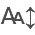

In [1]:
# to enable itables
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

# CONFIGURACION DELTA SPARK

In [2]:
import os
import shutil

from delta import configure_spark_with_delta_pip
from pyspark.sql import SparkSession


def ensure_directories_exist(warehouse_dir, metastore_db_path):
    """
    Ensures the necessary directories for the warehouse and metastore exist.

    Parameters:
        warehouse_dir (str): Path to the warehouse directory (Spark catalog).
        metastore_db_path (str): Path to the metastore database.
    """
    os.makedirs(warehouse_dir, exist_ok=True)
    os.makedirs(os.path.dirname(metastore_db_path), exist_ok=True)

def create_spark_session(
    app_name="DeltaCatalog",
    warehouse_dir="./warehouse-spark/spark_catalog",
    metastore_db_path="./warehouse-spark/metastore_db",
):
    """
    Creates and initializes a SparkSession with Delta Lake support and persistent metastore.

    Parameters:
        app_name (str): Name of the Spark application.
        warehouse_dir (str): Path to the Spark catalog warehouse directory.
        metastore_db_path (str): Path to the persistent metastore database (Derby).

    Returns:
        SparkSession: Configured SparkSession instance.
    """
    # Ensure required directories exist
    ensure_directories_exist(warehouse_dir, metastore_db_path)

    # Configure SparkSession with Delta Lake
    builder = (
        SparkSession.builder.appName(app_name)
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
        .config(
            "spark.sql.catalog.spark_catalog",
            "org.apache.spark.sql.delta.catalog.DeltaCatalog",
        )
        .config("spark.sql.parquet.compression.codec", "gzip")
        .config("spark.databricks.delta.optimizeWrite.enabled", "true")
        .config("spark.databricks.delta.autoCompact.enabled", "true")
        .config("spark.sql.warehouse.dir", os.path.abspath(warehouse_dir))
        .config(
            "javax.jdo.option.ConnectionURL",
            f"jdbc:derby:{os.path.abspath(metastore_db_path)};create=true",
        )
    )  # .config("spark.sql.catalogImplementation", "hive") \
    # .enableHiveSupport()

    # Initialize Spark with Delta
    spark = configure_spark_with_delta_pip(builder).getOrCreate()

    print(
        f"SparkSession created with Delta and persistent metastore at: {warehouse_dir}"
    )
    return spark

# CREAR DATABASE AND DELTA TABLES

In [3]:
def create_database(spark_session, database_name):
    """
    Creates a database if it does not already exist.

    Parameters:
        spark_session (SparkSession): The active SparkSession.
        database_name (str): The name of the database to be created.
    """
    spark_session.sql(f"CREATE DATABASE IF NOT EXISTS {database_name}")
    print(f"Database '{database_name}' created or already exists.")


def list_all_databases_and_tables(spark_session):
    """
    Lists all databases and their tables in Spark.

    Parameters:
        spark_session (SparkSession): The active SparkSession.

    Returns:
        dict: A dictionary where keys are database names and values are lists of table names in each database.
    """
    # List all databases
    databases = spark_session.catalog.listDatabases()

    # Create a dictionary to store database names and their corresponding table lists
    database_tables = {}

    print("The following databases and tables are present in the Spark Catalog.")
    print()

    for database in databases:
        # Set the current database to the specified database
        spark_session.sql(f"USE {database.name}")

        # List all tables in the database
        tables = spark_session.catalog.listTables(database.name)

        # Extract table names from the list of table objects
        table_names = [table.name for table in tables]

        # Store the tables for the current database
        database_tables[database.name] = table_names

        # Print the database and tables
        for table in table_names:
            print(f"Database: {database.name}, Table: {table}")
            print()

    return database_tables

# CREATE SPARK DATAFRAME

In [4]:
def create_dataframe_from_list_dict_using_alphabetical_order_from_columns(
    spark_session, list_data_dict
):
    """
    Creates a Spark DataFrame from a list of dictionaries, reordering columns in alphabetical order.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        list_data_dict (list): A list of dictionaries, where each dictionary represents a row.

    Returns:
        DataFrame: The created Spark DataFrame with columns in alphabetical order.
    """
    if list_data_dict:
        df = spark_session.createDataFrame(list_data_dict)
        return df
    else:
        raise ValueError("The input list is empty.")


def create_dataframe_from_list_dict(spark_session, list_data_dict):
    """
    Creates a Spark DataFrame from a list of dictionaries, preserving the order of the keys.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        list_data_dict (list): A list of dictionaries, where each dictionary represents a row.

    Returns:
        DataFrame: The created Spark DataFrame with columns in the order of the keys.
    """
    if not list_data_dict:
        raise ValueError("The input list is empty.")

    # Get the order of keys from the first dictionary
    columns_order = list(list_data_dict[0].keys())

    # Create the DataFrame and reorder columns
    df = spark_session.createDataFrame(list_data_dict)
    df = df.select(*columns_order)  # Reorder columns explicitly

    return df


def split_spark_dataframe(spark_dataframe, num_parts):
    """
    Splits a Spark DataFrame into the specified number of parts, ensuring each part has at least one row.
    If the requested number of parts exceeds the total rows, it creates as many balanced parts as possible.

    Parameters:
        spark_dataframe (DataFrame): The Spark DataFrame to be split.
        num_parts (int): The desired number of parts to split the DataFrame into.

    Returns:
        List[DataFrame]: A list containing the split DataFrames.
    """
    total_rows = spark_dataframe.count()

    if total_rows == 0:
        print("The DataFrame is empty. No parts created.")
        return []

    # Adjust number of parts if more parts are requested than rows
    actual_parts = min(num_parts, total_rows)

    # Calculate base rows per part and distribute remaining rows
    rows_per_part = total_rows // actual_parts
    extra_rows = total_rows % actual_parts

    split_dataframes = []
    start_row = 0
    
    for i in range(actual_parts):
        # Calculate rows for the current part
        rows_in_this_part = rows_per_part + (1 if i < extra_rows else 0)
        end_row = start_row + rows_in_this_part
        
        # Select the rows for the current part using offset and limit
        split_dataframes.append(
            spark_dataframe.offset(start_row).limit(rows_in_this_part)
        )
        
        start_row = end_row  # Update start row for the next part

    print(f"Successfully created {len(split_dataframes)} DataFrames.")
    return split_dataframes

# CREAR TABLAS DELTA

In [5]:
import os
import shutil

def create_delta_table_with_spark_dataframe_and_register(
    spark_session, database_name, table_name, spark_dataframe, warehouse_dir, partition_by=None
):
    """
    Creates a Delta table in the specified database and registers it with SQL.

    Parameters:
        spark_session (SparkSession): The active SparkSession.
        database_name (str): The name of the database where the table will be created.
        table_name (str): The name of the table to be created.
        spark_dataframe (DataFrame): The Spark DataFrame whose data will be used to create the table.
        warehouse_dir (str): The root directory for the warehouse.
        partition_by (list, optional): List of column names to partition the table by (default is None).
    """
    # Ensure the database exists or create it
    available_databases = [db.name for db in spark_session.catalog.listDatabases()]
    if database_name not in available_databases:
        spark_session.sql(f"CREATE DATABASE IF NOT EXISTS {database_name}")

    # Set the active database
    spark_session.sql(f"USE {database_name}")

    # Define the table path based on the database and table name
    table_path = f"{warehouse_dir}/{database_name}/{table_name}"

    write_options = spark_dataframe.write.format("delta").mode("overwrite")

    # Apply partitioning if specified
    if partition_by:
        write_options.partitionBy(*partition_by)

    # Save the DataFrame as a Delta table in the location
    write_options.save(table_path)

    # Register the Delta table in the Spark catalog using SQL
    spark_session.sql(
        f"""
        CREATE OR REPLACE TABLE {table_name}
        USING DELTA
        AS
        SELECT * FROM parquet.`{table_path}`;
    """
    )

    # Delete the files generated in the table path
    if os.path.exists(table_path):
        shutil.rmtree(table_path)
        print(f"Temporary files at '{table_path}' have been deleted.")
    else:
        print(f"No temporary files found at '{table_path}'.")

    print(
        f"Table '{table_name}' created and registered at '{table_path}' in database '{database_name}' with partitioning by {partition_by if partition_by else 'None'}."
    )
    
def save_dataframe_as_parquet(spark_dataframe, file_name, file_path, partition_by=None):
    """
    Saves a Spark DataFrame to the specified path in Parquet format.

    Parameters:
        spark_dataframe (DataFrame): The Spark DataFrame to be saved.
        file_name (str): The name of the file (or dataset) to be created.
        file_path (str): The location where the file will be stored.
        partition_by (list, optional): List of column names to partition the data by (default is None).
    """
    write_options = spark_dataframe.write.format("parquet").mode("overwrite")

    if partition_by:
        write_options.partitionBy(*partition_by)
        
    write_options.save(file_path)
    print(f"DataFrame saved as Delta Parquet at '{file_path}/{file_name}' with partitioning by {partition_by if partition_by else 'None'}.")

def save_dataframe_as_delta_parquet(spark_dataframe, file_name, file_path, partition_by=None):
    """
    Saves a Spark DataFrame to the specified path in Delta Parquet format.

    Parameters:
        spark_dataframe (DataFrame): The Spark DataFrame to be saved.
        file_name (str): The name of the file (or dataset) to be created.
        file_path (str): The location where the file will be stored.
        partition_by (list, optional): List of column names to partition the data by (default is None).
    """
    write_options = spark_dataframe.write.format("delta").mode("overwrite")

    # Apply partitioning if partition_by is provided
    if partition_by:
        write_options.partitionBy(*partition_by)

    # Save the DataFrame as a Delta Parquet file at the specified location
    write_options.save(f"{file_path}/{file_name}")

    print(f"DataFrame saved as Delta Parquet at '{file_path}/{file_name}' with partitioning by {partition_by if partition_by else 'None'}.")


def create_delta_table_in_database(spark_session, database_name, table_name, spark_dataframe, warehouse_dir, partition_by=None):
    """
    Creates a Delta table in a Spark database, ensuring that any existing table or directory is deleted before creating
    the new table. The table is created with the delta.enableChangeDataFeed property enabled.

    Parameters:
    spark_session (SparkSession): The active Spark session to run SQL queries.
    database_name (str): The name of the database where the table will be stored.
    table_name (str): The name of the table to be created.
    spark_dataframe (DataFrame): The DataFrame to be saved as a Delta table.
    warehouse_dir (str): The base directory where Delta tables are stored.
    partition_by (list, optional): List of columns to partition the table by. If not provided, the table will not be partitioned.

    Exceptions:
    - If the specified partition columns do not exist in the DataFrame, a ValueError will be raised.
    """
    
    # Define the path for the Delta table
    table_path = f"{warehouse_dir}/{database_name}/{table_name}"
    full_table_name = f"{database_name}.{table_name}"

    # Remove the table directory if it exists (manually)
    if os.path.exists(table_path):
        shutil.rmtree(table_path)  # Remove the directory and its contents
        print(f"Directory for table '{full_table_name}' deleted.")

    # Drop the table from the database if it exists (to avoid conflicts)
    try:
        spark_session.sql(f"DROP TABLE IF EXISTS {full_table_name}")
        print(f"Table '{full_table_name}' dropped.")
    except Exception as e:
        print(f"Could not drop the table: {str(e)}")

    # Write the new Delta table with overwrite mode
    write_options = spark_dataframe.write.format("delta").mode("overwrite")

    # Check if partitioning is specified and verify columns exist in the DataFrame
    if partition_by:
        missing_columns = [col for col in partition_by if col not in spark_dataframe.columns]
        if missing_columns:
            raise ValueError(f"The following partition columns do not exist in the DataFrame: {missing_columns}")
        write_options = write_options.partitionBy(*partition_by)

    # Save the Delta table in the database
    write_options.saveAsTable(full_table_name)

    # Enable Change Data Feed on the Delta table
    try:
        spark_session.sql(f"ALTER TABLE {full_table_name} SET TBLPROPERTIES ('delta.enableChangeDataFeed' = 'true')")
        print(f"Property 'delta.enableChangeDataFeed' enabled for table '{full_table_name}'.")
    except Exception as e:
        print(f"Error enabling 'delta.enableChangeDataFeed': {str(e)}")

    print(f"Table '{table_name}' created in database '{database_name}' at '{table_path}' with partitioning by {partition_by if partition_by else 'none'}.")

def read_parquet_or_delta_file(spark_session, directory_path):
    """
    Reads a Parquet or Delta file from the specified directory path.

    This function attempts to read a Parquet file from the provided path using the Spark session. 
    If the operation fails (e.g., the file does not exist or the format is incompatible), 
    an error message is displayed, and None is returned.

    Parameters:
        spark_session (SparkSession): The active Spark session used for reading the file.
        directory_path (str): The path to the directory containing the Parquet or Delta file.

    Returns:
        DataFrame: The DataFrame containing the file's data if successfully read.
        None: If an error occurs during the file reading process.

    Example:
        # Create a Spark session
        spark = SparkSession.builder.appName("ReadExample").getOrCreate()

        # Read a Parquet or Delta file
        df = read_parquet_or_delta_file(spark, "/path/to/directory")

        if df is not None:
            df.show()
        else:
            print("Failed to read the file.")
    """
    try:
        df = spark_session.read.parquet(directory_path)
        print(f"Successfully read Parquet file from '{directory_path}'.")
        return df
    except Exception as e:
        print(f"Error reading file from '{directory_path}': {e}")
        return None
        
def execute_spark_sql_query(
    spark_session: SparkSession, query: str
) -> "pyspark.sql.dataframe.DataFrame":
    """
    Execute a SQL query and return the results as a DataFrame.

    :param spark_session: The SparkSession object.
    :param query: The SQL query to execute.
    :return: A PySpark DataFrame containing the query results.
    """
    return spark_session.sql(query)

# CRUD SPARK DATAFRAMES

In [6]:
from pyspark.sql.functions import expr, col
from pyspark.sql import SparkSession
from delta.tables import DeltaTable
import pandas as pd
from pandas import Timestamp

def is_delta_table(spark_session: SparkSession, delta_table_path: str) -> bool:
    """
    Checks if a given path corresponds to a Delta table.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        delta_table_path (str): The file path to check.

    Returns:
        bool: True if the path is a Delta table, False otherwise.
    """
    return (
        DeltaTable.forPath(spark_session, delta_table_path)
        if DeltaTable.isDeltaTable(spark_session, delta_table_path)
        else False
    )


def restore_delta_lake_to_version(
    spark_session: SparkSession, delta_table_path: str, version: int = None, timestamp: str = None
):
    """
    Restores a Delta table to a specific version or timestamp.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        delta_table_path (str): The Delta table path.
        version (int, optional): The version to restore to.
        timestamp (str, optional): The timestamp to restore to in ISO format.

    Returns:
        pandas.DataFrame: The updated Delta table details or history.
    """
    try:
        delta_table = is_delta_table(spark_session, delta_table_path)

        if delta_table:
            delta_table.optimize().executeCompaction()
            history_df = delta_table.history().toPandas()
            available_versions = history_df["version"].tolist()
            available_timestamps = history_df["timestamp"].tolist()

            if version is not None:
                if version not in available_versions:
                    print(f"Error: Version {version} does not exist.")
                    return history_df
                delta_table.restoreToVersion(version)
                print(f"Restored to version {version}.")
                return delta_table.detail().toPandas()

            if timestamp is not None:
                timestamp_obj = Timestamp(timestamp)
                if timestamp_obj not in available_timestamps:
                    print(f"Error: Timestamp {timestamp} does not exist.")
                    return history_df
                delta_table.restoreToTimestamp(timestamp)
                print(f"Restored to timestamp {timestamp}.")
                return delta_table.detail().toPandas()

            return history_df
        else:
            print(f"{delta_table_path} does not contain a Delta table.")
    except Exception as e:
        print(f"Error restoring Delta table: {str(e)}")

def write_into_delta_lake(
    spark_session: SparkSession, delta_table_path: str, spark_dataframe
):
    """
    Writes data into a Delta table, avoiding duplicates by comparing existing columns 
    and adding new columns if necessary.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        delta_table_path (str): The Delta table path.
        spark_dataframe (DataFrame): The Spark DataFrame to write.

    Returns:
        None
    """
    try:
        # Check if the path corresponds to a Delta table
        delta_table = is_delta_table(spark_session, delta_table_path)

        if delta_table:
            # Optimize the Delta table before processing
            delta_table.optimize().executeCompaction()

            # Load the existing data from the Delta table
            existing_data = spark_session.read.format("delta").load(delta_table_path)

            # Identify common columns between the existing data and the new data
            common_columns = list(set(existing_data.columns).intersection(set(spark_dataframe.columns)))

            # Join the existing data with the new data on the common columns
            # We will use 'left_anti' to find new records based on differences
            new_rows = spark_dataframe.join(
                existing_data, on=common_columns, how="left_anti"
            )

            # If there are new rows, append them to the table
            if not new_rows.isEmpty():
                # Write the new rows (with new columns if present)
                new_rows.write.option("mergeSchema", "true").mode("append").format("delta").save(delta_table_path)
                print("Added new data without duplicates.")
            else:
                print("No new rows to append.")
        else:
            # If the Delta table does not exist, create a new table
            print(f"{delta_table_path} does not contain a Delta table.")
            spark_dataframe.write.format("delta").mode("overwrite").save(delta_table_path)
            print("Created Delta table with new data.")
    except Exception as e:
        print(f"Error writing to Delta table: {str(e)}")

def delete_from_delta_lake(
    spark_session: SparkSession, delta_table_path: str, condition: str
):
    """
    Deletes rows from a Delta table based on a condition.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        delta_table_path (str): The Delta table path.
        condition (str): The condition for deletion.

    Returns:
        pandas.DataFrame: Updated Delta table details.
    """
    try:
        delta_table = is_delta_table(spark_session, delta_table_path)

        if delta_table:
            delta_table.optimize().executeCompaction()
            preview_df = delta_table.toDF().filter(condition).limit(1).collect()

            if not preview_df:
                print(f"No records match the condition '{condition}'.")
                return delta_table.toDF().filter(condition).toPandas()

            delta_table.delete(condition)
            print(f"Deleted records with condition '{condition}'.")
            return delta_table.detail().toPandas()
        else:
            print(f"{delta_table_path} does not contain a Delta table.")
    except Exception as e:
        print(f"Error deleting from Delta table: {str(e)}")


def update_from_delta_lake(
    spark_session: SparkSession, delta_table_path: str, condition: str, set_expression: dict
):
    """
    Updates rows in a Delta table based on a condition.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        delta_table_path (str): The Delta table path.
        condition (str): The condition for updating rows.
        set_expression (str): The update expression (e.g., "column = value").

    Returns:
        pandas.DataFrame: Updated Delta table details.
    """
    try:
        delta_table = is_delta_table(spark_session, delta_table_path)

        if delta_table:
            delta_table.optimize().executeCompaction()
            preview_df = delta_table.toDF().filter(condition).limit(1).collect()

            if not preview_df:
                print(f"No records match the condition '{condition}'.")
                return delta_table.toDF().filter(condition).toPandas()

            delta_table.update(condition=expr(condition), set=set_expression)
            print(f"Updated records with condition '{condition}'.")
            return delta_table.detail().toPandas()
        else:
            print(f"{delta_table_path} does not contain a Delta table.")
    except Exception as e:
        print(f"Error updating Delta table: {str(e)}")

def merge_from_delta_lake(
    spark_session: SparkSession, delta_table_path: str, sync_data_df, identifier_column: str
):
    """
    Merges synchronized data into a Delta table.

    This function performs a merge operation to update existing records or insert new ones
    from the source DataFrame into the target Delta table. The merge is based on a specified
    unique identifier column.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        delta_table_path (str): The file path to the Delta table.
        sync_data_df (DataFrame): The source DataFrame containing the synchronized data.
        identifier_column (str): The column used as the unique identifier for the merge.

    Returns:
        None

    Example:
        >>> merge_from_delta_lake(spark_session, "/path/to/delta", sync_data_df, "id")
        Merge completed.
    """
    try:
        # Check if the path corresponds to a Delta table
        delta_table = is_delta_table(spark_session, delta_table_path)

        if delta_table:
            # Optimize the Delta table before the merge
            delta_table.optimize().executeCompaction()

            # Perform the merge operation
            delta_table.alias("sync").merge(
                sync_data_df.alias("source"),
                f"sync.{identifier_column} = source.{identifier_column}",
            ).whenMatchedUpdate(
                set={col_name: col(f"source.{col_name}") for col_name in sync_data_df.columns}
            ).whenNotMatchedInsert(
                values={col_name: col(f"source.{col_name}") for col_name in sync_data_df.columns}
            ).execute()

            print("Merge operation completed successfully.")
        else:
            # Create the Delta table if it does not exist
            print(f"The directory '{delta_table_path}' does not contain a Delta table.")
            sync_data_df.write.format("delta").mode("overwrite").save(delta_table_path)
            print(f"Delta table created at '{delta_table_path}' with synchronized data.")

    except Exception as e:
        print(f"Error during the merge operation on the Delta table '{delta_table_path}': {str(e)}")

def show_historic_version_from_delta_file(
    spark_session, file_path, version=None, operation_filter=None, sort_by=None
):
    """
    Show historic changes from a Delta table version, handling column mismatches.
    """
    try:
        from pyspark.sql.functions import lit

        # Retrieve Delta Table and its history
        delta_table = DeltaTable.forPath(spark_session, file_path)
        history_df = delta_table.history()

        if operation_filter:
            # Filter history based on operation type
            result_df = history_df.filter(
                history_df.operation.contains(operation_filter)
            ).toPandas()
        elif version is not None:
            if version < 0 or version >= history_df.count():
                result_df = history_df.toPandas()
            else:
                # Get metadata for the requested version
                history_row = history_df.filter(history_df.version == version).collect()[0]
                operation, timestamp, user = (
                    history_row.operation,
                    history_row.timestamp,
                    history_row.userName or "Unknown",
                )

                # Load current and previous versions of the Delta table
                df_current = (
                    spark_session.read.format("delta")
                    .option("versionAsOf", version)
                    .load(file_path)
                )
                df_previous = (
                    spark_session.read.format("delta")
                    .option("versionAsOf", version - 1)
                    .load(file_path)
                    if version > 0
                    else None
                )

                # Align columns
                if df_previous:
                    # Get all unique columns from both DataFrames
                    current_columns = set(df_current.columns)
                    previous_columns = set(df_previous.columns)

                    # Add missing columns to each DataFrame with null values
                    for col in previous_columns - current_columns:
                        df_current = df_current.withColumn(col, lit(None))
                    for col in current_columns - previous_columns:
                        df_previous = df_previous.withColumn(col, lit(None))

                    # Reorder columns to ensure the same order in both DataFrames
                    common_columns = sorted(list(current_columns | previous_columns))
                    df_current = df_current.select(common_columns)
                    df_previous = df_previous.select(common_columns)

                # Handle operations
                if operation == "UPDATE":
                    df_removed = (
                        df_previous.subtract(df_current).toPandas()
                        if df_previous
                        else None
                    )
                    df_added = (
                        df_current.subtract(df_previous).toPandas()
                        if df_previous
                        else df_current.toPandas()
                    )

                    if df_removed is not None:
                        df_removed["ChangeType"] = "PRE UPDATE"
                    if df_added is not None:
                        df_added["ChangeType"] = "UPDATE"

                    result_df = pd.concat([df_removed, df_added]).reset_index(drop=True)
                elif operation == "DELETE" and df_previous:
                    result_df = (
                        df_previous.subtract(df_current)
                        .toPandas()
                        .assign(ChangeType="Deleted")
                    )
                else:
                    result_df = (
                        df_current.subtract(df_previous).toPandas()
                        if df_previous
                        else df_current.toPandas()
                    )

            # Sort results if requested
            if sort_by and sort_by in result_df.columns:
                result_df = result_df.sort_values(by=sort_by)
            else:
                print(f"Warning: Column '{sort_by}' not found in the DataFrame.")

        else:
            # Return full history if no version is specified
            result_df = history_df.toPandas()

        return result_df

    except Exception as e:
        print(f"Error: {str(e)}. Could not retrieve version or history from the Delta table.")
        return None

def read_delta_table_with_change_data_control(spark_session, delta_table_path, starting_version=0, ending_version=0):
    """
    Reads data from a Delta table with change data capture (CDC) enabled.

    This function loads data from a Delta table and retrieves the changes between specified versions.
    If the provided versions are invalid or if `starting_version` is greater than `ending_version`,
    the function adjusts the versions to ensure the correct range is used.

    Args:
        spark_session (SparkSession): The Spark session used to load the Delta table.
        delta_table_path (str): The path to the Delta table.
        starting_version (int, optional): The starting version for change data retrieval. Defaults to 0.
        ending_version (int, optional): The ending version for change data retrieval. Defaults to 0.

    Returns:
        pandas.DataFrame: A Pandas DataFrame containing the data from the Delta table.
    """
    
    try:
        # Initialize DeltaTable object
        delta_table = DeltaTable.forPath(spark_session, delta_table_path)
        
        # Get the Delta table history to check version range
        history_df = delta_table.history()
        max_version = history_df.select("version").rdd.max()[0]

        # Adjust if starting_version is greater than ending_version
        if starting_version > ending_version:
            starting_version, ending_version = ending_version, starting_version

        # Check if the provided versions are valid
        if 0 <= starting_version <= max_version and 0 <= ending_version <= max_version:
            return (
                spark_session.read
                .format("delta")
                .option("readChangeData", "true")
                .option("startingVersion", starting_version)
                .option("endingVersion", ending_version)
                .load(delta_table_path)
                .toPandas()
            )
        else:
            # Default behavior when versions are out of range
            return (
                spark_session.read
                .format("delta")
                .option("readChangeData", "true")
                .option("startingVersion", 0)
                .load(delta_table_path)
                .toPandas()
            )
    except Exception as e:
        print(f"Error reading Delta table: {e}")
        return None

#### CRUD VERSION 2

In [7]:
from pyspark.sql import functions as F
from delta.tables import DeltaTable

def insert_into_delta_table(spark_session, database_name, table_name, spark_dataframe):
    """
    Inserts records into a Delta table.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        database_name (str): The name of the database where the Delta table exists.
        table_name (str): The name of the Delta table where data will be inserted.
        df (DataFrame): The Spark DataFrame containing the data to insert.

    Returns:
        None
    """
    # Create the full table name with the database
    full_table_name = f"{database_name}.{table_name}"

    # Insert the data into the Delta table in append mode
    spark_dataframe.write.format("delta").mode("append").saveAsTable(full_table_name)

    print(f"Records inserted into Delta table: {full_table_name}")

def delete_from_delta_table(spark_session, database_name, table_name, condition):
    """
    Deletes records from a Delta table based on a specified condition.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        database_name (str): The name of the database where the Delta table exists.
        table_name (str): The name of the Delta table where data will be deleted.
        condition (str): The SQL condition to specify which records to delete.

    Returns:
        None
    """
    from delta.tables import DeltaTable

    try:
        # Create the full table name with the database
        full_table_name = f"{database_name}.{table_name}"

        # Load the Delta table
        delta_table = DeltaTable.forName(spark_session, full_table_name)

        # Perform the delete operation
        delta_table.delete(condition)

        print(f"Records matching condition '{condition}' deleted from Delta table: {full_table_name}")

    except Exception as e:
        print(f"Error: Could not delete records from Delta table. {str(e)}")
        
def update_in_delta_table(spark_session, database_name, table_name, condition, set_dict):
    """
    Updates records in a Delta table based on a specified condition and set clause.

    Parameters:
        spark_session (SparkSession): The active Spark session.
        database_name (str): The name of the database where the Delta table exists.
        table_name (str): The name of the Delta table where data will be updated.
        set_dict (dict): A dictionary where the keys are column names and the values are the new values for those columns.
        condition (str): The SQL condition to specify which records to update.

    Returns:
        None
    """
    try:
        # Create the full table name with the database
        full_table_name = f"{database_name}.{table_name}"

        # Load the Delta table
        delta_table = DeltaTable.forName(spark_session, full_table_name)

        # Convert integer and other literals into Spark SQL expressions using F.lit()
        set_expr = {col: F.lit(value) if isinstance(value, (int, float, str)) else value 
                    for col, value in set_dict.items()}

        # Perform the update operation
        delta_table.update(condition, set_expr)

        print(f"Records matching condition '{condition}' updated in Delta table: {full_table_name}")

    except Exception as e:
        print(f"Error: Could not update records in Delta table. {str(e)}")

# FUNCION PARA CREAR JOINS EN SPARK

In [8]:
from pyspark.sql import DataFrame
from pyspark.sql import functions as F

def join_spark_dataframes(
    left_df: DataFrame,
    right_df: DataFrame,
    join_type: str,
    join_condition: str = None,
    left_column: str = None,
    right_column: str = None,
    return_pandas: bool = False,
    execution_plan: bool = False,
):
    """
    Realiza diferentes tipos de uniones entre dos DataFrames y permite capturar los nombres de las variables reales.
    """
    # Diccionario de alias para cada tipo de unión
    join_aliases = {
        "inner": ["inner", "inner_join"],
        "left": ["left", "left_join"],
        "left_anti": ["left_anti", "anti_left", "anti_left_join"],
        "right": ["right", "right_join"],
        "right_anti": ["right_anti", "anti_right", "anti_right_join"],
        "outer": ["outer", "outer_join"],
        "outer_anti": ["outer_anti", "anti_outer_join", "outer_join_anti"],
        "cross": ["cross", "cross_join"],
        "self": ["self", "self_join"],
        "except": ["except", "exception","exceptAll", "except All", "except_all", "except all"],
        "intersect": ["intersect", "intersection"],
        "union": ["union"],
        "union_all": ["union_all", "union all"],
    }

    # Mapeo único de uniones a su tipo principal
    join_operations = {
        "inner": lambda: left_df.join(
            right_df, left_df[left_column] == right_df[right_column], "inner"
        ),
        "left": lambda: left_df.join(
            right_df, left_df[left_column] == right_df[right_column], "left"
        ),
        "left_anti": lambda: left_df.join(
            right_df, left_df[left_column] == right_df[right_column], "left_anti"
        ),
        "right": lambda: left_df.join(
            right_df, left_df[left_column] == right_df[right_column], "right"
        ),
        "right_anti": lambda: right_df.join(
            left_df, right_df[right_column] == left_df[left_column], "left_anti"
        ),
        "right_anti_v2": lambda: left_df.join(
            right_df, left_df[left_column] == right_df[right_column], "right"
        )
        .filter(left_df[left_column].isNull())
        .select(*right_df.columns),
        "outer": lambda: left_df.join(
            right_df, left_df[left_column] == right_df[right_column], "outer"
        ),
        "outer_anti": lambda: left_df.join(
            right_df, left_df[left_column] == right_df[right_column], "outer"
        ).filter(
            (left_df[left_column].isNotNull() & right_df[right_column].isNull())
            | (left_df[left_column].isNull() & right_df[right_column].isNotNull())
        ),
        "cross": lambda: left_df.crossJoin(right_df),
        "self": lambda: left_df.alias("table_one").join(
            left_df.alias("table_two"),
            F.col(f"table_one.{left_column}") == F.col(f"table_two.{right_column}"),
            "inner"
        ),
        "intersect": lambda: left_df.intersect(right_df),
        "except": lambda: left_df.exceptAll(right_df),
        "union": lambda: left_df.union(right_df),
        "union_all": lambda: left_df.unionByName(right_df, allowMissingColumns=True),  # tiene que ser los mismos nombres de columnas en ambos dataframes, sino toma la de la izquierda
    }

    # Validar que el tipo de join sea válido (revisando en el mapeo de alias)
    requested_join = join_type
    join_type = next(
        (key for key, aliases in join_aliases.items() if join_type in aliases), None
    )

    if not join_type:
        raise ValueError(f"Tipo de join '{requested_join}' no es válido.")

    if join_condition and isinstance(join_condition, str):
        # Si join_condition es una cadena, convertirla a expresión de columna de PySpark
        join_condition = F.expr(join_condition)

        joined_df = left_df.join(right_df, join_condition, join_type)

    elif left_column and right_column:
        # Ejecutar la operación de unión
        joined_df = join_operations[join_type]()

    if execution_plan:
        print(f"Query ejecutado:")
        joined_df.explain(True)  # Usar .explain(True) para obtener detalles del plan de ejecución

    # Retornar el resultado en Pandas o como DataFrame de Spark
    if return_pandas:
        return joined_df.toPandas()
    else:
        return joined_df

# <center> CLAUSULAS PARA CONSULTAS </center>

| **Operación**                | **SQL Normal (ANSI SQL)**                                          | **Spark SQL**                                                      | **DataFrame API**                                                        |
|------------------------------|-------------------------------------------------------------------|---------------------------------------------------------------------|-------------------------------------------------------------------------|
| **SELECT**                    | `SELECT columna FROM tabla`                                      | `SELECT columna FROM tabla`                                        | `df.select("columna")`                                                   |
| **FROM**                      | `SELECT * FROM tabla`                                             | `SELECT * FROM tabla`                                               | `df`                                                                     |
| **WHERE**                     | `SELECT * FROM tabla WHERE condicion`                             | `SELECT * FROM tabla WHERE condicion`                               | `df.filter("condicion")`                                                 |
| **GROUP BY**                  | `SELECT columna, COUNT(*) FROM tabla GROUP BY columna`            | `SELECT columna, COUNT(*) FROM tabla GROUP BY columna`              | `df.groupBy("columna").count()`                                          |
| **HAVING**                    | `SELECT columna, COUNT(*) FROM tabla GROUP BY columna HAVING COUNT(*) > 10` | `SELECT columna, COUNT(*) FROM tabla GROUP BY columna HAVING COUNT(*) > 10` | `df.groupBy("columna").count().filter("count > 10")`                      |
| **JOIN (INNER)**              | `SELECT * FROM tabla1 INNER JOIN tabla2 ON tabla1.id = tabla2.id` | `SELECT * FROM tabla1 INNER JOIN tabla2 ON tabla1.id = tabla2.id`   | `df1.join(df2, df1.id == df2.id)`                                        |
| **JOIN (LEFT OUTER)**         | `SELECT * FROM tabla1 LEFT JOIN tabla2 ON tabla1.id = tabla2.id`  | `SELECT * FROM tabla1 LEFT JOIN tabla2 ON tabla1.id = tabla2.id`    | `df1.join(df2, df1.id == df2.id, "left")`                                |
| **JOIN (RIGHT OUTER)**        | `SELECT * FROM tabla1 RIGHT JOIN tabla2 ON tabla1.id = tabla2.id` | `SELECT * FROM tabla1 RIGHT JOIN tabla2 ON tabla1.id = tabla2.id`   | `df1.join(df2, df1.id == df2.id, "right")`                               |
| **JOIN (FULL OUTER)**         | `SELECT * FROM tabla1 FULL OUTER JOIN tabla2 ON tabla1.id = tabla2.id` | `SELECT * FROM tabla1 FULL OUTER JOIN tabla2 ON tabla1.id = tabla2.id` | `df1.join(df2, df1.id == df2.id, "outer")`                               |
| **LEFT ANTI JOIN (Equivalente en ANSI SQL)**            | `SELECT * FROM tabla1 LEFT JOIN tabla2 ON tabla1.id = tabla2.id WHERE tabla2.id IS NULL` | `SELECT * FROM tabla1 LEFT ANTI JOIN tabla2 ON tabla1.id = tabla2.id` | `df1.join(df2, df1.id == df2.id, "left_anti")`                           |
| **UNION**                     | `SELECT columna FROM tabla1 UNION SELECT columna FROM tabla2`    | `SELECT columna FROM tabla1 UNION SELECT columna FROM tabla2`      | `df1.union(df2)`                                                         |
| **UNION ALL**                 | `SELECT columna FROM tabla1 UNION ALL SELECT columna FROM tabla2` | `SELECT columna FROM tabla1 UNION ALL SELECT columna FROM tabla2`  | `df1.unionByName(df2)`                                                   |
| **INTERSECT**                 | `SELECT columna FROM tabla1 INTERSECT SELECT columna FROM tabla2` | `SELECT columna FROM tabla1 INTERSECT SELECT columna FROM tabla2`  | `df1.intersect(df2)`                                                     |
| **EXCEPT**                    | `SELECT columna FROM tabla1 EXCEPT SELECT columna FROM tabla2`   | `SELECT columna FROM tabla1 EXCEPT SELECT columna FROM tabla2`     | `df1.exceptAll(df2)`                                                        |
| **EXCEPT**    | `SELECT columna FROM tabla1 EXCEPT SELECT columna FROM tabla2` | `SELECT columna FROM tabla1 EXCEPT SELECT columna FROM tabla2` | `df1.select("columna").subtract(df2.select("columna"))` |
| **AGGREGATE (SUM)**           | `SELECT SUM(columna) FROM tabla`                                  | `SELECT SUM(columna) FROM tabla`                                    | `df.agg({"columna": "sum"})`                                             |
| **AGGREGATE (AVG)**           | `SELECT AVG(columna) FROM tabla`                                  | `SELECT AVG(columna) FROM tabla`                                    | `df.agg({"columna": "avg"})`                                             |
| **AGGREGATE (MAX)**           | `SELECT MAX(columna) FROM tabla`                                  | `SELECT MAX(columna) FROM tabla`                                    | `df.agg({"columna": "max"})`                                             |
| **AGGREGATE (MIN)**           | `SELECT MIN(columna) FROM tabla`                                  | `SELECT MIN(columna) FROM tabla`                                    | `df.agg({"columna": "min"})`                                             |
| **AGGREGATE (COUNT)**         | `SELECT COUNT(*) FROM tabla`                                      | `SELECT COUNT(*) FROM tabla`                                        | `df.count()`                                                             |
| **DISTINCT**                  | `SELECT DISTINCT columna FROM tabla`                              | `SELECT DISTINCT columna FROM tabla`                                | `df.select("columna").distinct()`                                        |
| **ORDER BY**                  | `SELECT * FROM tabla ORDER BY columna ASC`                        | `SELECT * FROM tabla ORDER BY columna ASC`                          | `df.orderBy("columna")`                                                 |
| **LIMIT**                     | `SELECT * FROM tabla LIMIT 10`                                    | `SELECT * FROM tabla LIMIT 10`                                      | `df.limit(10)`                                                           |
| **OFFSET**                     | `SELECT columna FROM tabla LIMIT 10 OFFSET 5`                    | `SELECT columna FROM tabla LIMIT 10 OFFSET 5`                       | `df.offset(5).limit(10)`                                                           |
| **CASE WHEN (IF ELSE)**       | `SELECT CASE WHEN columna > 10 THEN 'Alto' ELSE 'Bajo' END FROM tabla` | `SELECT CASE WHEN columna > 10 THEN 'Alto' ELSE 'Bajo' END FROM tabla` | `df.withColumn("nuevo_columna", when(df["columna"] > 10, "Alto").otherwise("Bajo"))` |
| **IS NULL**                   | `SELECT * FROM tabla WHERE columna IS NULL`                       | `SELECT * FROM tabla WHERE columna IS NULL`                         | `df.filter(df["columna"].isNull())`                                      |
| **IS NOT NULL**               | `SELECT * FROM tabla WHERE columna IS NOT NULL`                   | `SELECT * FROM tabla WHERE columna IS NOT NULL`                     | `df.filter(df["columna"].isNotNull())`                                   |
| **CAST**                      | `SELECT CAST(columna AS INT) FROM tabla`                          | `SELECT CAST(columna AS INT) FROM tabla`                            | `df.withColumn("columna", df["columna"].cast("int"))`                    |

# DOWNLOAD DATASET Y CREATE PANDAS DATAFRAME

In [9]:
import pandas as pd
from pandas_dataset_handler import PandasDatasetHandler
import gc

# URL del archivo Parquet en GitHub
parquet_file = "https://raw.githubusercontent.com/JorgeCardona/data-collection-json-csv-sql/main/parquet/bulk_data_20.parquet"
pandas_df = PandasDatasetHandler.load_dataset(parquet_file)

parquet_file_name = "dataset.parquet"
pandas_df.to_parquet(parquet_file_name, index=False)

print(pandas_df.shape)
pandas_df.head()

# Liberar memoria eliminando el DataFrame
del pandas_df
gc.collect()  # Forzar recolección de basura

print("Pandas DataFrame eliminado de la memoria.")

File 'https://raw.githubusercontent.com/JorgeCardona/data-collection-json-csv-sql/main/parquet/bulk_data_20.parquet' successfully loaded as parquet.
(250000, 19)
Pandas DataFrame eliminado de la memoria.


# <center> SESION DE SPARK

In [10]:
# Example usage
app_name = "Delta Spark"
# Ruta para el directorio del metastore
base_dir = "./warehouse-spark"
warehouse_dir = f"{base_dir}/spark_catalog/database"
metastore_db_path = f"{base_dir}/metastore/metastore_db"

spark_session = create_spark_session(
    app_name=app_name, warehouse_dir=warehouse_dir, metastore_db_path=metastore_db_path
)

# Set this configuration before running your queries
spark_session.conf.set(
    "spark.sql.debug.maxToStringFields", "1000"
)  # Set this to a higher number

# Ajusta el número de particiones dinámicamente en base al número de núcleos disponibles
num_particiones = max(2, spark_session.sparkContext.defaultParallelism)  # Al menos 2 particiones, ajustado a los núcleos
spark_session.conf.set("spark.sql.shuffle.partitions", num_particiones)  # Ajusta el número de particiones según el entorno
spark_session.conf.set("spark.databricks.delta.schema.autoMerge.enabled", "true") # enable schema evolution
spark_session.conf.set("spark.databricks.delta.properties.defaults.enableChangeDataFeed", "true")#config to enable all new Delta tables with Change Data Feed

:: loading settings :: url = jar:file:/usr/local/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-04b8c5cb-1ce8-427c-a23a-cd93ec9c8b52;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.2.1 in central
	found io.delta#delta-storage;3.2.1 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 156ms :: artifacts dl 6ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.2.1 from central in [default]
	io.delta#delta-storage;3.2.1 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   |   0   |   

SparkSession created with Delta and persistent metastore at: ./warehouse-spark/spark_catalog/database


# [SPARK USER INTERFACE](http://localhost:4040/)

[CLICK HERE](http://localhost:4040/)

# <center> CREATE SPARK DATAFRAME DE UN ARCHIVO PARQUET CLASICO

In [11]:
spark_dataframe_sample = spark_session.read.parquet(parquet_file_name)

# Almacenar en caché el DataFrame para evitar recalcularlo en operaciones subsecuentes, mejorando el rendimiento.
spark_dataframe_sample.cache()

spark_dataframe_sample.show(truncate=False)

+-----------------------------+--------------------------------------------------------+-------------------------+------+---+---------------+-----------+-------------+--------------+--------------------+---------------+------------------+-----------------+------------------------+--------------+--------------+--------------+-------------------------+------------+
|email                        |address                                                 |country                  |sex   |age|profession     |zodiac_sign|favorite_food|favorite_sport|favorite_movie_genre|favorite_animal|preferred_language|hobby            |favorite_tv_show        |favorite_color|favorite_drink|favorite_music|favorite_technology      |favorite_car|
+-----------------------------+--------------------------------------------------------+-------------------------+------+---+---------------+-----------+-------------+--------------+--------------------+---------------+------------------+-----------------+------------

# <center> DIVIDIR DATAFRAME

In [12]:
# divide el dataframe
num_parts = 2
spark_dataframe_sql, spark_dataframe_delta = split_spark_dataframe(spark_dataframe_sample, num_parts)

# Almacenar en caché el DataFrame para evitar recalcularlo en operaciones subsecuentes, mejorando el rendimiento.
spark_dataframe_sql.cache()
spark_dataframe_delta.cache()

spark_dataframe_sql.show()
spark_dataframe_delta.show()

Successfully created 2 DataFrames.


+--------------------+--------------------+--------------------+------+---+---------------+-----------+-------------+--------------+--------------------+---------------+------------------+-----------------+--------------------+--------------+--------------+--------------+--------------------+------------+
|               email|             address|             country|   sex|age|     profession|zodiac_sign|favorite_food|favorite_sport|favorite_movie_genre|favorite_animal|preferred_language|            hobby|    favorite_tv_show|favorite_color|favorite_drink|favorite_music| favorite_technology|favorite_car|
+--------------------+--------------------+--------------------+------+---+---------------+-----------+-------------+--------------+--------------------+---------------+------------------+-----------------+--------------------+--------------+--------------+--------------+--------------------+------------+
|kathryn69@example...|060 Steven Row Ap...|                Guam|  Male| 38|    

[Stage 11:===========================================>              (3 + 1) / 4]

+--------------------+--------------------+--------------------+------+---+---------------+-----------+-------------+--------------+--------------------+---------------+------------------+--------------+--------------------+--------------+--------------+--------------+--------------------+-------------+
|               email|             address|             country|   sex|age|     profession|zodiac_sign|favorite_food|favorite_sport|favorite_movie_genre|favorite_animal|preferred_language|         hobby|    favorite_tv_show|favorite_color|favorite_drink|favorite_music| favorite_technology| favorite_car|
+--------------------+--------------------+--------------------+------+---+---------------+-----------+-------------+--------------+--------------------+---------------+------------------+--------------+--------------------+--------------+--------------+--------------+--------------------+-------------+
|  dawn38@example.net|14388 Li Flat\nSo...|                Togo|Female| 22|   Entrepr

# <center> CREATE DATABASE

In [13]:
# Ejemplo de uso
database_name = "delta_spark_database"
create_database(spark_session, database_name)

print()

list_all_databases_and_tables(spark_session)

Database 'delta_spark_database' created or already exists.

The following databases and tables are present in the Spark Catalog.



{'default': [], 'delta_spark_database': []}

# <center> GUARDAR DELTA TABLE CON SQL

In [14]:
database_sql = "default"
table_sql = "delta_sql"
dataframe_sql = spark_dataframe_sql
sql_warehouse_dir = warehouse_dir
partition_by = ['zodiac_sign']

create_delta_table_with_spark_dataframe_and_register(
    spark_session, database_sql, table_sql, dataframe_sql, sql_warehouse_dir, partition_by
)

24/12/22 02:56:16 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
                                                                                

Temporary files at './warehouse-spark/spark_catalog/database/default/delta_sql' have been deleted.
Table 'delta_sql' created and registered at './warehouse-spark/spark_catalog/database/default/delta_sql' in database 'default' with partitioning by ['zodiac_sign'].


# <center> GUARDAR DELTA TABLE DE UN SPARK DATAFRAME

In [15]:
database_delta = "delta_spark_database"
table_delta_1 = "delta_dataframe_1"
partition_by = ['zodiac_sign']
table_delta_2 = "delta_dataframe_2"
dataframe_delta_1 = spark_dataframe_delta
dataframe_delta_2 = spark_dataframe_sql
delta_warehouse_dir = warehouse_dir

create_delta_table_in_database(
    spark_session, database_delta, table_delta_1, dataframe_delta_1, delta_warehouse_dir, partition_by
)
create_delta_table_in_database(
    spark_session, database_delta, table_delta_2, dataframe_delta_2, delta_warehouse_dir
)

Table 'delta_spark_database.delta_dataframe_1' dropped.


Property 'delta.enableChangeDataFeed' enabled for table 'delta_spark_database.delta_dataframe_1'.
Table 'delta_dataframe_1' created in database 'delta_spark_database' at './warehouse-spark/spark_catalog/database/delta_spark_database/delta_dataframe_1' with partitioning by ['zodiac_sign'].
Table 'delta_spark_database.delta_dataframe_2' dropped.


Property 'delta.enableChangeDataFeed' enabled for table 'delta_spark_database.delta_dataframe_2'.
Table 'delta_dataframe_2' created in database 'delta_spark_database' at './warehouse-spark/spark_catalog/database/delta_spark_database/delta_dataframe_2' with partitioning by none.


# <center> GUARDAR DATAFRAME COMO **DELTA** PARQUET

In [16]:
parquet_dataframe = spark_dataframe_sample
file_name = "spark_dataframe_delta"
file_path_delta = f"{base_dir}/spark_files/delta_parquet"
partition_by = ['zodiac_sign']

save_dataframe_as_delta_parquet(spark_dataframe_sample, file_name, file_path_delta, partition_by)

24/12/22 02:56:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/12/22 02:56:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
24/12/22 02:56:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
24/12/22 02:56:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
24/12/22 02:56:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
24/12/22 02:56:31 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
24/12/22 02:56:31 WARN MemoryManager: Total allocation exceeds 95.

DataFrame saved as Delta Parquet at './warehouse-spark/spark_files/delta_parquet/spark_dataframe_delta' with partitioning by ['zodiac_sign'].


# <center> GUARDAR DATAFRAME COMO PARQUET CLASICO  1 SOLO ARCHIVO

In [17]:
parquet_dataframe = spark_dataframe_sample
file_name_compact = "spark_dataframe_compact"
file_path_compact_parquet = f"{base_dir}/spark_files/classic_parquet/parquet_clasico/parque_compacto"

save_dataframe_as_parquet(spark_dataframe_sample, file_name_compact, file_path_compact_parquet)

[Stage 81:===========================================>              (3 + 1) / 4]

DataFrame saved as Delta Parquet at './warehouse-spark/spark_files/classic_parquet/parquet_clasico/parque_compacto/spark_dataframe_compact' with partitioning by None.


# <center> GUARDAR DATAFRAME COMO PARQUET CLASICO PARTICIONADO

In [18]:
parquet_dataframe = spark_dataframe_sample
file_name = "spark_dataframe_patitioned"
file_path_partitioned_parquet = f"{base_dir}/spark_files/classic_parquet/parquet_clasico/parquet_particionado"
partition_by = ['zodiac_sign']

save_dataframe_as_parquet(spark_dataframe_sample, file_name, file_path_partitioned_parquet)

[Stage 82:===========================================>              (3 + 1) / 4]

DataFrame saved as Delta Parquet at './warehouse-spark/spark_files/classic_parquet/parquet_clasico/parquet_particionado/spark_dataframe_patitioned' with partitioning by None.


# <center> LEER ARCHIVOS PARQUET

### **DELTA PARQUET**

In [19]:
delta_parquet = read_parquet_or_delta_file(spark_session, file_path_delta)
display(delta_parquet.toPandas())

del delta_parquet
gc.collect()

Successfully read Parquet file from './warehouse-spark/spark_files/delta_parquet'.


email  \
0            twallace@example.net   
1            ofreeman@example.org   
2              asmith@example.net   
3         peterhanson@example.com   
4       carolynfisher@example.org   
...                           ...   
249995    peterskevin@example.net   
249996     mhernandez@example.org   
249997      amybarnes@example.net   
249998  ashleygriffin@example.com   
249999       kendra11@example.com   

                                                  address  \
0       903 Nicholas Cove Apt. 156\nSouth Alexland, ND...   
1       93184 Allen Spurs Apt. 514\nEast Jocelynberg, ...   
2               1123 Daniel Pine\nNew Lauraside, AZ 08549   
3           3333 Terrell Squares\nTownsendmouth, AK 09461   
4               80386 May Drives\nSouth Patrick, UT 52174   
...                                                   ...   
249995          910 Gonzalez Haven\nZamoramouth, NJ 37184   
249996                   PSC 7116, Box 8315\nAPO AE 53036   
249997           8999 Merritt Oval\nWest Nicole, RI 95235   
249998             7065 Fischer Wall\nBakerfurt, VT 96908   
249999  01301 Mccarthy Gateway\nNorth Benjaminfurt, FL...   

                                  country     sex  age     profession  \
0                                  Jordan    Male   27      Architect   
1                                   Spain    Male   65          Actor   
2                United States of America    Male   92  Film Director   
3                        Papua New Guinea  Female   29   Data Analyst   
4       Heard Island and McDonald Islands    Male   77  Mathematician   
...                                   ...     ...  ...            ...   
249995                            Denmark    Male   19        Athlete   
249996                           Cambodia    Male   80  Mathematician   
249997                               Niue    Male   85       Mechanic   
249998                   Saint Barthelemy    Male   63        Dentist   
249999                              Aruba  Female   25        Surgeon   

          favorite_food favorite_sport favorite_movie_genre favorite_animal  \
0               Hot Dog         Soccer               Parody      Chimpanzee   
1               Eclairs        Archery         Experimental             Cat   
2       Stuffed Peppers           Golf               Parody           Zebra   
3              Shawarma   Table Tennis               Sci-Fi      Chimpanzee   
4               Lasagna        Parkour        Psychological             Fox   
...                 ...            ...                  ...             ...   
249995        Empanadas   Snowboarding            Biography           Koala   
249996          Risotto          Darts          Dark Comedy       Jellyfish   
249997             Soup     Ice Hockey      Magical Realism            Seal   
249998            Tacos        Archery                Drama         Cheetah   
249999       Cheesecake         Rowing           Teen Drama        Hedgehog   

       preferred_language          hobby     favorite_tv_show favorite_color  \
0                   Welsh      Astronomy       House of Cards          Peach   
1                   Greek      Gardening                 NCIS           Plum   
2                Japanese   Wine Tasting   Brooklyn Nine-Nine          Beige   
3                   Farsi       Painting           The Office         Bronze   
4                   Malay    Board Games                Ozark     Periwinkle   
...                   ...            ...                  ...            ...   
249995           Croatian  Playing Cards  The Big Bang Theory          Green   
249996             Polish          Chess      Game of Thrones         Orange   
249997           Croatian       Learning       Schitt's Creek           Aqua   
249998           Estonian           None       Grey's Anatomy         Indigo   
249999          Hungarian       Kayaking          The Witcher           Pink   

            favorite_drink favorite_music        favorite_techn

20

### **REGULAR PARQUET**

#### COMPACT PARQUET

In [20]:
file_parquet = read_parquet_or_delta_file(spark_session, file_path_compact_parquet)
display(file_parquet.toPandas())

del file_parquet
gc.collect()

Successfully read Parquet file from './warehouse-spark/spark_files/classic_parquet/parquet_clasico/parque_compacto'.


email  \
0         kathryn69@example.org   
1         mallory01@example.org   
2       tristankent@example.com   
3       russelljohn@example.com   
4          scarlson@example.com   
...                         ...   
249995    patrick91@example.org   
249996     ujenkins@example.org   
249997     zwalters@example.com   
249998        vduke@example.org   
249999     joseph30@example.com   

                                                  address       country  \
0          060 Steven Row Apt. 380\nTimothystad, WI 93595          Guam   
1       65236 Mcclure Avenue Apt. 710\nBrendaside, CA ...        Zambia   
2       966 Deborah Drive Suite 791\nNorth Mary, AL 20500         Korea   
3       745 Fitzgerald Parkway Apt. 122\nSheafort, MH ...    Montserrat   
4       285 Scott Extensions Suite 651\nSouth Ronald, ...        Greece   
...                                                   ...           ...   
249995          11514 Gilbert Creek\nWest David, PR 17943      Barbados   
249996                   Unit 5894 Box 7297\nDPO AP 12905         Korea   
249997        059 Michelle Highway\nEstradabury, MI 62682       Lebanon   
249998   9912 Gonzalez Stravenue\nNew Saraville, OR 83803       Estonia   
249999  4427 Kevin Bridge Apt. 271\nBrandonport, RI 66109  Cook Islands   

           sex  age     profession  zodiac_sign favorite_food  favorite_sport  \
0         Male   38          Pilot     Aquarius         Sushi         Parkour   
1         Male   26     Journalist       Taurus    Cheesecake        Lacrosse   
2       Female   69       Mechanic     Aquarius       Burrito            Golf   
3         Male   79     Translator       Pisces    Lamb Chops  Figure Skating   
4         Male   71  Social Worker        Aries      Shawarma        Swimming   
...        ...  ...            ...          ...           ...             ...   
249995    Male   49         Banker       Pisces       Burrito   Skateboarding   
249996  Female   80     Researcher  Sagittarius        Burger          Karate   
249997    Male   66         Artist       Pisces           Pho    Martial Arts   
249998    Male   77  Film Director       Gemini       Eclairs       Triathlon   
249999  Female   62        Surgeon        Aries       Lasagna       Badminton   

       favorite_movie_genre favorite_animal preferred_language  \
0                 Superhero           Snake            Serbian   
1                      Epic            Seal              Dutch   
2                   Romance             Fox           Romanian   
3              Mockumentary            Frog         Lithuanian   
4              Experimental       Jellyfish         Portuguese   
...                     ...             ...                ...   
249995          Independent           Otter          Norwegian   
249996               Action            Fish              Greek   
249997      Fantasy Romance           Koala              Hindi   
249998          Dark Comedy          Donkey            English   
249999               Zombie            Swan           Croatian   

                    hobby  favorite_tv_show favorite_color favorite_drink  \
0                 Cycling             Ozark       Sapphire           Soda   
1                 Fishing      Breaking Bad      Chocolate       Smoothie   
2                 Origami          The Boys        Scarlet         Coffee   
3                 Reading             Arrow           Teal           Chai   
4                Learning             Fargo         Maroon         Matcha   
...                   ...               ...            ...            ...   
249995       Wine Tasting  The Walking Dead           Lime           Wine   
249996      Rock Climbing             Fargo           None      Black Tea   
249997  Collecting Stamps             Fargo         Maroon      Green Tea   
249998     Puzzle Solving              NCIS           Teal         Mimosa   
249999    Home Renovation          Homeland          Amber  Hot Chocolate   

       favori

29

#### PARTITIONED PARQUET

In [21]:
file_parquet = read_parquet_or_delta_file(spark_session, file_path_partitioned_parquet)
display(file_parquet.toPandas())

del file_parquet 
gc.collect()

Successfully read Parquet file from './warehouse-spark/spark_files/classic_parquet/parquet_clasico/parquet_particionado'.


email  \
0         kathryn69@example.org   
1         mallory01@example.org   
2       tristankent@example.com   
3       russelljohn@example.com   
4          scarlson@example.com   
...                         ...   
249995    patrick91@example.org   
249996     ujenkins@example.org   
249997     zwalters@example.com   
249998        vduke@example.org   
249999     joseph30@example.com   

                                                  address       country  \
0          060 Steven Row Apt. 380\nTimothystad, WI 93595          Guam   
1       65236 Mcclure Avenue Apt. 710\nBrendaside, CA ...        Zambia   
2       966 Deborah Drive Suite 791\nNorth Mary, AL 20500         Korea   
3       745 Fitzgerald Parkway Apt. 122\nSheafort, MH ...    Montserrat   
4       285 Scott Extensions Suite 651\nSouth Ronald, ...        Greece   
...                                                   ...           ...   
249995          11514 Gilbert Creek\nWest David, PR 17943      Barbados   
249996                   Unit 5894 Box 7297\nDPO AP 12905         Korea   
249997        059 Michelle Highway\nEstradabury, MI 62682       Lebanon   
249998   9912 Gonzalez Stravenue\nNew Saraville, OR 83803       Estonia   
249999  4427 Kevin Bridge Apt. 271\nBrandonport, RI 66109  Cook Islands   

           sex  age     profession  zodiac_sign favorite_food  favorite_sport  \
0         Male   38          Pilot     Aquarius         Sushi         Parkour   
1         Male   26     Journalist       Taurus    Cheesecake        Lacrosse   
2       Female   69       Mechanic     Aquarius       Burrito            Golf   
3         Male   79     Translator       Pisces    Lamb Chops  Figure Skating   
4         Male   71  Social Worker        Aries      Shawarma        Swimming   
...        ...  ...            ...          ...           ...             ...   
249995    Male   49         Banker       Pisces       Burrito   Skateboarding   
249996  Female   80     Researcher  Sagittarius        Burger          Karate   
249997    Male   66         Artist       Pisces           Pho    Martial Arts   
249998    Male   77  Film Director       Gemini       Eclairs       Triathlon   
249999  Female   62        Surgeon        Aries       Lasagna       Badminton   

       favorite_movie_genre favorite_animal preferred_language  \
0                 Superhero           Snake            Serbian   
1                      Epic            Seal              Dutch   
2                   Romance             Fox           Romanian   
3              Mockumentary            Frog         Lithuanian   
4              Experimental       Jellyfish         Portuguese   
...                     ...             ...                ...   
249995          Independent           Otter          Norwegian   
249996               Action            Fish              Greek   
249997      Fantasy Romance           Koala              Hindi   
249998          Dark Comedy          Donkey            English   
249999               Zombie            Swan           Croatian   

                    hobby  favorite_tv_show favorite_color favorite_drink  \
0                 Cycling             Ozark       Sapphire           Soda   
1                 Fishing      Breaking Bad      Chocolate       Smoothie   
2                 Origami          The Boys        Scarlet         Coffee   
3                 Reading             Arrow           Teal           Chai   
4                Learning             Fargo         Maroon         Matcha   
...                   ...               ...            ...            ...   
249995       Wine Tasting  The Walking Dead           Lime           Wine   
249996      Rock Climbing             Fargo           None      Black Tea   
249997  Collecting Stamps             Fargo         Maroon      Green Tea   
249998     Puzzle Solving              NCIS           Teal         Mimosa   
249999    Home Renovation          Homeland          Amber  Hot Chocolate   

       favori

20

# <center> LISTAR LAS TABLAS DE LA BASE DE DATOS

In [22]:
list_all_databases_and_tables(spark_session)

The following databases and tables are present in the Spark Catalog.

Database: default, Table: delta_sql

Database: delta_spark_database, Table: delta_dataframe_1

Database: delta_spark_database, Table: delta_dataframe_2



{'default': ['delta_sql'],
 'delta_spark_database': ['delta_dataframe_1', 'delta_dataframe_2']}

# CONSULTAS

# <center> SELECT, WHERE-FILTER, LIMIT

### USANDO SPARK SQL

In [23]:
database = "default"
table = "delta_sql"

query = f"""
SELECT email, hobby, country 
FROM {database}.{table} 
WHERE AGE <= 18 
LIMIT 5
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.show(truncate=False)
spark_dataframe.toPandas()

+---------------------------+---------+--------------+
|email                      |hobby    |country       |
+---------------------------+---------+--------------+
|esparzalouis@example.net   |Traveling|Timor-Leste   |
|melinda87@example.net      |Gaming   |Montserrat    |
|fnelson@example.net        |Knitting |American Samoa|
|jenniferjohnson@example.net|Chess    |New Zealand   |
|vmiller@example.net        |Antiquing|Egypt         |
+---------------------------+---------+--------------+



email      hobby         country
0     esparzalouis@example.net  Traveling     Timor-Leste
1        melinda87@example.net     Gaming      Montserrat
2          fnelson@example.net   Knitting  American Samoa
3  jenniferjohnson@example.net      Chess     New Zealand
4          vmiller@example.net  Antiquing           Egypt

### USANDO SPARK DATAFRAME

In [24]:
from pyspark.sql.functions import col

# Aplicar el filtro directamente sobre el DataFrame
filtered_dataframe = (
    spark_dataframe_sql.select("email", "hobby", "country").filter(col("AGE") <= 18).limit(5)
)

# Mostrar los resultados
filtered_dataframe.toPandas()

email       hobby      country
0         lisa41@example.net     Cycling       Malawi
1  samanthasmith@example.org  Meditation      Bahamas
2        hmiller@example.org  Snorkeling       Guyana
3   esparzalouis@example.net   Traveling  Timor-Leste
4    christine35@example.org    Painting   San Marino

In [25]:
# Aplicar el filtro directamente sobre el DataFrame
filtered_dataframe = (
    spark_dataframe_sql.select("email", "hobby", "country").where(spark_dataframe_sql["AGE"] <= 18).limit(5)
)

# Mostrar los resultados
filtered_dataframe.toPandas()

email       hobby      country
0         lisa41@example.net     Cycling       Malawi
1  samanthasmith@example.org  Meditation      Bahamas
2        hmiller@example.org  Snorkeling       Guyana
3   esparzalouis@example.net   Traveling  Timor-Leste
4    christine35@example.org    Painting   San Marino

# <center> CTE, SELECT, WHERE, BETWEEN, GROUP BY, HAVING, ORDER BY, LIMIT, OFFSET

In [26]:
database = "delta_spark_database"
table = "delta_dataframe_1"

query = f"""
WITH FOURTY AS (
    SELECT * 
    FROM {database}.{table}
    WHERE AGE <> 0
    AND AGE BETWEEN 1 AND 99
)

SELECT age, country, zodiac_sign, count(*) as TOTAL
FROM FOURTY
GROUP BY age, country, zodiac_sign
HAVING TOTAL > 0
ORDER BY TOTAL DESC, AGE DESC, COUNTRY
LIMIT 13
OFFSET 31
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

age            country  zodiac_sign  TOTAL
0    59              Congo  Sagittarius      5
1    59             Panama        Libra      5
2    55             Guyana       Gemini      5
3    55              Korea        Virgo      5
4    54  Brunei Darussalam        Libra      5
5    53           Portugal        Aries      5
6    52    North Macedonia       Pisces      5
7    52             Tuvalu     Aquarius      5
8    51    Kyrgyz Republic          Leo      5
9    51       Saint Helena    Capricorn      5
10   50             Malawi       Taurus      5
11   49            Austria        Libra      5
12   49         Montserrat          Leo      5

### USANDO SPARK SQL

In [27]:
database = "delta_spark_database"
table = "delta_dataframe_1"

query = f"""
WITH FOURTY AS (
    SELECT * 
    FROM {database}.{table}
    WHERE AGE <> 0
    AND AGE BETWEEN 1 AND 99
)

SELECT age, country, zodiac_sign, count(*) as TOTAL
FROM FOURTY
GROUP BY age, country, zodiac_sign
HAVING TOTAL > 0
ORDER BY TOTAL DESC, AGE DESC, COUNTRY
LIMIT 13
OFFSET 31
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

age            country  zodiac_sign  TOTAL
0    59              Congo  Sagittarius      5
1    59             Panama        Libra      5
2    55             Guyana       Gemini      5
3    55              Korea        Virgo      5
4    54  Brunei Darussalam        Libra      5
5    53           Portugal        Aries      5
6    52    North Macedonia       Pisces      5
7    52             Tuvalu     Aquarius      5
8    51    Kyrgyz Republic          Leo      5
9    51       Saint Helena    Capricorn      5
10   50             Malawi       Taurus      5
11   49            Austria        Libra      5
12   49         Montserrat          Leo      5

### USANDO SPARK DATAFRAME

In [28]:
# Bloque único de operaciones
result_df = (
    spark_dataframe_delta.filter(
        (spark_dataframe_delta["AGE"] > 0) & (spark_dataframe_delta["AGE"].between(1, 99))
    )  # Filtrar filas donde AGE <> 0 y AGE BETWEEN 1 AND 99
    .groupBy("age", "country", "zodiac_sign")  # Agrupar por age, country y zodiac_sign
    .count()  # Contar las filas en cada grupo
    .withColumnRenamed("count", "TOTAL")  # Renombrar la columna 'count' a 'TOTAL'
    .filter("TOTAL > 0")  # Filtrar grupos donde TOTAL > 0 (HAVING en SQL)
    .orderBy(
        ["TOTAL", "age", "country"], ascending=[False, False, True]
    )  # Ordenar por TOTAL y age en orden descendente y por country en orden Ascendente
    .offset(31)  # Saltar las primeras 31 filas
    .limit(13)  # Limitar el resultado a 31 filas
)

# Mostrar resultados
result_df.toPandas()

age            country  zodiac_sign  TOTAL
0    59              Congo  Sagittarius      5
1    59             Panama        Libra      5
2    55             Guyana       Gemini      5
3    55              Korea        Virgo      5
4    54  Brunei Darussalam        Libra      5
5    53           Portugal        Aries      5
6    52    North Macedonia       Pisces      5
7    52             Tuvalu     Aquarius      5
8    51    Kyrgyz Republic          Leo      5
9    51       Saint Helena    Capricorn      5
10   50             Malawi       Taurus      5
11   49            Austria        Libra      5
12   49         Montserrat          Leo      5

# <center> FUNCIONES DE AGREGADO

### USANDO SPARK SQL

In [29]:
database = "delta_spark_database"
table = "delta_dataframe_1"

query = f"""
SELECT
    SUM(age) AS total_age,
    AVG(age) AS average_age,
    COUNT(age) AS total_records,
    MAX(age) AS max_age,
    MIN(age) AS min_age,
    APPROX_COUNT_DISTINCT(age) AS distinct_ages,
    STDDEV(age) AS stddev_age,
    VARIANCE(age) AS variance_age,
    SKEWNESS(age) AS skewness_age,
    KURTOSIS(age) AS kurtosis_age,
    COLLECT_LIST(age) AS age_list,
    COLLECT_SET(age) AS unique_ages
FROM {database}.{table}
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

total_age  average_age  total_records  max_age  min_age  distinct_ages  \
0    7314872    58.518976         125000       99       18             83   

   stddev_age  variance_age  skewness_age  kurtosis_age  \
0   23.690221    561.226578      0.000178     -1.200204   

                                            age_list  \
0  [31, 81, 70, 22, 33, 34, 67, 85, 31, 51, 84, 3...   

                                         unique_ages  
0  [81, 60, 52, 31, 83, 75, 54, 25, 98, 77, 48, 2...

### USANDO SPARK DATAFRAME

In [30]:
from pyspark.sql.functions import (
    sum as spark_sum, avg, count, max as spark_max, min as spark_min, 
    approx_count_distinct, stddev, variance, skewness, kurtosis, collect_list, collect_set
)

spark_dataframe_delta.agg(
    spark_sum("age").alias("total_age"),
    avg("age").alias("average_age"),
    count("age").alias("total_records"),
    spark_max("age").alias("max_age"),
    spark_min("age").alias("min_age"),
    approx_count_distinct("age").alias("distinct_ages"),
    stddev("age").alias("stddev_age"),
    variance("age").alias("variance_age"),
    skewness("age").alias("skewness_age"),
    kurtosis("age").alias("kurtosis_age"),
    collect_list("age").alias("age_list"),
    collect_set("age").alias("unique_ages")
).toPandas()

total_age  average_age  total_records  max_age  min_age  distinct_ages  \
0    7314872    58.518976         125000       99       18             83   

   stddev_age  variance_age  skewness_age  kurtosis_age  \
0   23.690221    561.226578      0.000178     -1.200204   

                                            age_list  \
0  [22, 81, 68, 31, 64, 29, 38, 81, 46, 73, 22, 2...   

                                         unique_ages  
0  [81, 60, 52, 31, 83, 75, 54, 25, 98, 77, 48, 2...

# <center> CASE WHEN - THEN

### USANDO SPARK SQL

In [31]:
database = "delta_spark_database"
table = "delta_dataframe_1"

query = f"""
SELECT
    CASE 
        WHEN age < 1 THEN 'Newborn'
        WHEN age >= 1 AND age < 3 THEN 'Infant'
        WHEN age >= 3 AND age < 5 THEN 'Toddler'
        WHEN age >= 5 AND age < 7 THEN 'Preschooler'
        WHEN age >= 7 AND age < 10 THEN 'Early School Age'
        WHEN age >= 10 AND age < 14 THEN 'Pre-Adolescent'
        WHEN age >= 14 AND age < 18 THEN 'Teenager'
        WHEN age >= 18 AND age < 28 THEN 'Young Adult'
        WHEN age >= 28 AND age < 40 THEN 'Adult'
        WHEN age >= 40 AND age < 50 THEN 'Midlife Adult'
        WHEN age >= 50 AND age < 60 THEN 'Experienced Adult'
        WHEN age >= 60 AND age < 70 THEN 'Mature Adult'
        ELSE 'Senior'
    END AS age_category,
    *
FROM {database}.{table}
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

age_category                      email  \
0              Adult        adaniel@example.net   
1             Senior  nicholasreyes@example.org   
2             Senior  danielmichael@example.org   
3        Young Adult  shanecastillo@example.com   
4              Adult    torreskaren@example.net   
...              ...                        ...   
124995   Young Adult    peterskevin@example.net   
124996        Senior     mhernandez@example.org   
124997        Senior      amybarnes@example.net   
124998  Mature Adult  ashleygriffin@example.com   
124999   Young Adult       kendra11@example.com   

                                                  address           country  \
0          58658 Frazier Junction\nEast Melissa, OK 66932     Liechtenstein   
1           5848 Williams Track\nWest Marymouth, HI 02819       Puerto Rico   
2                        Unit 4088 Box 5132\nDPO AE 80681           Nigeria   
3                        Unit 6977 Box 4498\nDPO AA 36354         Guatemala   
4                    87537 Judy Plaza\nAdamfort, ME 38799     New Caledonia   
...                                                   ...               ...   
124995          910 Gonzalez Haven\nZamoramouth, NJ 37184           Denmark   
124996                   PSC 7116, Box 8315\nAPO AE 53036          Cambodia   
124997           8999 Merritt Oval\nWest Nicole, RI 95235              Niue   
124998             7065 Fischer Wall\nBakerfurt, VT 96908  Saint Barthelemy   
124999  01301 Mccarthy Gateway\nNorth Benjaminfurt, FL...             Aruba   

           sex  age       profession zodiac_sign favorite_food favorite_sport  \
0         Male   31    Web Developer       Aries       Burrito       Baseball   
1         Male   81        Policeman       Aries     Empanadas         Karate   
2         Male   70  Chef de Cuisine       Aries         Curry      Wrestling   
3       Female   22         Designer       Aries         Chili     Basketball   
4         Male   33          Teacher       Aries     Empanadas           Golf   
...        ...  ...              ...         ...           ...            ...   
124995    Male   19          Athlete      Taurus     Empanadas   Snowboarding   
124996    Male   80    Mathematician      Taurus       Risotto          Darts   
124997    Male   85         Mechanic      Taurus          Soup     Ice Hockey   
124998    Male   63          Dentist      Taurus         Tacos        Archery   
124999  Female   25          Surgeon      Taurus    Cheesecake         Rowing   

       favorite_movie_genre favorite_animal preferred_language          hobby  \
0                       Spy        Starfish          Slovenian   Scrapbooking   
1                      Epic            Goat             German   Wine Tasting   
2                 Superhero        Starfish         Indonesian    Board Games   
3                    Action            None            Finnish   Scrapbooking   
4                       War       Jellyfish             Polish   Scrapbooking   
...                     ...             ...                ...            ...   
124995            Biography           Koala           Croatian  Playing Cards   
124996          Dark Comedy       Jellyfish             Polish          Chess   
124997      Magical Realism            Seal           Croatian       Learning   
124998                Drama         Cheetah           Estonian           None   
124999           Teen Drama        Hedgehog          Hungarian       Kayaking   

           favorite_tv_show favorite_color favorite_drink favorite_music  \
0                  Homeland         Yellow       Daiquiri         Cumbia   
1              The Sopranos          Brown      Margarita         Gospel   
2                      NCIS       Charcoal          Latte            Ska   
3                    Dexter       Lavender          Juice        Country   
4         The Twilight Zone        Scarlet      Root Beer      Classical   
...                     ...            ...  

### USANDO SPARK DATAFRAME

In [32]:
import pyspark.sql.functions as F

spark_dataframe_delta_case = spark_dataframe_delta.withColumn(
    "age_category",
    F.when(spark_dataframe_delta["age"] < 1, "Newborn")
    .when((spark_dataframe_delta["age"] >= 1) & (spark_dataframe_delta["age"] < 3), "Infant")
    .when((spark_dataframe_delta["age"] >= 3) & (spark_dataframe_delta["age"] < 5), "Toddler")
    .when((spark_dataframe_delta["age"] >= 5) & (spark_dataframe_delta["age"] < 7), "Preschooler")
    .when((spark_dataframe_delta["age"] >= 7) & (spark_dataframe_delta["age"] < 10), "Early School Age")
    .when((spark_dataframe_delta["age"] >= 10) & (spark_dataframe_delta["age"] < 14), "Pre-Adolescent")
    .when((spark_dataframe_delta["age"] >= 14) & (spark_dataframe_delta["age"] < 18), "Teenager")
    .when((spark_dataframe_delta["age"] >= 18) & (spark_dataframe_delta["age"] < 28), "Young Adult")
    .when((spark_dataframe_delta["age"] >= 28) & (spark_dataframe_delta["age"] < 40), "Adult")
    .when((spark_dataframe_delta["age"] >= 40) & (spark_dataframe_delta["age"] < 50), "Midlife Adult")
    .when((spark_dataframe_delta["age"] >= 50) & (spark_dataframe_delta["age"] < 60), "Experienced Adult")
    .when((spark_dataframe_delta["age"] >= 60) & (spark_dataframe_delta["age"] < 70), "Mature Adult")
    .otherwise("Senior")
)

# Reorganizar para poner "age_category" en la primera posición
cols = ['age_category'] + [col for col in spark_dataframe_delta_case.columns if col != 'age_category']
spark_dataframe_delta_case.select(cols).toPandas()

age_category                  email  \
0         Young Adult     dawn38@example.net   
1              Senior   xballard@example.org   
2        Mature Adult  charles72@example.com   
3               Adult    adaniel@example.net   
4        Mature Adult   hedwards@example.net   
...               ...                    ...   
124995  Midlife Adult  patrick91@example.org   
124996         Senior   ujenkins@example.org   
124997   Mature Adult   zwalters@example.com   
124998         Senior      vduke@example.org   
124999   Mature Adult   joseph30@example.com   

                                                  address        country  \
0               14388 Li Flat\nSouth Jamesburgh, OH 48761           Togo   
1       20007 Sosa Station Suite 661\nPort Joanville, ...          Korea   
2              8950 Shawn Junction\nNew Michael, PW 75929           Togo   
3          58658 Frazier Junction\nEast Melissa, OK 66932  Liechtenstein   
4                7507 Jessica Tunnel\nHoltburgh, NC 18111    Puerto Rico   
...                                                   ...            ...   
124995          11514 Gilbert Creek\nWest David, PR 17943       Barbados   
124996                   Unit 5894 Box 7297\nDPO AP 12905          Korea   
124997        059 Michelle Highway\nEstradabury, MI 62682        Lebanon   
124998   9912 Gonzalez Stravenue\nNew Saraville, OR 83803        Estonia   
124999  4427 Kevin Bridge Apt. 271\nBrandonport, RI 66109   Cook Islands   

           sex  age     profession  zodiac_sign  favorite_food favorite_sport  \
0       Female   22   Entrepreneur        Libra          Ramen         Boxing   
1         Male   81           None       Gemini        Gnocchi         Tennis   
2       Female   68    Firefighter       Pisces           None    Paragliding   
3         Male   31  Web Developer        Aries        Burrito       Baseball   
4       Female   64       Musician       Cancer  Chicken Wings        Archery   
...        ...  ...            ...          ...            ...            ...   
124995    Male   49         Banker       Pisces        Burrito  Skateboarding   
124996  Female   80     Researcher  Sagittarius         Burger         Karate   
124997    Male   66         Artist       Pisces            Pho   Martial Arts   
124998    Male   77  Film Director       Gemini        Eclairs      Triathlon   
124999  Female   62        Surgeon        Aries        Lasagna      Badminton   

       favorite_movie_genre favorite_animal preferred_language  \
0           Courtroom Drama          Donkey            Italian   
1                Teen Drama          Rabbit              Tamil   
2           Magical Realism        Kangaroo           Georgian   
3                       Spy        Starfish          Slovenian   
4               Independent         Penguin               Thai   
...                     ...             ...                ...   
124995          Independent           Otter          Norwegian   
124996               Action            Fish              Greek   
124997      Fantasy Romance           Koala              Hindi   
124998          Dark Comedy          Donkey            English   
124999               Zombie            Swan           Croatian   

                    hobby  favorite_tv_show favorite_color favorite_drink  \
0            Scrapbooking           Lucifer        Crimson           None   
1             Photography           Lucifer           Gold   Nitro Coffee   
2              Meditation        This Is Us           None         Matcha   
3            Scrapbooking          Homeland         Yellow       Daiquiri   
4                 Pottery         The Crown        Scarlet      Cold Brew   
...                   ...               ...            ...            ...   
124995       Wine Tasting  The Walking Dead           Lime           Wine   
124996      Rock Climbing             Fargo           None      Black Tea   
124997  Collecting Stamps             Fargo         Maroon  

# <center> DISTINCT - CAST

### USANDO SPARK SQL

In [33]:
database = "delta_spark_database"
table = "delta_dataframe_1"

query = f"""
SELECT DISTINCT
    sex, 
    country, 
    FORMAT_NUMBER(CAST(age AS DOUBLE), 2) AS age,
    zodiac_sign, 
    profession
FROM {database}.{table}
ORDER BY sex ASC, country DESC, age ASC, zodiac_sign DESC, profession ASC
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

sex      country    age  zodiac_sign       profession
0       Female     Zimbabwe  18.00       Taurus  Content Creator
1       Female     Zimbabwe  18.00      Scorpio         Engineer
2       Female     Zimbabwe  18.00       Cancer    Civil Servant
3       Female     Zimbabwe  19.00  Sagittarius    Film Director
4       Female     Zimbabwe  19.00  Sagittarius     Veterinarian
...        ...          ...    ...          ...              ...
124688    Male  Afghanistan  98.00        Aries        Librarian
124689    Male  Afghanistan  99.00        Virgo      Electrician
124690    Male  Afghanistan  99.00      Scorpio       Astronomer
124691    Male  Afghanistan  99.00          Leo     Psychologist
124692    Male  Afghanistan  99.00        Aries           Lawyer

[124693 rows x 5 columns]

### USANDO SPARK DATAFRAME

In [34]:
from pyspark.sql import functions as F

spark_dataframe_delta.select(
        "sex", 
        "country", 
        F.format_number(F.col("age").cast("float"), 2).alias("age"), 
        "zodiac_sign", 
        "profession"
    ) \
    .distinct() \
    .orderBy(
        F.col("sex").asc(), 
        F.col("country").desc(), 
        F.col("age").asc(), 
        F.col("zodiac_sign").desc(), 
        F.col("profession").asc()
    ).toPandas()

sex      country    age  zodiac_sign       profession
0       Female     Zimbabwe  18.00       Taurus  Content Creator
1       Female     Zimbabwe  18.00      Scorpio         Engineer
2       Female     Zimbabwe  18.00       Cancer    Civil Servant
3       Female     Zimbabwe  19.00  Sagittarius    Film Director
4       Female     Zimbabwe  19.00  Sagittarius     Veterinarian
...        ...          ...    ...          ...              ...
124688    Male  Afghanistan  98.00        Aries        Librarian
124689    Male  Afghanistan  99.00        Virgo      Electrician
124690    Male  Afghanistan  99.00      Scorpio       Astronomer
124691    Male  Afghanistan  99.00          Leo     Psychologist
124692    Male  Afghanistan  99.00        Aries           Lawyer

[124693 rows x 5 columns]

# <center> CREAR DATASET PARA EJEMPLOS CORTOS

In [35]:
# Esquema explícito con el orden deseado
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType, MapType
from pyspark.sql.functions import col, struct

schema = StructType(
    [
        StructField("id", IntegerType(), True),
        StructField("name", StringType(), True),
        StructField("age", IntegerType(), True),
        StructField("related_id", IntegerType(), True),
        StructField("zodiac_sign", StringType(), True),
        StructField("country", StringType(), True),
        StructField("values", ArrayType(IntegerType()), True),
        StructField("fruits_and_vitamins", MapType(StringType(), StringType()), True)
    ]
)

list_data_dict = [
  {"id": 1, "name": "Nathalie", "age": 1, "related_id": 11, "zodiac_sign": "Capricorn", "country": "Colombia", "values": [1, 2, 3, 4, 5], "fruits_and_vitamins": {"Apple": "Vitamin C", "Banana": "Vitamin B6", "Orange": "Vitamin C"}}, 
  {"id": 2, "name": "Cora", "age": 3, "related_id": 5, "zodiac_sign": "Taurus", "country": "USA", "values": [6, 7, 8, 9, 10], "fruits_and_vitamins": {"Mango": "Vitamin A", "Grapes": "Vitamin K", "Papaya": "Vitamin C"}}, 
  {"id": 3, "name": "Gaby", "age": 5, "related_id": 14, "zodiac_sign": "Gemini", "country": "Colombia", "values": [11, 12, 13, 14, 15], "fruits_and_vitamins": {"Kiwi": "Vitamin C", "Pineapple": "Vitamin A", "Strawberry": "Vitamin C"}}, 
  {"id": 4, "name": "Muneca", "age": 7, "related_id": 6, "zodiac_sign": "Cancer", "country": "Portugal", "values": [16, 17, 18, 19, 20], "fruits_and_vitamins": {"Peach": "Vitamin A", "Blueberry": "Vitamin C", "Watermelon": "Vitamin A"}}, 
  {"id": 5, "name": "Principe", "age": 9, "related_id": 2, "zodiac_sign": "Leo", "country": "Argentina", "values": [21, 22, 23, 24, 25], "fruits_and_vitamins": {"Avocado": "Vitamin E", "Apple": "Vitamin C", "Grapefruit": "Vitamin C"}}, 
  {"id": 6, "name": "Ana", "age": 11, "related_id": 3, "zodiac_sign": "Virgo", "country": "Colombia", "values": [26, 27, 28, 29, 30], "fruits_and_vitamins": {"Pineapple": "Vitamin C", "Mango": "Vitamin A", "Banana": "Vitamin B6"}}, 
  {"id": 7, "name": "Cecilia", "age": 13, "related_id": 20, "zodiac_sign": "Libra", "country": "Colombia", "values": [31, 32, 33, 34, 35], "fruits_and_vitamins": {"Watermelon": "Vitamin C", "Apple": "Vitamin C", "Orange": "Vitamin C"}}, 
  {"id": 8, "name": "Lucia", "age": 15, "related_id": 13, "zodiac_sign": "Scorpio", "country": "Peru", "values": [36, 37, 38, 39, 40], "fruits_and_vitamins": {"Peach": "Vitamin A", "Mango": "Vitamin A", "Pineapple": "Vitamin C"}}, 
  {"id": 9, "name": "Zeus", "age": 17, "related_id": 7, "zodiac_sign": "Sagittarius", "country": "Mexico", "values": [41, 42, 43, 44, 45], "fruits_and_vitamins": {"Strawberry": "Vitamin C", "Orange": "Vitamin C", "Papaya": "Vitamin C"}}, 
  {"id": 10, "name": "Guadalupe", "age": 15, "related_id": 17, "zodiac_sign": "Aries", "country": "Colombia", "values": [46, 47, 48, 49, 50], "fruits_and_vitamins": {"Blueberry": "Vitamin C", "Banana": "Vitamin B6", "Grapes": "Vitamin K"}}, 
  {"id": 21, "name": "Spark", "age": 3, "related_id": 22, "zodiac_sign": "Aquarius", "country": "Portugal", "values": [51, 52, 53, 54, 55], "fruits_and_vitamins": {"Kiwi": "Vitamin C", "Papaya": "Vitamin C", "Mango": "Vitamin A"}}, 
  {"id": 22, "name": "Delta", "age": 7, "related_id": 21, "zodiac_sign": "Pisces", "country": "Rusia", "values": [56, 57, 58, 59, 60], "fruits_and_vitamins": {"Apple": "Vitamin C", "Banana": "Vitamin B6", "Strawberry": "Vitamin C"}}, 
  {"id": 11, "name": "Augusto", "age": 17, "related_id": 1, "zodiac_sign": "Aries", "country": "Argentina", "values": [61, 62, 63, 64, 65], "fruits_and_vitamins": {"Peach": "Vitamin A", "Grapefruit": "Vitamin C", "Mango": "Vitamin A"}}, 
  {"id": 12, "name": "Muiscas", "age": 13, "related_id": 16, "zodiac_sign": "Taurus", "country": "Portugal", "values": [66, 67, 68, 69, 70], "fruits_and_vitamins": {"Watermelon": "Vitamin A", "Orange": "Vitamin C", "Papaya": "Vitamin C"}}, 
  {"id": 13, "name": "Jorge", "age": 11, "related_id": 8, "zodiac_sign": "Gemini", "country": "USA", "values": [71, 72, 73, 74, 75], "fruits_and_vitamins": {"Strawberry": "Vitamin C", "Apple": "Vitamin C", "Kiwi": "Vitamin C"}}, 
  {"id": 14, "name": "Sandra", "age": 9, "related_id": 4, "zodiac_sign": "Cancer", "country": "Argentina", "values": [76, 77, 78, 79, 80], "fruits_and_vitamins": {"Grapes": "Vitamin K", "Orange": "Vitamin C", "Blueberry": "Vitamin C"}}, 
  {"id": 15, "name": "Carlos", "age": 2, "related_id": 18, "zodiac_sign": "Leo", "country": "Peru", "values": [81, 82, 83, 84, 85], "fruits_and_vitamins": {"Watermelon": "Vitamin C", "Mango": "Vitamin A", "Apple": "Vitamin C"}}, 
  {"id": 16, "name": "Isabel", "age": 4, "related_id": 12, "zodiac_sign": "Virgo", "country": "Mexico", "values": [86, 87, 88, 89, 90], "fruits_and_vitamins": {"Papaya": "Vitamin C", "Kiwi": "Vitamin C", "Pineapple": "Vitamin A"}}, 
  {"id": 17, "name": "Paola", "age": 6, "related_id": 9, "zodiac_sign": "Libra", "country": "Colombia", "values": [91, 92, 93, 94, 95], "fruits_and_vitamins": {"Strawberry": "Vitamin C", "Grapefruit": "Vitamin C", "Banana": "Vitamin B6"}}, 
  {"id": 18, "name": "David", "age": 8, "related_id": 15, "zodiac_sign": "Scorpio", "country": "Mexico", "values": [96, 97, 98, 99, 100], "fruits_and_vitamins": {"Kiwi": "Vitamin C", "Papaya": "Vitamin C", "Apple": "Vitamin C"}}, 
  {"id": 19, "name": "Sara", "age": 10, "related_id": 19, "zodiac_sign": "Sagittarius", "country": "Colombia", "values": [101, 102, 103, 104, 105], "fruits_and_vitamins": {"Pineapple": "Vitamin C", "Orange": "Vitamin C", "Mango": "Vitamin A"}}, 
  {"id": 20, "name": "Claudia", "age": 12, "related_id": 10, "zodiac_sign": "Capricorn", "country": "Mexico", "values": [106, 107, 108, 109, 110], "fruits_and_vitamins": {"Peach": "Vitamin A", "Apple": "Vitamin C", "Grapefruit": "Vitamin C"}},
  {"id": 21, "name": "Spark", "age": 3, "related_id": 22, "zodiac_sign": "Aquarius", "country": "Portugal", "values": [51, 52, 53, 54, 55], "fruits_and_vitamins": {"Kiwi": "Vitamin C", "Papaya": "Vitamin C", "Mango": "Vitamin A"}}, 
  {"id": 22, "name": "Delta", "age": 7, "related_id": 21, "zodiac_sign": "Pisces", "country": "Rusia", "values": [56, 57, 58, 59, 60], "fruits_and_vitamins": {"Apple": "Vitamin C", "Banana": "Vitamin B6", "Strawberry": "Vitamin C"}}, 
]

# Crear DataFrame con el esquema explícito
spark_dataframe_joins_full = spark_session.createDataFrame(list_data_dict, schema)

# Almacenar en caché el DataFrame para evitar recalcularlo en operaciones subsecuentes, mejorando el rendimiento.
spark_dataframe_joins_full.cache()

# Mostrar el DataFrame con el orden correcto
display(spark_dataframe_joins_full.toPandas())

# elimina columna hashmap para evitar issues con union, except.....
spark_dataframe_joins = spark_dataframe_joins_full.drop("fruits_and_vitamins")

# Almacenar en caché el DataFrame para evitar recalcularlo en operaciones subsecuentes, mejorando el rendimiento.
spark_dataframe_joins.cache()

# Mostrar el DataFrame con el orden correcto
display(spark_dataframe_joins.toPandas())

id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
1    2       Cora    3           5       Taurus        USA   
2    3       Gaby    5          14       Gemini   Colombia   
3    4     Muneca    7           6       Cancer   Portugal   
4    5   Principe    9           2          Leo  Argentina   
5    6        Ana   11           3        Virgo   Colombia   
6    7    Cecilia   13          20        Libra   Colombia   
7    8      Lucia   15          13      Scorpio       Peru   
8    9       Zeus   17           7  Sagittarius     Mexico   
9   10  Guadalupe   15          17        Aries   Colombia   
10  21      Spark    3          22     Aquarius   Portugal   
11  22      Delta    7          21       Pisces      Rusia   
12  11    Augusto   17           1        Aries  Argentina   
13  12    Muiscas   13          16       Taurus   Portugal   
14  13      Jorge   11           8       Gemini        USA   
15  14     Sandra    9           4       Cancer  Argentina   
16  15     Carlos    2          18          Leo       Peru   
17  16     Isabel    4          12        Virgo     Mexico   
18  17      Paola    6           9        Libra   Colombia   
19  18      David    8          15      Scorpio     Mexico   
20  19       Sara   10          19  Sagittarius   Colombia   
21  20    Claudia   12          10    Capricorn     Mexico   
22  21      Spark    3          22     Aquarius   Portugal   
23  22      Delta    7          21       Pisces      Rusia   

                       values  \
0             [1, 2, 3, 4, 5]   
1            [6, 7, 8, 9, 10]   
2        [11, 12, 13, 14, 15]   
3        [16, 17, 18, 19, 20]   
4        [21, 22, 23, 24, 25]   
5        [26, 27, 28, 29, 30]   
6        [31, 32, 33, 34, 35]   
7        [36, 37, 38, 39, 40]   
8        [41, 42, 43, 44, 45]   
9        [46, 47, 48, 49, 50]   
10       [51, 52, 53, 54, 55]   
11       [56, 57, 58, 59, 60]   
12       [61, 62, 63, 64, 65]   
13       [66, 67, 68, 69, 70]   
14       [71, 72, 73, 74, 75]   
15       [76, 77, 78, 79, 80]   
16       [81, 82, 83, 84, 85]   
17       [86, 87, 88, 89, 90]   
18       [91, 92, 93, 94, 95]   
19      [96, 97, 98, 99, 100]   
20  [101, 102, 103, 104, 105]   
21  [106, 107, 108, 109, 110]   
22       [51, 52, 53, 54, 55]   
23       [56, 57, 58, 59, 60]   

                                  fruits_and_vitamins  
0   {'Orange': 'Vitamin C', 'Apple': 'Vitamin C', ...  
1   {'Papaya': 'Vitamin C', 'Grapes': 'Vitamin K',...  
2   {'Strawberry': 'Vitamin C', 'Pineapple': 'Vita...  
3   {'Watermelon': 'Vitamin A', 'Blueberry': 'Vita...  
4   {'Avocado': 'Vitamin E', 'Grapefruit': 'Vitami...  
5   {'Mango': 'Vitamin A', 'Pineapple': 'Vitamin C...  
6   {'Watermelon': 'Vitamin C', 'Orange': 'Vitamin...  
7   {'Mango': 'Vitamin A', 'Pineapple': 'Vitamin C...  
8   {'Papaya': 'Vitamin C', 'Orange': 'Vitamin C',...  
9   {'Grapes': 'Vitamin K', 'Blueberry': 'Vitamin ...  
10  {'Papaya': 'Vitamin C', 'Mango': 'Vitamin A', ...  
11  {'Apple': 'Vitamin C', 'Strawberry': 'Vitamin ...  
12  {'Mango': 'Vitamin A', 'Grapefruit': 'Vitamin ...  
13  {'Papaya': 'Vitamin C', 'Watermelon': 'Vitamin...  
14  {'Apple': 'Vitamin C', 'Strawberry': 'Vitamin ...  
15  {'Grapes': 'Vitamin K', 'Orange': 'Vitamin C',...  
16  {'Mango': 'Vitamin A', 'Watermelon': 'Vitamin ...  
17  {'Papaya': 'Vitamin C', 'Pineapple': 'Vitamin ...  
18  {'Grapefruit': 'Vitamin C', 'Strawberry': 'Vit...  
19  {'Papaya': 'Vitamin C', 'Apple': 'Vitamin C', ...  
20  {'Mango': 'Vitamin A', 'Orange': 'Vitamin C', ...  
21  {'Grapefruit': 'Vitamin C', 'Apple': 'Vitamin ...  
22  {'Papaya': 'Vitamin C', 'Mango': 'Vitamin A', ...  
23  {'Apple': 'Vitamin C', 'Strawberry': 'Vitamin ...

id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
1    2       Cora    3           5       Taurus        USA   
2    3       Gaby    5          14       Gemini   Colombia   
3    4     Muneca    7           6       Cancer   Portugal   
4    5   Principe    9           2          Leo  Argentina   
5    6        Ana   11           3        Virgo   Colombia   
6    7    Cecilia   13          20        Libra   Colombia   
7    8      Lucia   15          13      Scorpio       Peru   
8    9       Zeus   17           7  Sagittarius     Mexico   
9   10  Guadalupe   15          17        Aries   Colombia   
10  21      Spark    3          22     Aquarius   Portugal   
11  22      Delta    7          21       Pisces      Rusia   
12  11    Augusto   17           1        Aries  Argentina   
13  12    Muiscas   13          16       Taurus   Portugal   
14  13      Jorge   11           8       Gemini        USA   
15  14     Sandra    9           4       Cancer  Argentina   
16  15     Carlos    2          18          Leo       Peru   
17  16     Isabel    4          12        Virgo     Mexico   
18  17      Paola    6           9        Libra   Colombia   
19  18      David    8          15      Scorpio     Mexico   
20  19       Sara   10          19  Sagittarius   Colombia   
21  20    Claudia   12          10    Capricorn     Mexico   
22  21      Spark    3          22     Aquarius   Portugal   
23  22      Delta    7          21       Pisces      Rusia   

                       values  
0             [1, 2, 3, 4, 5]  
1            [6, 7, 8, 9, 10]  
2        [11, 12, 13, 14, 15]  
3        [16, 17, 18, 19, 20]  
4        [21, 22, 23, 24, 25]  
5        [26, 27, 28, 29, 30]  
6        [31, 32, 33, 34, 35]  
7        [36, 37, 38, 39, 40]  
8        [41, 42, 43, 44, 45]  
9        [46, 47, 48, 49, 50]  
10       [51, 52, 53, 54, 55]  
11       [56, 57, 58, 59, 60]  
12       [61, 62, 63, 64, 65]  
13       [66, 67, 68, 69, 70]  
14       [71, 72, 73, 74, 75]  
15       [76, 77, 78, 79, 80]  
16       [81, 82, 83, 84, 85]  
17       [86, 87, 88, 89, 90]  
18       [91, 92, 93, 94, 95]  
19      [96, 97, 98, 99, 100]  
20  [101, 102, 103, 104, 105]  
21  [106, 107, 108, 109, 110]  
22       [51, 52, 53, 54, 55]  
23       [56, 57, 58, 59, 60]

# DESCOMPONER LISTA Y HASH MAP EN MULTIPLES FILAS Y COMBINARLOS EN NUEVAS FILAS

In [36]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

spark_dataframe_explode = spark_dataframe_joins_full \
    .withColumn("row_number", F.row_number().over(Window.partitionBy(F.col("country")).orderBy(F.lit(1)))) \
    .withColumn("value", F.explode(F.col("values"))) \
    .withColumn("fruit_vitamin", F.explode(F.map_entries(F.col("fruits_and_vitamins")))) \
    .select(
        "*", 
        F.col("fruit_vitamin.key").alias("fruit"), 
        F.col("fruit_vitamin.value").alias("vitamin")
    ) \
    .drop("fruit_vitamin") 

# muestra el dataframe en version pandas
spark_dataframe_explode.toPandas()

id      name  age  related_id zodiac_sign    country  \
0     5  Principe    9           2         Leo  Argentina   
1     5  Principe    9           2         Leo  Argentina   
2     5  Principe    9           2         Leo  Argentina   
3     5  Principe    9           2         Leo  Argentina   
4     5  Principe    9           2         Leo  Argentina   
..   ..       ...  ...         ...         ...        ...   
355  13     Jorge   11           8      Gemini        USA   
356  13     Jorge   11           8      Gemini        USA   
357  13     Jorge   11           8      Gemini        USA   
358  13     Jorge   11           8      Gemini        USA   
359  13     Jorge   11           8      Gemini        USA   

                   values                                fruits_and_vitamins  \
0    [21, 22, 23, 24, 25]  {'Avocado': 'Vitamin E', 'Grapefruit': 'Vitami...   
1    [21, 22, 23, 24, 25]  {'Avocado': 'Vitamin E', 'Grapefruit': 'Vitami...   
2    [21, 22, 23, 24, 25]  {'Avocado': 'Vitamin E', 'Grapefruit': 'Vitami...   
3    [21, 22, 23, 24, 25]  {'Avocado': 'Vitamin E', 'Grapefruit': 'Vitami...   
4    [21, 22, 23, 24, 25]  {'Avocado': 'Vitamin E', 'Grapefruit': 'Vitami...   
..                    ...                                                ...   
355  [71, 72, 73, 74, 75]  {'Apple': 'Vitamin C', 'Strawberry': 'Vitamin ...   
356  [71, 72, 73, 74, 75]  {'Apple': 'Vitamin C', 'Strawberry': 'Vitamin ...   
357  [71, 72, 73, 74, 75]  {'Apple': 'Vitamin C', 'Strawberry': 'Vitamin ...   
358  [71, 72, 73, 74, 75]  {'Apple': 'Vitamin C', 'Strawberry': 'Vitamin ...   
359  [71, 72, 73, 74, 75]  {'Apple': 'Vitamin C', 'Strawberry': 'Vitamin ...   

     row_number  value       fruit    vitamin  
0             1     21     Avocado  Vitamin E  
1             1     21  Grapefruit  Vitamin C  
2             1     21       Apple  Vitamin C  
3             1     22     Avocado  Vitamin E  
4             1     22  Grapefruit  Vitamin C  
..          ...    ...         ...        ...  
355           2     74  Strawberry  Vitamin C  
356           2     74        Kiwi  Vitamin C  
357           2     75       Apple  Vitamin C  
358           2     75  Strawberry  Vitamin C  
359           2     75        Kiwi  Vitamin C  

[360 rows x 12 columns]

# CREAR MULTIPLES DATASETS

In [37]:
num_parts = 2
spark_dataframe_uno, spark_dataframe_dos = split_spark_dataframe(spark_dataframe_joins, num_parts)

# Almacenar en caché el DataFrame para evitar recalcularlo en operaciones subsecuentes, mejorando el rendimiento.
spark_dataframe_uno.cache()
spark_dataframe_dos.cache()

display(spark_dataframe_uno.toPandas(), spark_dataframe_dos.toPandas())

Successfully created 2 DataFrames.


id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
1    2       Cora    3           5       Taurus        USA   
2    3       Gaby    5          14       Gemini   Colombia   
3    4     Muneca    7           6       Cancer   Portugal   
4    5   Principe    9           2          Leo  Argentina   
5    6        Ana   11           3        Virgo   Colombia   
6    7    Cecilia   13          20        Libra   Colombia   
7    8      Lucia   15          13      Scorpio       Peru   
8    9       Zeus   17           7  Sagittarius     Mexico   
9   10  Guadalupe   15          17        Aries   Colombia   
10  21      Spark    3          22     Aquarius   Portugal   
11  22      Delta    7          21       Pisces      Rusia   

                  values  
0        [1, 2, 3, 4, 5]  
1       [6, 7, 8, 9, 10]  
2   [11, 12, 13, 14, 15]  
3   [16, 17, 18, 19, 20]  
4   [21, 22, 23, 24, 25]  
5   [26, 27, 28, 29, 30]  
6   [31, 32, 33, 34, 35]  
7   [36, 37, 38, 39, 40]  
8   [41, 42, 43, 44, 45]  
9   [46, 47, 48, 49, 50]  
10  [51, 52, 53, 54, 55]  
11  [56, 57, 58, 59, 60]

id     name  age  related_id  zodiac_sign    country  \
0   11  Augusto   17           1        Aries  Argentina   
1   12  Muiscas   13          16       Taurus   Portugal   
2   13    Jorge   11           8       Gemini        USA   
3   14   Sandra    9           4       Cancer  Argentina   
4   15   Carlos    2          18          Leo       Peru   
5   16   Isabel    4          12        Virgo     Mexico   
6   17    Paola    6           9        Libra   Colombia   
7   18    David    8          15      Scorpio     Mexico   
8   19     Sara   10          19  Sagittarius   Colombia   
9   20  Claudia   12          10    Capricorn     Mexico   
10  21    Spark    3          22     Aquarius   Portugal   
11  22    Delta    7          21       Pisces      Rusia   

                       values  
0        [61, 62, 63, 64, 65]  
1        [66, 67, 68, 69, 70]  
2        [71, 72, 73, 74, 75]  
3        [76, 77, 78, 79, 80]  
4        [81, 82, 83, 84, 85]  
5        [86, 87, 88, 89, 90]  
6        [91, 92, 93, 94, 95]  
7       [96, 97, 98, 99, 100]  
8   [101, 102, 103, 104, 105]  
9   [106, 107, 108, 109, 110]  
10       [51, 52, 53, 54, 55]  
11       [56, 57, 58, 59, 60]

## CROSS TAB

In [38]:
# Realiza el crosstab entre las 2 columnas
df_crosstab = spark_dataframe_joins.crosstab("age", "zodiac_sign")

df_crosstab.toPandas()

age_zodiac_sign  Aquarius  Aries  Cancer  Capricorn  Gemini  Leo  Libra  \
0                3         2      0       0          0       0    0      0   
1                8         0      0       0          0       0    0      0   
2               12         0      0       0          1       0    0      0   
3                9         0      0       1          0       0    1      0   
4                6         0      0       0          0       0    0      1   
5               10         0      0       0          0       0    0      0   
6                2         0      0       0          0       0    1      0   
7               17         0      1       0          0       0    0      0   
8                4         0      0       0          0       0    0      0   
9               13         0      0       0          0       0    0      1   
10               1         0      0       0          1       0    0      0   
11               5         0      0       0          0       1    0      0   
12               7         0      0       1          0       0    0      0   
13              11         0      0       0          0       1    0      0   
14              15         0      1       0          0       0    0      0   

    Pisces  Sagittarius  Scorpio  Taurus  Virgo  
0        0            0        0       1      0  
1        0            0        1       0      0  
2        0            0        0       0      0  
3        0            0        0       0      0  
4        0            0        0       0      0  
5        0            1        0       0      0  
6        0            0        0       0      0  
7        0            1        0       0      0  
8        0            0        0       0      1  
9        0            0        0       1      0  
10       0            0        0       0      0  
11       0            0        0       0      0  
12       2            0        0       0      0  
13       0            0        0       0      1  
14       0            0        1       0      0

### ADICIONAR COLUMNA SUMATORIA TOTAL

In [39]:
from pyspark.sql import functions as F

# Calcula la suma de todas las columnas y agrega la columna 'total'
df_crosstab_with_total = df_crosstab.select(
    "*",  # Mantén todas las columnas del crosstab
    sum(F.coalesce(F.col(col), F.lit(0)) for col in df_crosstab.columns[1:]).alias(
        "total"
    ),
)

# Ordena el DataFrame de mayor a menor por la columna 'total'
df_crosstab_with_total_sorted = df_crosstab_with_total.orderBy(
    ["total", "age_zodiac_sign"], ascending=[False, True]
)


# Convertir el resultado a un DataFrame de Pandas si es necesario
df_crosstab_with_total_sorted.toPandas()

age_zodiac_sign  Aquarius  Aries  Cancer  Capricorn  Gemini  Leo  Libra  \
0                3         2      0       0          0       0    0      0   
1                7         0      0       1          0       0    0      0   
2               11         0      0       0          0       1    0      0   
3               13         0      0       0          0       0    0      1   
4               15         0      1       0          0       0    0      0   
5               17         0      1       0          0       0    0      0   
6                9         0      0       1          0       0    1      0   
7                1         0      0       0          1       0    0      0   
8               10         0      0       0          0       0    0      0   
9               12         0      0       0          1       0    0      0   
10               2         0      0       0          0       0    1      0   
11               4         0      0       0          0       0    0      0   
12               5         0      0       0          0       1    0      0   
13               6         0      0       0          0       0    0      1   
14               8         0      0       0          0       0    0      0   

    Pisces  Sagittarius  Scorpio  Taurus  Virgo  total  
0        0            0        0       1      0      3  
1        2            0        0       0      0      3  
2        0            0        0       0      1      2  
3        0            0        0       1      0      2  
4        0            0        1       0      0      2  
5        0            1        0       0      0      2  
6        0            0        0       0      0      2  
7        0            0        0       0      0      1  
8        0            1        0       0      0      1  
9        0            0        0       0      0      1  
10       0            0        0       0      0      1  
11       0            0        0       0      1      1  
12       0            0        0       0      0      1  
13       0            0        0       0      0      1  
14       0            0        1       0      0      1

## CREAR NUEVAS TABLAS

In [40]:
database_delta = "delta_spark_database"
table_delta_all = "delta_dataframe_all"
table_delta_uno = "delta_dataframe_uno"
table_delta_dos = "delta_dataframe_dos"
dataframe_delta_all = spark_dataframe_joins
dataframe_delta_1 = spark_dataframe_uno
dataframe_delta_2 = spark_dataframe_dos
delta_warehouse_dir = warehouse_dir
partition_by = ['age']

create_delta_table_in_database(
    spark_session,
    database_delta,
    table_delta_all,
    dataframe_delta_all,
    delta_warehouse_dir,
    partition_by
)

create_delta_table_in_database(
    spark_session,
    database_delta,
    table_delta_uno,
    dataframe_delta_1,
    delta_warehouse_dir,
    partition_by
)
create_delta_table_in_database(
    spark_session,
    database_delta,
    table_delta_dos,
    dataframe_delta_2,
    delta_warehouse_dir,
    partition_by
)
list_all_databases_and_tables(spark_session)

Table 'delta_spark_database.delta_dataframe_all' dropped.


24/12/22 02:57:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/12/22 02:57:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
24/12/22 02:57:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
24/12/22 02:57:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
24/12/22 02:57:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
24/12/22 02:57:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
24/12/22 02:57:04 WARN MemoryManager: Total allocation exceeds 95.0

Property 'delta.enableChangeDataFeed' enabled for table 'delta_spark_database.delta_dataframe_all'.
Table 'delta_dataframe_all' created in database 'delta_spark_database' at './warehouse-spark/spark_catalog/database/delta_spark_database/delta_dataframe_all' with partitioning by ['age'].
Table 'delta_spark_database.delta_dataframe_uno' dropped.
Property 'delta.enableChangeDataFeed' enabled for table 'delta_spark_database.delta_dataframe_uno'.
Table 'delta_dataframe_uno' created in database 'delta_spark_database' at './warehouse-spark/spark_catalog/database/delta_spark_database/delta_dataframe_uno' with partitioning by ['age'].
Table 'delta_spark_database.delta_dataframe_dos' dropped.
Property 'delta.enableChangeDataFeed' enabled for table 'delta_spark_database.delta_dataframe_dos'.
Table 'delta_dataframe_dos' created in database 'delta_spark_database' at './warehouse-spark/spark_catalog/database/delta_spark_database/delta_dataframe_dos' with partitioning by ['age'].
The following databa

{'default': ['delta_sql'],
 'delta_spark_database': ['delta_dataframe_1',
  'delta_dataframe_2',
  'delta_dataframe_all',
  'delta_dataframe_dos',
  'delta_dataframe_uno']}

# <center> WINDOW FUNCTIONS

### USANDO SPARK SQL

In [41]:
database = "delta_spark_database"
table = "delta_dataframe_all"

query = f"""
SELECT
    country,  -- País de residencia
    age,  -- Edad del usuario
    -- Funciones de ventana aplicadas a la edad y el país
    ROW_NUMBER() OVER (PARTITION BY country ORDER BY age DESC) AS row_number,  -- Asigna un número de fila según la edad dentro del país
    COUNT(*) OVER (PARTITION BY country) AS count_by_country,  -- Cuenta el número de usuarios por país
    RANK() OVER (PARTITION BY country ORDER BY age DESC) AS rank_by_country,  -- Asigna un rango según la edad dentro de cada país, considerando empates
    DENSE_RANK() OVER (PARTITION BY country ORDER BY age DESC) AS dense_rank_by_country,  -- Rango denso por país, sin saltos de rango en caso de empate
    MIN(age) OVER (PARTITION BY country) AS min_age_by_country,  -- Edad mínima dentro de cada país
    MAX(age) OVER (PARTITION BY country) AS max_age_by_country,  -- Edad máxima dentro de cada país
    SUM(age) OVER (PARTITION BY country) AS sum_age_by_country,  -- Suma de las edades dentro de cada país
    AVG(age) OVER (PARTITION BY country) AS avg_age_by_country,  -- Promedio de edades dentro de cada país

    -- Funciones de agrupación para la edad
    NTILE(3) OVER (PARTITION BY country ORDER BY age DESC) AS ntile_by_country,  -- Divide los usuarios por cuartiles según la edad dentro de cada país
    zodiac_sign,  -- Signo zodiacal del usuario
    LAG(zodiac_sign, 1) OVER (PARTITION BY country ORDER BY age DESC) AS lag_zodiac_sign,  -- Edad del usuario anterior dentro de cada país
    LEAD(zodiac_sign, 1) OVER (PARTITION BY country ORDER BY age DESC) AS lead_zodiac_sign,  -- Edad del usuario siguiente dentro de cada país
    FIRST_VALUE(zodiac_sign) OVER (PARTITION BY country ORDER BY age DESC) AS first_zodiac_sign,  -- Primera edad registrada dentro de cada país
    LAST_VALUE(zodiac_sign) OVER (PARTITION BY country ORDER BY age DESC ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS last_zodiac_sign -- Última edad registrada dentro de cada país, considerando toda la partición

FROM {database}.{table}
ORDER BY country ASC
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

country  age  row_number  count_by_country  rank_by_country  \
0   Argentina   17           1                 3                1   
1   Argentina    9           2                 3                2   
2   Argentina    9           3                 3                2   
3    Colombia   15           1                 7                1   
4    Colombia   13           2                 7                2   
5    Colombia   11           3                 7                3   
6    Colombia   10           4                 7                4   
7    Colombia    6           5                 7                5   
8    Colombia    5           6                 7                6   
9    Colombia    1           7                 7                7   
10     Mexico   17           1                 4                1   
11     Mexico   12           2                 4                2   
12     Mexico    8           3                 4                3   
13     Mexico    4           4                 4                4   
14       Peru   15           1                 2                1   
15       Peru    2           2                 2                2   
16   Portugal   13           1                 4                1   
17   Portugal    7           2                 4                2   
18   Portugal    3           3                 4                3   
19   Portugal    3           4                 4                3   
20      Rusia    7           1                 2                1   
21      Rusia    7           2                 2                1   
22        USA   11           1                 2                1   
23        USA    3           2                 2                2   

    dense_rank_by_country  min_age_by_country  max_age_by_country  \
0                       1                   9                  17   
1                       2                   9                  17   
2                       2                   9                  17   
3                       1                   1                  15   
4                       2                   1                  15   
5                       3                   1                  15   
6                       4                   1                  15   
7                       5                   1                  15   
8                       6                   1                  15   
9                       7                   1                  15   
10                      1                   4                  17   
11                      2                   4                  17   
12                      3                   4                  17   
13                      4                   4                  17   
14                      1                   2                  15   
15                      2                   2                  15   
16                      1                   3                  13   
17                      2                   3                  13   
18                      3                   3                  13   
19                      3                   3                  13   
20                      1                   7                   7   
21                      1                   7                   7   
22                      1                   3                  11   
23                      2                   3                  11   

    sum_age_by_country  avg_age_by_country  ntile_by_country  zodiac_sign  \
0                   35           11.666667                 1        Aries   
1                   35           11.666667                 2          Leo   
2                   35           11.666667                 3       Cancer   
3                   61            8.714286                 1        Aries   
4                   61            8.714286                 1        Libra   
5                   61            8.714286                 1        Virgo   
6              

### USANDO SPARK DATAFRAME

In [42]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Aplicar todas las operaciones en una sola sentencia
spark_dataframe_joins.select(
    "country",
    "age",
    F.row_number().over(Window.partitionBy("country").orderBy(F.col("age").desc())).alias("row_number"),
    F.count("*").over(Window.partitionBy("country")).alias("count_by_country"),
    F.rank().over(Window.partitionBy("country").orderBy(F.col("age").desc())).alias("rank_by_country"),
    F.dense_rank().over(Window.partitionBy("country").orderBy(F.col("age").desc())).alias("dense_rank_by_country"),
    F.min("age").over(Window.partitionBy("country")).alias("min_age_by_country"),
    F.max("age").over(Window.partitionBy("country")).alias("max_age_by_country"),
    F.sum("age").over(Window.partitionBy("country")).alias("sum_age_by_country"),
    F.avg("age").over(Window.partitionBy("country")).alias("avg_age_by_country"),
    F.ntile(3).over(Window.partitionBy("country").orderBy(F.col("age").desc())).alias("ntile_by_country"),
    "zodiac_sign",
    F.lag("zodiac_sign", 1).over(Window.partitionBy("country").orderBy(F.col("age").desc())).alias("lag_zodiac_sign"),
    F.lead("zodiac_sign", 1).over(Window.partitionBy("country").orderBy(F.col("age").desc())).alias("lead_zodiac_sign"),
    F.first("zodiac_sign").over(Window.partitionBy("country").orderBy(F.col("age").desc())).alias("first_zodiac_sign"),
    F.last("zodiac_sign").over(
        Window.partitionBy("country")
        .orderBy(F.col("age").desc())
        .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    ).alias("last_zodiac_sign")
).orderBy("country", "row_number").toPandas()

country  age  row_number  count_by_country  rank_by_country  \
0   Argentina   17           1                 3                1   
1   Argentina    9           2                 3                2   
2   Argentina    9           3                 3                2   
3    Colombia   15           1                 7                1   
4    Colombia   13           2                 7                2   
5    Colombia   11           3                 7                3   
6    Colombia   10           4                 7                4   
7    Colombia    6           5                 7                5   
8    Colombia    5           6                 7                6   
9    Colombia    1           7                 7                7   
10     Mexico   17           1                 4                1   
11     Mexico   12           2                 4                2   
12     Mexico    8           3                 4                3   
13     Mexico    4           4                 4                4   
14       Peru   15           1                 2                1   
15       Peru    2           2                 2                2   
16   Portugal   13           1                 4                1   
17   Portugal    7           2                 4                2   
18   Portugal    3           3                 4                3   
19   Portugal    3           4                 4                3   
20      Rusia    7           1                 2                1   
21      Rusia    7           2                 2                1   
22        USA   11           1                 2                1   
23        USA    3           2                 2                2   

    dense_rank_by_country  min_age_by_country  max_age_by_country  \
0                       1                   9                  17   
1                       2                   9                  17   
2                       2                   9                  17   
3                       1                   1                  15   
4                       2                   1                  15   
5                       3                   1                  15   
6                       4                   1                  15   
7                       5                   1                  15   
8                       6                   1                  15   
9                       7                   1                  15   
10                      1                   4                  17   
11                      2                   4                  17   
12                      3                   4                  17   
13                      4                   4                  17   
14                      1                   2                  15   
15                      2                   2                  15   
16                      1                   3                  13   
17                      2                   3                  13   
18                      3                   3                  13   
19                      3                   3                  13   
20                      1                   7                   7   
21                      1                   7                   7   
22                      1                   3                  11   
23                      2                   3                  11   

    sum_age_by_country  avg_age_by_country  ntile_by_country  zodiac_sign  \
0                   35           11.666667                 1        Aries   
1                   35           11.666667                 2          Leo   
2                   35           11.666667                 3       Cancer   
3                   61            8.714286                 1        Aries   
4                   61            8.714286                 1        Libra   
5                   61            8.714286                 1        Virgo   
6              

# <center> CONCATENATE VALUES AND CREATE ADDITIONAL COLUMNS

### USANDO SPARK SQL

In [43]:
database = "delta_spark_database"
table = "delta_dataframe_all"

query = f"""
WITH NumberedRows AS (
    SELECT
        ROW_NUMBER() OVER (PARTITION BY country ORDER BY id) AS row_number,  -- Asigna números consecutivos por cada país
        (id + age + related_id) AS SUM_NUMBERS,                             -- Suma las columnas numéricas fila por fila
        CONCAT(name, ' ', zodiac_sign, ' ', country) AS CONCATENATE_STRINGS,  -- Une las cadenas con espacios
        values
    FROM {database}.{table}
)
SELECT * FROM NumberedRows;
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

row_number  SUM_NUMBERS          CONCATENATE_STRINGS  \
0            1           16       Principe Leo Argentina   
1            2           29      Augusto Aries Argentina   
2            3           27      Sandra Cancer Argentina   
3            1           13  Nathalie Capricorn Colombia   
4            2           22         Gaby Gemini Colombia   
5            3           20           Ana Virgo Colombia   
6            4           40       Cecilia Libra Colombia   
7            5           42     Guadalupe Aries Colombia   
8            6           32         Paola Libra Colombia   
9            7           48    Sara Sagittarius Colombia   
10           1           33      Zeus Sagittarius Mexico   
11           2           32          Isabel Virgo Mexico   
12           3           41         David Scorpio Mexico   
13           4           42     Claudia Capricorn Mexico   
14           1           36           Lucia Scorpio Peru   
15           2           35              Carlos Leo Peru   
16           1           17       Muneca Cancer Portugal   
17           2           41      Muiscas Taurus Portugal   
18           3           46      Spark Aquarius Portugal   
19           4           46      Spark Aquarius Portugal   
20           1           50           Delta Pisces Rusia   
21           2           50           Delta Pisces Rusia   
22           1           10              Cora Taurus USA   
23           2           32             Jorge Gemini USA   

                       values  
0        [21, 22, 23, 24, 25]  
1        [61, 62, 63, 64, 65]  
2        [76, 77, 78, 79, 80]  
3             [1, 2, 3, 4, 5]  
4        [11, 12, 13, 14, 15]  
5        [26, 27, 28, 29, 30]  
6        [31, 32, 33, 34, 35]  
7        [46, 47, 48, 49, 50]  
8        [91, 92, 93, 94, 95]  
9   [101, 102, 103, 104, 105]  
10       [41, 42, 43, 44, 45]  
11       [86, 87, 88, 89, 90]  
12      [96, 97, 98, 99, 100]  
13  [106, 107, 108, 109, 110]  
14       [36, 37, 38, 39, 40]  
15       [81, 82, 83, 84, 85]  
16       [16, 17, 18, 19, 20]  
17       [66, 67, 68, 69, 70]  
18       [51, 52, 53, 54, 55]  
19       [51, 52, 53, 54, 55]  
20       [56, 57, 58, 59, 60]  
21       [56, 57, 58, 59, 60]  
22           [6, 7, 8, 9, 10]  
23       [71, 72, 73, 74, 75]

### USANDO SPARK DATAFRAME

In [44]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Crear DataFrame procesado
spark_dataframe_joins \
    .withColumn("row_number", F.row_number().over(Window.partitionBy(col("country")).orderBy(F.lit(1)))) \
    .select(
        "row_number",
        (F.col("id") + F.col("age") + F.col("related_id")).alias("SUM_NUMBERS"),
        F.concat_ws(" ", F.col("name"), F.col("zodiac_sign"), F.col("country")).alias("CONCATENATE_STRINGS"),
        F.col("values")
    ) \
    .toPandas()

row_number  SUM_NUMBERS          CONCATENATE_STRINGS  \
0            1           16       Principe Leo Argentina   
1            2           29      Augusto Aries Argentina   
2            3           27      Sandra Cancer Argentina   
3            1           13  Nathalie Capricorn Colombia   
4            2           22         Gaby Gemini Colombia   
5            3           20           Ana Virgo Colombia   
6            4           40       Cecilia Libra Colombia   
7            5           42     Guadalupe Aries Colombia   
8            6           32         Paola Libra Colombia   
9            7           48    Sara Sagittarius Colombia   
10           1           33      Zeus Sagittarius Mexico   
11           2           32          Isabel Virgo Mexico   
12           3           41         David Scorpio Mexico   
13           4           42     Claudia Capricorn Mexico   
14           1           36           Lucia Scorpio Peru   
15           2           35              Carlos Leo Peru   
16           1           17       Muneca Cancer Portugal   
17           2           46      Spark Aquarius Portugal   
18           3           41      Muiscas Taurus Portugal   
19           4           46      Spark Aquarius Portugal   
20           1           50           Delta Pisces Rusia   
21           2           50           Delta Pisces Rusia   
22           1           10              Cora Taurus USA   
23           2           32             Jorge Gemini USA   

                       values  
0        [21, 22, 23, 24, 25]  
1        [61, 62, 63, 64, 65]  
2        [76, 77, 78, 79, 80]  
3             [1, 2, 3, 4, 5]  
4        [11, 12, 13, 14, 15]  
5        [26, 27, 28, 29, 30]  
6        [31, 32, 33, 34, 35]  
7        [46, 47, 48, 49, 50]  
8        [91, 92, 93, 94, 95]  
9   [101, 102, 103, 104, 105]  
10       [41, 42, 43, 44, 45]  
11       [86, 87, 88, 89, 90]  
12      [96, 97, 98, 99, 100]  
13  [106, 107, 108, 109, 110]  
14       [36, 37, 38, 39, 40]  
15       [81, 82, 83, 84, 85]  
16       [16, 17, 18, 19, 20]  
17       [51, 52, 53, 54, 55]  
18       [66, 67, 68, 69, 70]  
19       [51, 52, 53, 54, 55]  
20       [56, 57, 58, 59, 60]  
21       [56, 57, 58, 59, 60]  
22           [6, 7, 8, 9, 10]  
23       [71, 72, 73, 74, 75]

# SEPARAR LOS VALORES DE LA LISTA PARA CADA REGISTRO INDEPENDIENTE

### USANDO SPARK SQL

In [45]:
database = "delta_spark_database"
table = "delta_dataframe_all"

query = f"""
WITH NumberedRows AS (
    SELECT
        ROW_NUMBER() OVER (PARTITION BY country ORDER BY id) AS row_number,  -- Asigna números consecutivos por cada país
        (id + age + related_id) AS SUM_NUMBERS,                             -- Suma las columnas numéricas fila por fila
        CONCAT(name, ' ', zodiac_sign, ' ', country) AS CONCATENATE_STRINGS,  -- Une las cadenas con espacios
        explode(values) AS value                                              -- Expande los elementos del array
    FROM {database}.{table}
)
SELECT * FROM NumberedRows;
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

row_number  SUM_NUMBERS     CONCATENATE_STRINGS  value
0             1           16  Principe Leo Argentina     21
1             2           16  Principe Leo Argentina     22
2             3           16  Principe Leo Argentina     23
3             4           16  Principe Leo Argentina     24
4             5           16  Principe Leo Argentina     25
..          ...          ...                     ...    ...
115           6           32        Jorge Gemini USA     71
116           7           32        Jorge Gemini USA     72
117           8           32        Jorge Gemini USA     73
118           9           32        Jorge Gemini USA     74
119          10           32        Jorge Gemini USA     75

[120 rows x 4 columns]

### USANDO SPARK DATAFRAME

In [46]:
from pyspark.sql.functions import explode

# Crear DataFrame procesado
spark_dataframe_joins \
    .withColumn("row_number", F.row_number().over(Window.partitionBy(col("country")).orderBy(F.lit(1)))) \
    .select(
        "row_number",
        (F.col("id") + F.col("age") + F.col("related_id")).alias("SUM_NUMBERS"),
        F.concat_ws(" ", F.col("name"), F.col("zodiac_sign"), F.col("country")).alias("CONCATENATE_STRINGS"),
        explode(F.col("values")).alias("value")
    ) \
    .toPandas()

row_number  SUM_NUMBERS     CONCATENATE_STRINGS  value
0             1           16  Principe Leo Argentina     21
1             1           16  Principe Leo Argentina     22
2             1           16  Principe Leo Argentina     23
3             1           16  Principe Leo Argentina     24
4             1           16  Principe Leo Argentina     25
..          ...          ...                     ...    ...
115           2           32        Jorge Gemini USA     71
116           2           32        Jorge Gemini USA     72
117           2           32        Jorge Gemini USA     73
118           2           32        Jorge Gemini USA     74
119           2           32        Jorge Gemini USA     75

[120 rows x 4 columns]

# <center> OPERACIONES DE CONJUNTOS

# <center> UNION

### USANDO SPARK SQL

In [47]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT * 
FROM {database}.{table1}

UNION

SELECT * 
FROM {database}.{table2}
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
1    9       Zeus   17           7  Sagittarius     Mexico   
2    7    Cecilia   13          20        Libra   Colombia   
3    5   Principe    9           2          Leo  Argentina   
4   10  Guadalupe   15          17        Aries   Colombia   
5    8      Lucia   15          13      Scorpio       Peru   
6    4     Muneca    7           6       Cancer   Portugal   
7   22      Delta    7          21       Pisces      Rusia   
8    3       Gaby    5          14       Gemini   Colombia   
9   21      Spark    3          22     Aquarius   Portugal   
10   2       Cora    3           5       Taurus        USA   
11   6        Ana   11           3        Virgo   Colombia   
12  19       Sara   10          19  Sagittarius   Colombia   
13  20    Claudia   12          10    Capricorn     Mexico   
14  12    Muiscas   13          16       Taurus   Portugal   
15  14     Sandra    9           4       Cancer  Argentina   
16  11    Augusto   17           1        Aries  Argentina   
17  18      David    8          15      Scorpio     Mexico   
18  17      Paola    6           9        Libra   Colombia   
19  16     Isabel    4          12        Virgo     Mexico   
20  13      Jorge   11           8       Gemini        USA   
21  15     Carlos    2          18          Leo       Peru   

                       values  
0             [1, 2, 3, 4, 5]  
1        [41, 42, 43, 44, 45]  
2        [31, 32, 33, 34, 35]  
3        [21, 22, 23, 24, 25]  
4        [46, 47, 48, 49, 50]  
5        [36, 37, 38, 39, 40]  
6        [16, 17, 18, 19, 20]  
7        [56, 57, 58, 59, 60]  
8        [11, 12, 13, 14, 15]  
9        [51, 52, 53, 54, 55]  
10           [6, 7, 8, 9, 10]  
11       [26, 27, 28, 29, 30]  
12  [101, 102, 103, 104, 105]  
13  [106, 107, 108, 109, 110]  
14       [66, 67, 68, 69, 70]  
15       [76, 77, 78, 79, 80]  
16       [61, 62, 63, 64, 65]  
17      [96, 97, 98, 99, 100]  
18       [91, 92, 93, 94, 95]  
19       [86, 87, 88, 89, 90]  
20       [71, 72, 73, 74, 75]  
21       [81, 82, 83, 84, 85]

### USANDO SPARK DATAFRAME

In [48]:
spark_dataframe_uno.union(spark_dataframe_dos).toPandas()

id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
1    2       Cora    3           5       Taurus        USA   
2    3       Gaby    5          14       Gemini   Colombia   
3    4     Muneca    7           6       Cancer   Portugal   
4    5   Principe    9           2          Leo  Argentina   
5    6        Ana   11           3        Virgo   Colombia   
6    7    Cecilia   13          20        Libra   Colombia   
7    8      Lucia   15          13      Scorpio       Peru   
8    9       Zeus   17           7  Sagittarius     Mexico   
9   10  Guadalupe   15          17        Aries   Colombia   
10  21      Spark    3          22     Aquarius   Portugal   
11  22      Delta    7          21       Pisces      Rusia   
12  11    Augusto   17           1        Aries  Argentina   
13  12    Muiscas   13          16       Taurus   Portugal   
14  13      Jorge   11           8       Gemini        USA   
15  14     Sandra    9           4       Cancer  Argentina   
16  15     Carlos    2          18          Leo       Peru   
17  16     Isabel    4          12        Virgo     Mexico   
18  17      Paola    6           9        Libra   Colombia   
19  18      David    8          15      Scorpio     Mexico   
20  19       Sara   10          19  Sagittarius   Colombia   
21  20    Claudia   12          10    Capricorn     Mexico   
22  21      Spark    3          22     Aquarius   Portugal   
23  22      Delta    7          21       Pisces      Rusia   

                       values  
0             [1, 2, 3, 4, 5]  
1            [6, 7, 8, 9, 10]  
2        [11, 12, 13, 14, 15]  
3        [16, 17, 18, 19, 20]  
4        [21, 22, 23, 24, 25]  
5        [26, 27, 28, 29, 30]  
6        [31, 32, 33, 34, 35]  
7        [36, 37, 38, 39, 40]  
8        [41, 42, 43, 44, 45]  
9        [46, 47, 48, 49, 50]  
10       [51, 52, 53, 54, 55]  
11       [56, 57, 58, 59, 60]  
12       [61, 62, 63, 64, 65]  
13       [66, 67, 68, 69, 70]  
14       [71, 72, 73, 74, 75]  
15       [76, 77, 78, 79, 80]  
16       [81, 82, 83, 84, 85]  
17       [86, 87, 88, 89, 90]  
18       [91, 92, 93, 94, 95]  
19      [96, 97, 98, 99, 100]  
20  [101, 102, 103, 104, 105]  
21  [106, 107, 108, 109, 110]  
22       [51, 52, 53, 54, 55]  
23       [56, 57, 58, 59, 60]

# <center> UNION ALL

### USANDO SPARK SQL

In [49]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT * 
FROM {database}.{table1}

UNION ALL

SELECT * 
FROM {database}.{table2}
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
1    9       Zeus   17           7  Sagittarius     Mexico   
2    7    Cecilia   13          20        Libra   Colombia   
3    5   Principe    9           2          Leo  Argentina   
4    8      Lucia   15          13      Scorpio       Peru   
5   10  Guadalupe   15          17        Aries   Colombia   
6    4     Muneca    7           6       Cancer   Portugal   
7   22      Delta    7          21       Pisces      Rusia   
8    3       Gaby    5          14       Gemini   Colombia   
9    2       Cora    3           5       Taurus        USA   
10  21      Spark    3          22     Aquarius   Portugal   
11   6        Ana   11           3        Virgo   Colombia   
12  19       Sara   10          19  Sagittarius   Colombia   
13  20    Claudia   12          10    Capricorn     Mexico   
14  21      Spark    3          22     Aquarius   Portugal   
15  12    Muiscas   13          16       Taurus   Portugal   
16  14     Sandra    9           4       Cancer  Argentina   
17  11    Augusto   17           1        Aries  Argentina   
18  18      David    8          15      Scorpio     Mexico   
19  17      Paola    6           9        Libra   Colombia   
20  16     Isabel    4          12        Virgo     Mexico   
21  22      Delta    7          21       Pisces      Rusia   
22  13      Jorge   11           8       Gemini        USA   
23  15     Carlos    2          18          Leo       Peru   

                       values  
0             [1, 2, 3, 4, 5]  
1        [41, 42, 43, 44, 45]  
2        [31, 32, 33, 34, 35]  
3        [21, 22, 23, 24, 25]  
4        [36, 37, 38, 39, 40]  
5        [46, 47, 48, 49, 50]  
6        [16, 17, 18, 19, 20]  
7        [56, 57, 58, 59, 60]  
8        [11, 12, 13, 14, 15]  
9            [6, 7, 8, 9, 10]  
10       [51, 52, 53, 54, 55]  
11       [26, 27, 28, 29, 30]  
12  [101, 102, 103, 104, 105]  
13  [106, 107, 108, 109, 110]  
14       [51, 52, 53, 54, 55]  
15       [66, 67, 68, 69, 70]  
16       [76, 77, 78, 79, 80]  
17       [61, 62, 63, 64, 65]  
18      [96, 97, 98, 99, 100]  
19       [91, 92, 93, 94, 95]  
20       [86, 87, 88, 89, 90]  
21       [56, 57, 58, 59, 60]  
22       [71, 72, 73, 74, 75]  
23       [81, 82, 83, 84, 85]

### USANDO SPARK DATAFRAME

In [50]:
spark_dataframe_uno.unionByName(spark_dataframe_dos).toPandas()

id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
1    2       Cora    3           5       Taurus        USA   
2    3       Gaby    5          14       Gemini   Colombia   
3    4     Muneca    7           6       Cancer   Portugal   
4    5   Principe    9           2          Leo  Argentina   
5    6        Ana   11           3        Virgo   Colombia   
6    7    Cecilia   13          20        Libra   Colombia   
7    8      Lucia   15          13      Scorpio       Peru   
8    9       Zeus   17           7  Sagittarius     Mexico   
9   10  Guadalupe   15          17        Aries   Colombia   
10  21      Spark    3          22     Aquarius   Portugal   
11  22      Delta    7          21       Pisces      Rusia   
12  11    Augusto   17           1        Aries  Argentina   
13  12    Muiscas   13          16       Taurus   Portugal   
14  13      Jorge   11           8       Gemini        USA   
15  14     Sandra    9           4       Cancer  Argentina   
16  15     Carlos    2          18          Leo       Peru   
17  16     Isabel    4          12        Virgo     Mexico   
18  17      Paola    6           9        Libra   Colombia   
19  18      David    8          15      Scorpio     Mexico   
20  19       Sara   10          19  Sagittarius   Colombia   
21  20    Claudia   12          10    Capricorn     Mexico   
22  21      Spark    3          22     Aquarius   Portugal   
23  22      Delta    7          21       Pisces      Rusia   

                       values  
0             [1, 2, 3, 4, 5]  
1            [6, 7, 8, 9, 10]  
2        [11, 12, 13, 14, 15]  
3        [16, 17, 18, 19, 20]  
4        [21, 22, 23, 24, 25]  
5        [26, 27, 28, 29, 30]  
6        [31, 32, 33, 34, 35]  
7        [36, 37, 38, 39, 40]  
8        [41, 42, 43, 44, 45]  
9        [46, 47, 48, 49, 50]  
10       [51, 52, 53, 54, 55]  
11       [56, 57, 58, 59, 60]  
12       [61, 62, 63, 64, 65]  
13       [66, 67, 68, 69, 70]  
14       [71, 72, 73, 74, 75]  
15       [76, 77, 78, 79, 80]  
16       [81, 82, 83, 84, 85]  
17       [86, 87, 88, 89, 90]  
18       [91, 92, 93, 94, 95]  
19      [96, 97, 98, 99, 100]  
20  [101, 102, 103, 104, 105]  
21  [106, 107, 108, 109, 110]  
22       [51, 52, 53, 54, 55]  
23       [56, 57, 58, 59, 60]

# <center> INTERCEPT

### USANDO SPARK SQL

In [51]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT *
FROM {database}.{table1}

INTERSECT

SELECT *
FROM {database}.{table2}
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id   name  age  related_id zodiac_sign   country                values
0  22  Delta    7          21      Pisces     Rusia  [56, 57, 58, 59, 60]
1  21  Spark    3          22    Aquarius  Portugal  [51, 52, 53, 54, 55]

### USANDO SPARK DATAFRAME

In [52]:
spark_dataframe_uno.intersect(spark_dataframe_dos).toPandas()

id   name  age  related_id zodiac_sign   country                values
0  21  Spark    3          22    Aquarius  Portugal  [51, 52, 53, 54, 55]
1  22  Delta    7          21      Pisces     Rusia  [56, 57, 58, 59, 60]

# <center> EXCEPT

### USANDO SPARK SQL

In [53]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT *
FROM {database}.{table1}

EXCEPT

SELECT *
FROM {database}.{table2}
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id       name  age  related_id  zodiac_sign    country  \
0   1   Nathalie    1          11    Capricorn   Colombia   
1   9       Zeus   17           7  Sagittarius     Mexico   
2   7    Cecilia   13          20        Libra   Colombia   
3   5   Principe    9           2          Leo  Argentina   
4  10  Guadalupe   15          17        Aries   Colombia   
5   8      Lucia   15          13      Scorpio       Peru   
6   4     Muneca    7           6       Cancer   Portugal   
7   3       Gaby    5          14       Gemini   Colombia   
8   2       Cora    3           5       Taurus        USA   
9   6        Ana   11           3        Virgo   Colombia   

                 values  
0       [1, 2, 3, 4, 5]  
1  [41, 42, 43, 44, 45]  
2  [31, 32, 33, 34, 35]  
3  [21, 22, 23, 24, 25]  
4  [46, 47, 48, 49, 50]  
5  [36, 37, 38, 39, 40]  
6  [16, 17, 18, 19, 20]  
7  [11, 12, 13, 14, 15]  
8      [6, 7, 8, 9, 10]  
9  [26, 27, 28, 29, 30]

### USANDO SPARK DATAFRAME

In [54]:
spark_dataframe_uno.exceptAll(spark_dataframe_dos).toPandas()

id       name  age  related_id  zodiac_sign    country  \
0   9       Zeus   17           7  Sagittarius     Mexico   
1   2       Cora    3           5       Taurus        USA   
2  10  Guadalupe   15          17        Aries   Colombia   
3   1   Nathalie    1          11    Capricorn   Colombia   
4   6        Ana   11           3        Virgo   Colombia   
5   7    Cecilia   13          20        Libra   Colombia   
6   8      Lucia   15          13      Scorpio       Peru   
7   3       Gaby    5          14       Gemini   Colombia   
8   4     Muneca    7           6       Cancer   Portugal   
9   5   Principe    9           2          Leo  Argentina   

                 values  
0  [41, 42, 43, 44, 45]  
1      [6, 7, 8, 9, 10]  
2  [46, 47, 48, 49, 50]  
3       [1, 2, 3, 4, 5]  
4  [26, 27, 28, 29, 30]  
5  [31, 32, 33, 34, 35]  
6  [36, 37, 38, 39, 40]  
7  [11, 12, 13, 14, 15]  
8  [16, 17, 18, 19, 20]  
9  [21, 22, 23, 24, 25]

In [55]:
spark_dataframe_uno.subtract(spark_dataframe_dos).toPandas()

id       name  age  related_id  zodiac_sign    country  \
0   1   Nathalie    1          11    Capricorn   Colombia   
1   2       Cora    3           5       Taurus        USA   
2   3       Gaby    5          14       Gemini   Colombia   
3   4     Muneca    7           6       Cancer   Portugal   
4   5   Principe    9           2          Leo  Argentina   
5   6        Ana   11           3        Virgo   Colombia   
6   7    Cecilia   13          20        Libra   Colombia   
7   8      Lucia   15          13      Scorpio       Peru   
8   9       Zeus   17           7  Sagittarius     Mexico   
9  10  Guadalupe   15          17        Aries   Colombia   

                 values  
0       [1, 2, 3, 4, 5]  
1      [6, 7, 8, 9, 10]  
2  [11, 12, 13, 14, 15]  
3  [16, 17, 18, 19, 20]  
4  [21, 22, 23, 24, 25]  
5  [26, 27, 28, 29, 30]  
6  [31, 32, 33, 34, 35]  
7  [36, 37, 38, 39, 40]  
8  [41, 42, 43, 44, 45]  
9  [46, 47, 48, 49, 50]

# <center> RENAME DATAFRAMES COLUMNS FOR EXAMPLES

# <center> SELF JOIN

### USANDO SPARK SQL

In [56]:
database = "delta_spark_database"
table = "delta_dataframe_uno"

query = f"""
SELECT *
FROM {database}.{table} AS TABLE_UNO_1
INNER JOIN {database}.{table} AS TABLE_UNO_2
    ON TABLE_UNO_1.id = TABLE_UNO_2.related_id
"""
spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id      name  age  related_id zodiac_sign    country                values  \
0   7   Cecilia   13          20       Libra   Colombia  [31, 32, 33, 34, 35]   
1   5  Principe    9           2         Leo  Argentina  [21, 22, 23, 24, 25]   
2  22     Delta    7          21      Pisces      Rusia  [56, 57, 58, 59, 60]   
3   3      Gaby    5          14      Gemini   Colombia  [11, 12, 13, 14, 15]   
4   2      Cora    3           5      Taurus        USA      [6, 7, 8, 9, 10]   
5  21     Spark    3          22    Aquarius   Portugal  [51, 52, 53, 54, 55]   
6   6       Ana   11           3       Virgo   Colombia  [26, 27, 28, 29, 30]   

   id      name  age  related_id  zodiac_sign    country                values  
0   9      Zeus   17           7  Sagittarius     Mexico  [41, 42, 43, 44, 45]  
1   2      Cora    3           5       Taurus        USA      [6, 7, 8, 9, 10]  
2  21     Spark    3          22     Aquarius   Portugal  [51, 52, 53, 54, 55]  
3   6       Ana   11           3        Virgo   Colombia  [26, 27, 28, 29, 30]  
4   5  Principe    9           2          Leo  Argentina  [21, 22, 23, 24, 25]  
5  22     Delta    7          21       Pisces      Rusia  [56, 57, 58, 59, 60]  
6   4    Muneca    7           6       Cancer   Portugal  [16, 17, 18, 19, 20]

### USANDO SPARK DATAFRAME

In [57]:
from pyspark.sql import functions as F

# Obtener todos los nombres de las columnas de ambos DataFrames
spark_dataframe_uno_columns = [F.col(f"spark_dataframe_uno.{col}").alias(f"spark_dataframe_uno.{col}") for col in spark_dataframe_uno.columns]
spark_dataframe_dos_columns = [F.col(f"spark_dataframe_dos.{col}").alias(f"spark_dataframe_dos.{col}") for col in spark_dataframe_dos.columns]

# Realizamos el self join
spark_dataframe_uno.alias("spark_dataframe_uno") \
    .join(
        spark_dataframe_dos.alias("spark_dataframe_dos"),
        F.col("spark_dataframe_uno.id") == F.col("spark_dataframe_dos.related_id"),
        "inner"
    ) \
    .select(*spark_dataframe_uno_columns, *spark_dataframe_dos_columns) \
    .toPandas()

spark_dataframe_uno.id spark_dataframe_uno.name  spark_dataframe_uno.age  \
0                       1                 Nathalie                        1   
1                       4                   Muneca                        7   
2                       8                    Lucia                       15   
3                       9                     Zeus                       17   
4                      10                Guadalupe                       15   
5                      21                    Spark                        3   
6                      22                    Delta                        7   

   spark_dataframe_uno.related_id spark_dataframe_uno.zodiac_sign  \
0                              11                       Capricorn   
1                               6                          Cancer   
2                              13                         Scorpio   
3                               7                     Sagittarius   
4                              17                           Aries   
5                              22                        Aquarius   
6                              21                          Pisces   

  spark_dataframe_uno.country spark_dataframe_uno.values  \
0                    Colombia            [1, 2, 3, 4, 5]   
1                    Portugal       [16, 17, 18, 19, 20]   
2                        Peru       [36, 37, 38, 39, 40]   
3                      Mexico       [41, 42, 43, 44, 45]   
4                    Colombia       [46, 47, 48, 49, 50]   
5                    Portugal       [51, 52, 53, 54, 55]   
6                       Rusia       [56, 57, 58, 59, 60]   

   spark_dataframe_dos.id spark_dataframe_dos.name  spark_dataframe_dos.age  \
0                      11                  Augusto                       17   
1                      14                   Sandra                        9   
2                      13                    Jorge                       11   
3                      17                    Paola                        6   
4                      20                  Claudia                       12   
5                      22                    Delta                        7   
6                      21                    Spark                        3   

   spark_dataframe_dos.related_id spark_dataframe_dos.zodiac_sign  \
0                               1                           Aries   
1                               4                          Cancer   
2                               8                          Gemini   
3                               9                           Libra   
4                              10                       Capricorn   
5                              21                          Pisces   
6                              22                        Aquarius   

  spark_dataframe_dos.country spark_dataframe_dos.values  
0                   Argentina       [61, 62, 63, 64, 65]  
1                   Argentina       [76, 77, 78, 79, 80]  
2                         USA       [71, 72, 73, 74, 75]  
3                    Colombia       [91, 92, 93, 94, 95]  
4                      Mexico  [106, 107, 108, 109, 110]  
5                       Rusia       [56, 57, 58, 59, 60]  
6                    Portugal       [51, 52, 53, 54, 55]

# <center> INNER JOIN

### USANDO SPARK SQL

In [58]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT *
FROM {database}.{table1} AS TABLE_UNO
INNER JOIN {database}.{table2} AS TABLE_DOS
    ON TABLE_UNO.id = TABLE_DOS.related_id
"""
spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id       name  age  related_id  zodiac_sign   country  \
0  10  Guadalupe   15          17        Aries  Colombia   
1  22      Delta    7          21       Pisces     Rusia   
2   4     Muneca    7           6       Cancer  Portugal   
3   1   Nathalie    1          11    Capricorn  Colombia   
4   9       Zeus   17           7  Sagittarius    Mexico   
5  21      Spark    3          22     Aquarius  Portugal   
6   8      Lucia   15          13      Scorpio      Peru   

                 values  id     name  age  related_id zodiac_sign    country  \
0  [46, 47, 48, 49, 50]  20  Claudia   12          10   Capricorn     Mexico   
1  [56, 57, 58, 59, 60]  21    Spark    3          22    Aquarius   Portugal   
2  [16, 17, 18, 19, 20]  14   Sandra    9           4      Cancer  Argentina   
3       [1, 2, 3, 4, 5]  11  Augusto   17           1       Aries  Argentina   
4  [41, 42, 43, 44, 45]  17    Paola    6           9       Libra   Colombia   
5  [51, 52, 53, 54, 55]  22    Delta    7          21      Pisces      Rusia   
6  [36, 37, 38, 39, 40]  13    Jorge   11           8      Gemini        USA   

                      values  
0  [106, 107, 108, 109, 110]  
1       [51, 52, 53, 54, 55]  
2       [76, 77, 78, 79, 80]  
3       [61, 62, 63, 64, 65]  
4       [91, 92, 93, 94, 95]  
5       [56, 57, 58, 59, 60]  
6       [71, 72, 73, 74, 75]

### USANDO SPARK DATAFRAME

In [59]:
# Obtener todos los nombres de las columnas de ambos DataFrames
spark_dataframe_uno_columns = [F.col(f"spark_dataframe_uno.{col}").alias(f"spark_dataframe_uno.{col}") for col in spark_dataframe_uno.columns]
spark_dataframe_dos_columns = [F.col(f"spark_dataframe_dos.{col}").alias(f"spark_dataframe_dos.{col}") for col in spark_dataframe_dos.columns]

spark_dataframe_uno.alias("spark_dataframe_uno").join(
    spark_dataframe_dos.alias("spark_dataframe_dos"),
    col("spark_dataframe_uno.id") == col("spark_dataframe_dos.related_id"),
    "inner"
) \
.select(*spark_dataframe_uno_columns, *spark_dataframe_dos_columns) \
.toPandas()

spark_dataframe_uno.id spark_dataframe_uno.name  spark_dataframe_uno.age  \
0                       1                 Nathalie                        1   
1                       4                   Muneca                        7   
2                       8                    Lucia                       15   
3                       9                     Zeus                       17   
4                      10                Guadalupe                       15   
5                      21                    Spark                        3   
6                      22                    Delta                        7   

   spark_dataframe_uno.related_id spark_dataframe_uno.zodiac_sign  \
0                              11                       Capricorn   
1                               6                          Cancer   
2                              13                         Scorpio   
3                               7                     Sagittarius   
4                              17                           Aries   
5                              22                        Aquarius   
6                              21                          Pisces   

  spark_dataframe_uno.country spark_dataframe_uno.values  \
0                    Colombia            [1, 2, 3, 4, 5]   
1                    Portugal       [16, 17, 18, 19, 20]   
2                        Peru       [36, 37, 38, 39, 40]   
3                      Mexico       [41, 42, 43, 44, 45]   
4                    Colombia       [46, 47, 48, 49, 50]   
5                    Portugal       [51, 52, 53, 54, 55]   
6                       Rusia       [56, 57, 58, 59, 60]   

   spark_dataframe_dos.id spark_dataframe_dos.name  spark_dataframe_dos.age  \
0                      11                  Augusto                       17   
1                      14                   Sandra                        9   
2                      13                    Jorge                       11   
3                      17                    Paola                        6   
4                      20                  Claudia                       12   
5                      22                    Delta                        7   
6                      21                    Spark                        3   

   spark_dataframe_dos.related_id spark_dataframe_dos.zodiac_sign  \
0                               1                           Aries   
1                               4                          Cancer   
2                               8                          Gemini   
3                               9                           Libra   
4                              10                       Capricorn   
5                              21                          Pisces   
6                              22                        Aquarius   

  spark_dataframe_dos.country spark_dataframe_dos.values  
0                   Argentina       [61, 62, 63, 64, 65]  
1                   Argentina       [76, 77, 78, 79, 80]  
2                         USA       [71, 72, 73, 74, 75]  
3                    Colombia       [91, 92, 93, 94, 95]  
4                      Mexico  [106, 107, 108, 109, 110]  
5                       Rusia       [56, 57, 58, 59, 60]  
6                    Portugal       [51, 52, 53, 54, 55]

# <center> LEFT JOIN

### USANDO SPARK SQL

In [60]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT *
FROM {database}.{table1} AS TABLE_UNO
LEFT OUTER JOIN {database}.{table2} AS TABLE_DOS
    ON TABLE_UNO.id = TABLE_DOS.related_id
"""
spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
1    9       Zeus   17           7  Sagittarius     Mexico   
2    7    Cecilia   13          20        Libra   Colombia   
3    5   Principe    9           2          Leo  Argentina   
4    8      Lucia   15          13      Scorpio       Peru   
5   10  Guadalupe   15          17        Aries   Colombia   
6    4     Muneca    7           6       Cancer   Portugal   
7   22      Delta    7          21       Pisces      Rusia   
8    3       Gaby    5          14       Gemini   Colombia   
9    2       Cora    3           5       Taurus        USA   
10  21      Spark    3          22     Aquarius   Portugal   
11   6        Ana   11           3        Virgo   Colombia   

                  values    id     name   age  related_id zodiac_sign  \
0        [1, 2, 3, 4, 5]  11.0  Augusto  17.0         1.0       Aries   
1   [41, 42, 43, 44, 45]  17.0    Paola   6.0         9.0       Libra   
2   [31, 32, 33, 34, 35]   NaN     None   NaN         NaN        None   
3   [21, 22, 23, 24, 25]   NaN     None   NaN         NaN        None   
4   [36, 37, 38, 39, 40]  13.0    Jorge  11.0         8.0      Gemini   
5   [46, 47, 48, 49, 50]  20.0  Claudia  12.0        10.0   Capricorn   
6   [16, 17, 18, 19, 20]  14.0   Sandra   9.0         4.0      Cancer   
7   [56, 57, 58, 59, 60]  21.0    Spark   3.0        22.0    Aquarius   
8   [11, 12, 13, 14, 15]   NaN     None   NaN         NaN        None   
9       [6, 7, 8, 9, 10]   NaN     None   NaN         NaN        None   
10  [51, 52, 53, 54, 55]  22.0    Delta   7.0        21.0      Pisces   
11  [26, 27, 28, 29, 30]   NaN     None   NaN         NaN        None   

      country                     values  
0   Argentina       [61, 62, 63, 64, 65]  
1    Colombia       [91, 92, 93, 94, 95]  
2        None                       None  
3        None                       None  
4         USA       [71, 72, 73, 74, 75]  
5      Mexico  [106, 107, 108, 109, 110]  
6   Argentina       [76, 77, 78, 79, 80]  
7    Portugal       [51, 52, 53, 54, 55]  
8        None                       None  
9        None                       None  
10      Rusia       [56, 57, 58, 59, 60]  
11       None                       None

### USANDO SPARK DATAFRAME

In [61]:
# Obtener todos los nombres de las columnas de ambos DataFrames
spark_dataframe_uno_columns = [F.col(f"spark_dataframe_uno.{col}").alias(f"spark_dataframe_uno.{col}") for col in spark_dataframe_uno.columns]
spark_dataframe_dos_columns = [F.col(f"spark_dataframe_dos.{col}").alias(f"spark_dataframe_dos.{col}") for col in spark_dataframe_dos.columns]

spark_dataframe_uno.alias("spark_dataframe_uno") \
    .join(
        spark_dataframe_dos.alias("spark_dataframe_dos"),
        F.col("spark_dataframe_uno.id") == F.col("spark_dataframe_dos.related_id"),
        "left"
) \
.select(*spark_dataframe_uno_columns, *spark_dataframe_dos_columns) \
.toPandas()

spark_dataframe_uno.id spark_dataframe_uno.name  spark_dataframe_uno.age  \
0                        1                 Nathalie                        1   
1                        2                     Cora                        3   
2                        3                     Gaby                        5   
3                        4                   Muneca                        7   
4                        5                 Principe                        9   
5                        6                      Ana                       11   
6                        7                  Cecilia                       13   
7                        8                    Lucia                       15   
8                        9                     Zeus                       17   
9                       10                Guadalupe                       15   
10                      21                    Spark                        3   
11                      22                    Delta                        7   

    spark_dataframe_uno.related_id spark_dataframe_uno.zodiac_sign  \
0                               11                       Capricorn   
1                                5                          Taurus   
2                               14                          Gemini   
3                                6                          Cancer   
4                                2                             Leo   
5                                3                           Virgo   
6                               20                           Libra   
7                               13                         Scorpio   
8                                7                     Sagittarius   
9                               17                           Aries   
10                              22                        Aquarius   
11                              21                          Pisces   

   spark_dataframe_uno.country spark_dataframe_uno.values  \
0                     Colombia            [1, 2, 3, 4, 5]   
1                          USA           [6, 7, 8, 9, 10]   
2                     Colombia       [11, 12, 13, 14, 15]   
3                     Portugal       [16, 17, 18, 19, 20]   
4                    Argentina       [21, 22, 23, 24, 25]   
5                     Colombia       [26, 27, 28, 29, 30]   
6                     Colombia       [31, 32, 33, 34, 35]   
7                         Peru       [36, 37, 38, 39, 40]   
8                       Mexico       [41, 42, 43, 44, 45]   
9                     Colombia       [46, 47, 48, 49, 50]   
10                    Portugal       [51, 52, 53, 54, 55]   
11                       Rusia       [56, 57, 58, 59, 60]   

    spark_dataframe_dos.id spark_dataframe_dos.name  spark_dataframe_dos.age  \
0                     11.0                  Augusto                     17.0   
1                      NaN                     None                      NaN   
2                      NaN                     None                      NaN   
3                     14.0                   Sandra                      9.0   
4                      NaN                     None                      NaN   
5                      NaN                     None                      NaN   
6                      NaN                     None                      NaN   
7                     13.0                    Jorge                     11.0   
8                     17.0                    Paola                      6.0   
9                     20.0                  Claudia                     12.0   
10                    22.0                    Delta                      7.0   
11                    21.0                    Spark                      3.0   

    spark_dataframe_dos.related_id spark_dataframe_dos.zodiac_sign  \
0                              1.0                           Aries   
1                              NaN                            None   
2      

# <center> ANTI LEFT JOIN

### USANDO SPARK SQL

In [62]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT *
FROM {database}.{table1} AS TABLE_UNO
LEFT ANTI JOIN {database}.{table2} AS TABLE_DOS
    ON TABLE_UNO.id = TABLE_DOS.related_id
"""
spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id      name  age  related_id zodiac_sign    country                values
0   7   Cecilia   13          20       Libra   Colombia  [31, 32, 33, 34, 35]
1   5  Principe    9           2         Leo  Argentina  [21, 22, 23, 24, 25]
2   3      Gaby    5          14      Gemini   Colombia  [11, 12, 13, 14, 15]
3   2      Cora    3           5      Taurus        USA      [6, 7, 8, 9, 10]
4   6       Ana   11           3       Virgo   Colombia  [26, 27, 28, 29, 30]

In [63]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT TABLE_UNO.*
FROM {database}.{table1} AS TABLE_UNO
LEFT OUTER JOIN {database}.{table2} AS TABLE_DOS
    ON TABLE_UNO.id = TABLE_DOS.related_id
WHERE TABLE_DOS.related_id IS NULL
"""
spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id      name  age  related_id zodiac_sign    country                values
0   7   Cecilia   13          20       Libra   Colombia  [31, 32, 33, 34, 35]
1   5  Principe    9           2         Leo  Argentina  [21, 22, 23, 24, 25]
2   3      Gaby    5          14      Gemini   Colombia  [11, 12, 13, 14, 15]
3   2      Cora    3           5      Taurus        USA      [6, 7, 8, 9, 10]
4   6       Ana   11           3       Virgo   Colombia  [26, 27, 28, 29, 30]

### USANDO SPARK DATAFRAME

In [64]:
spark_dataframe_uno.alias("spark_dataframe_uno") \
    .join(
        spark_dataframe_dos.alias("spark_dataframe_dos"),
        F.col("spark_dataframe_uno.id") == F.col("spark_dataframe_dos.related_id"),
        "left_anti"
    ) \
    .toPandas()

id      name  age  related_id zodiac_sign    country                values
0   2      Cora    3           5      Taurus        USA      [6, 7, 8, 9, 10]
1   3      Gaby    5          14      Gemini   Colombia  [11, 12, 13, 14, 15]
2   5  Principe    9           2         Leo  Argentina  [21, 22, 23, 24, 25]
3   6       Ana   11           3       Virgo   Colombia  [26, 27, 28, 29, 30]
4   7   Cecilia   13          20       Libra   Colombia  [31, 32, 33, 34, 35]

# <center> RIGHT JOIN

### USANDO SPARK SQL

In [65]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT *
FROM {database}.{table1} AS TABLE_UNO
RIGHT OUTER JOIN {database}.{table2} AS TABLE_DOS
    ON TABLE_UNO.id = TABLE_DOS.related_id
"""
spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id       name   age  related_id  zodiac_sign   country  \
0    NaN       None   NaN         NaN         None      None   
1   10.0  Guadalupe  15.0        17.0        Aries  Colombia   
2   22.0      Delta   7.0        21.0       Pisces     Rusia   
3    NaN       None   NaN         NaN         None      None   
4    4.0     Muneca   7.0         6.0       Cancer  Portugal   
5    1.0   Nathalie   1.0        11.0    Capricorn  Colombia   
6    NaN       None   NaN         NaN         None      None   
7    9.0       Zeus  17.0         7.0  Sagittarius    Mexico   
8    NaN       None   NaN         NaN         None      None   
9   21.0      Spark   3.0        22.0     Aquarius  Portugal   
10   8.0      Lucia  15.0        13.0      Scorpio      Peru   
11   NaN       None   NaN         NaN         None      None   

                  values  id     name  age  related_id  zodiac_sign  \
0                   None  19     Sara   10          19  Sagittarius   
1   [46, 47, 48, 49, 50]  20  Claudia   12          10    Capricorn   
2   [56, 57, 58, 59, 60]  21    Spark    3          22     Aquarius   
3                   None  12  Muiscas   13          16       Taurus   
4   [16, 17, 18, 19, 20]  14   Sandra    9           4       Cancer   
5        [1, 2, 3, 4, 5]  11  Augusto   17           1        Aries   
6                   None  18    David    8          15      Scorpio   
7   [41, 42, 43, 44, 45]  17    Paola    6           9        Libra   
8                   None  16   Isabel    4          12        Virgo   
9   [51, 52, 53, 54, 55]  22    Delta    7          21       Pisces   
10  [36, 37, 38, 39, 40]  13    Jorge   11           8       Gemini   
11                  None  15   Carlos    2          18          Leo   

      country                     values  
0    Colombia  [101, 102, 103, 104, 105]  
1      Mexico  [106, 107, 108, 109, 110]  
2    Portugal       [51, 52, 53, 54, 55]  
3    Portugal       [66, 67, 68, 69, 70]  
4   Argentina       [76, 77, 78, 79, 80]  
5   Argentina       [61, 62, 63, 64, 65]  
6      Mexico      [96, 97, 98, 99, 100]  
7    Colombia       [91, 92, 93, 94, 95]  
8      Mexico       [86, 87, 88, 89, 90]  
9       Rusia       [56, 57, 58, 59, 60]  
10        USA       [71, 72, 73, 74, 75]  
11       Peru       [81, 82, 83, 84, 85]

### USANDO SPARK DATAFRAME

In [66]:
# Obtener todos los nombres de las columnas de ambos DataFrames
spark_dataframe_uno_columns = [F.col(f"spark_dataframe_uno.{col}").alias(f"spark_dataframe_uno.{col}") for col in spark_dataframe_uno.columns]
spark_dataframe_dos_columns = [F.col(f"spark_dataframe_dos.{col}").alias(f"spark_dataframe_dos.{col}") for col in spark_dataframe_dos.columns]

spark_dataframe_uno.alias("spark_dataframe_uno") \
    .join(
        spark_dataframe_dos.alias("spark_dataframe_dos"),
        F.col("spark_dataframe_uno.id") == F.col("spark_dataframe_dos.related_id"),
        "right"
) \
.select(*spark_dataframe_uno_columns, *spark_dataframe_dos_columns) \
.toPandas()

spark_dataframe_uno.id spark_dataframe_uno.name  spark_dataframe_uno.age  \
0                      1.0                 Nathalie                      1.0   
1                      NaN                     None                      NaN   
2                      8.0                    Lucia                     15.0   
3                      4.0                   Muneca                      7.0   
4                      NaN                     None                      NaN   
5                      NaN                     None                      NaN   
6                      9.0                     Zeus                     17.0   
7                      NaN                     None                      NaN   
8                      NaN                     None                      NaN   
9                     10.0                Guadalupe                     15.0   
10                    22.0                    Delta                      7.0   
11                    21.0                    Spark                      3.0   

    spark_dataframe_uno.related_id spark_dataframe_uno.zodiac_sign  \
0                             11.0                       Capricorn   
1                              NaN                            None   
2                             13.0                         Scorpio   
3                              6.0                          Cancer   
4                              NaN                            None   
5                              NaN                            None   
6                              7.0                     Sagittarius   
7                              NaN                            None   
8                              NaN                            None   
9                             17.0                           Aries   
10                            21.0                          Pisces   
11                            22.0                        Aquarius   

   spark_dataframe_uno.country spark_dataframe_uno.values  \
0                     Colombia            [1, 2, 3, 4, 5]   
1                         None                       None   
2                         Peru       [36, 37, 38, 39, 40]   
3                     Portugal       [16, 17, 18, 19, 20]   
4                         None                       None   
5                         None                       None   
6                       Mexico       [41, 42, 43, 44, 45]   
7                         None                       None   
8                         None                       None   
9                     Colombia       [46, 47, 48, 49, 50]   
10                       Rusia       [56, 57, 58, 59, 60]   
11                    Portugal       [51, 52, 53, 54, 55]   

    spark_dataframe_dos.id spark_dataframe_dos.name  spark_dataframe_dos.age  \
0                       11                  Augusto                       17   
1                       12                  Muiscas                       13   
2                       13                    Jorge                       11   
3                       14                   Sandra                        9   
4                       15                   Carlos                        2   
5                       16                   Isabel                        4   
6                       17                    Paola                        6   
7                       18                    David                        8   
8                       19                     Sara                       10   
9                       20                  Claudia                       12   
10                      21                    Spark                        3   
11                      22                    Delta                        7   

    spark_dataframe_dos.related_id spark_dataframe_dos.zodiac_sign  \
0                                1                           Aries   
1                               16                          Taurus   
2      

# <center> ANTI RIGHT JOIN

### USANDO SPARK SQL

In [67]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT TABLE_DOS.*
FROM {database}.{table1} AS TABLE_UNO
RIGHT OUTER JOIN {database}.{table2} AS TABLE_DOS
    ON TABLE_UNO.id = TABLE_DOS.related_id
WHERE TABLE_UNO.id IS NULL
"""
spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id     name  age  related_id  zodiac_sign   country  \
0  19     Sara   10          19  Sagittarius  Colombia   
1  12  Muiscas   13          16       Taurus  Portugal   
2  18    David    8          15      Scorpio    Mexico   
3  16   Isabel    4          12        Virgo    Mexico   
4  15   Carlos    2          18          Leo      Peru   

                      values  
0  [101, 102, 103, 104, 105]  
1       [66, 67, 68, 69, 70]  
2      [96, 97, 98, 99, 100]  
3       [86, 87, 88, 89, 90]  
4       [81, 82, 83, 84, 85]

### USANDO SPARK DATAFRAME

In [68]:
spark_dataframe_uno.alias("spark_dataframe_uno") \
    .join(
        spark_dataframe_dos.alias("spark_dataframe_dos"),
        F.col("spark_dataframe_uno.id") == F.col("spark_dataframe_dos.related_id"),
        "right"
    ) \
    .filter(F.col("spark_dataframe_uno.id").isNull()) \
    .select([F.col(f"spark_dataframe_dos.{col}") for col in spark_dataframe_dos.columns]) \
    .toPandas()

id     name  age  related_id  zodiac_sign   country  \
0  12  Muiscas   13          16       Taurus  Portugal   
1  15   Carlos    2          18          Leo      Peru   
2  16   Isabel    4          12        Virgo    Mexico   
3  18    David    8          15      Scorpio    Mexico   
4  19     Sara   10          19  Sagittarius  Colombia   

                      values  
0       [66, 67, 68, 69, 70]  
1       [81, 82, 83, 84, 85]  
2       [86, 87, 88, 89, 90]  
3      [96, 97, 98, 99, 100]  
4  [101, 102, 103, 104, 105]

### INVIRTIENDO LAS TABLAS Y USANDO EL ANTILEFT JOIN

In [69]:
spark_dataframe_dos.alias("spark_dataframe_dos") \
    .join(
        spark_dataframe_uno.alias("spark_dataframe_uno"),
        F.col("spark_dataframe_dos.id") == F.col("spark_dataframe_uno.related_id"),
        "left_anti"
    ) \
    .toPandas()

id     name  age  related_id  zodiac_sign   country  \
0  12  Muiscas   13          16       Taurus  Portugal   
1  15   Carlos    2          18          Leo      Peru   
2  16   Isabel    4          12        Virgo    Mexico   
3  18    David    8          15      Scorpio    Mexico   
4  19     Sara   10          19  Sagittarius  Colombia   

                      values  
0       [66, 67, 68, 69, 70]  
1       [81, 82, 83, 84, 85]  
2       [86, 87, 88, 89, 90]  
3      [96, 97, 98, 99, 100]  
4  [101, 102, 103, 104, 105]

# <center> OUTER JOIN

### USANDO SPARK SQL

In [70]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT *
FROM {database}.{table1} AS TABLE_UNO
FULL OUTER JOIN {database}.{table2} AS TABLE_DOS
    ON TABLE_UNO.id = TABLE_DOS.related_id
"""
spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id       name   age  related_id  zodiac_sign    country  \
0    1.0   Nathalie   1.0        11.0    Capricorn   Colombia   
1    2.0       Cora   3.0         5.0       Taurus        USA   
2    3.0       Gaby   5.0        14.0       Gemini   Colombia   
3    4.0     Muneca   7.0         6.0       Cancer   Portugal   
4    5.0   Principe   9.0         2.0          Leo  Argentina   
5    6.0        Ana  11.0         3.0        Virgo   Colombia   
6    7.0    Cecilia  13.0        20.0        Libra   Colombia   
7    8.0      Lucia  15.0        13.0      Scorpio       Peru   
8    9.0       Zeus  17.0         7.0  Sagittarius     Mexico   
9   10.0  Guadalupe  15.0        17.0        Aries   Colombia   
10   NaN       None   NaN         NaN         None       None   
11   NaN       None   NaN         NaN         None       None   
12   NaN       None   NaN         NaN         None       None   
13   NaN       None   NaN         NaN         None       None   
14   NaN       None   NaN         NaN         None       None   
15  21.0      Spark   3.0        22.0     Aquarius   Portugal   
16  22.0      Delta   7.0        21.0       Pisces      Rusia   

                  values    id     name   age  related_id  zodiac_sign  \
0        [1, 2, 3, 4, 5]  11.0  Augusto  17.0         1.0        Aries   
1       [6, 7, 8, 9, 10]   NaN     None   NaN         NaN         None   
2   [11, 12, 13, 14, 15]   NaN     None   NaN         NaN         None   
3   [16, 17, 18, 19, 20]  14.0   Sandra   9.0         4.0       Cancer   
4   [21, 22, 23, 24, 25]   NaN     None   NaN         NaN         None   
5   [26, 27, 28, 29, 30]   NaN     None   NaN         NaN         None   
6   [31, 32, 33, 34, 35]   NaN     None   NaN         NaN         None   
7   [36, 37, 38, 39, 40]  13.0    Jorge  11.0         8.0       Gemini   
8   [41, 42, 43, 44, 45]  17.0    Paola   6.0         9.0        Libra   
9   [46, 47, 48, 49, 50]  20.0  Claudia  12.0        10.0    Capricorn   
10                  None  16.0   Isabel   4.0        12.0        Virgo   
11                  None  18.0    David   8.0        15.0      Scorpio   
12                  None  12.0  Muiscas  13.0        16.0       Taurus   
13                  None  15.0   Carlos   2.0        18.0          Leo   
14                  None  19.0     Sara  10.0        19.0  Sagittarius   
15  [51, 52, 53, 54, 55]  22.0    Delta   7.0        21.0       Pisces   
16  [56, 57, 58, 59, 60]  21.0    Spark   3.0        22.0     Aquarius   

      country                     values  
0   Argentina       [61, 62, 63, 64, 65]  
1        None                       None  
2        None                       None  
3   Argentina       [76, 77, 78, 79, 80]  
4        None                       None  
5        None                       None  
6        None                       None  
7         USA       [71, 72, 73, 74, 75]  
8    Colombia       [91, 92, 93, 94, 95]  
9      Mexico  [106, 107, 108, 109, 110]  
10     Mexico       [86, 87, 88, 89, 90]  
11     Mexico      [96, 97, 98, 99, 100]  
12   Portugal       [66, 67, 68, 69, 70]  
13       Peru       [81, 82, 83, 84, 85]  
14   Colombia  [101, 102, 103, 104, 105]  
15      Rusia       [56, 57, 58, 59, 60]  
16   Portugal       [51, 52, 53, 54, 55]

### USANDO SPARK DATAFRAME

In [71]:
# Obtener todos los nombres de las columnas de ambos DataFrames
spark_dataframe_uno_columns = [F.col(f"spark_dataframe_uno.{col}").alias(f"spark_dataframe_uno.{col}") for col in spark_dataframe_uno.columns]
spark_dataframe_dos_columns = [F.col(f"spark_dataframe_dos.{col}").alias(f"spark_dataframe_dos.{col}") for col in spark_dataframe_dos.columns]

# Realizamos la unión con los alias y seleccionamos todas las columnas automáticamente
spark_dataframe_uno.alias("spark_dataframe_uno") \
    .join(
        spark_dataframe_dos.alias("spark_dataframe_dos"),
        F.col("spark_dataframe_uno.id") == F.col("spark_dataframe_dos.related_id"),
        "outer"
    ) \
    .select(*spark_dataframe_uno_columns, *spark_dataframe_dos_columns) \
    .toPandas()  # Convertir el resultado a un DataFrame de Pandas

spark_dataframe_uno.id spark_dataframe_uno.name  spark_dataframe_uno.age  \
0                      1.0                 Nathalie                      1.0   
1                      2.0                     Cora                      3.0   
2                      3.0                     Gaby                      5.0   
3                      4.0                   Muneca                      7.0   
4                      5.0                 Principe                      9.0   
5                      6.0                      Ana                     11.0   
6                      7.0                  Cecilia                     13.0   
7                      8.0                    Lucia                     15.0   
8                      9.0                     Zeus                     17.0   
9                     10.0                Guadalupe                     15.0   
10                     NaN                     None                      NaN   
11                     NaN                     None                      NaN   
12                     NaN                     None                      NaN   
13                     NaN                     None                      NaN   
14                     NaN                     None                      NaN   
15                    21.0                    Spark                      3.0   
16                    22.0                    Delta                      7.0   

    spark_dataframe_uno.related_id spark_dataframe_uno.zodiac_sign  \
0                             11.0                       Capricorn   
1                              5.0                          Taurus   
2                             14.0                          Gemini   
3                              6.0                          Cancer   
4                              2.0                             Leo   
5                              3.0                           Virgo   
6                             20.0                           Libra   
7                             13.0                         Scorpio   
8                              7.0                     Sagittarius   
9                             17.0                           Aries   
10                             NaN                            None   
11                             NaN                            None   
12                             NaN                            None   
13                             NaN                            None   
14                             NaN                            None   
15                            22.0                        Aquarius   
16                            21.0                          Pisces   

   spark_dataframe_uno.country spark_dataframe_uno.values  \
0                     Colombia            [1, 2, 3, 4, 5]   
1                          USA           [6, 7, 8, 9, 10]   
2                     Colombia       [11, 12, 13, 14, 15]   
3                     Portugal       [16, 17, 18, 19, 20]   
4                    Argentina       [21, 22, 23, 24, 25]   
5                     Colombia       [26, 27, 28, 29, 30]   
6                     Colombia       [31, 32, 33, 34, 35]   
7                         Peru       [36, 37, 38, 39, 40]   
8                       Mexico       [41, 42, 43, 44, 45]   
9                     Colombia       [46, 47, 48, 49, 50]   
10                        None                       None   
11                        None                       None   
12                        None                       None   
13                        None                       None   
14                        None                       None   
15                    Portugal       [51, 52, 53, 54, 55]   
16                       Rusia       [56, 57, 58, 59, 60]   

    spark_dataframe_dos.id spark_dataframe_dos.name  spark_dataframe_dos.age  \
0                     11.0                  Augusto                     17.0   
1                      NaN                 

# <center> ANTI OUTER JOIN

### USANDO SPARK SQL

In [72]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

# Ejecutar la consulta SQL
query = f"""
SELECT 
    TABLE_UNO.*, 
    TABLE_DOS.* 
FROM {database}.{table1} AS TABLE_UNO
FULL OUTER JOIN {database}.{table2} AS TABLE_DOS
    ON TABLE_UNO.id = TABLE_DOS.related_id
WHERE TABLE_UNO.id IS NULL
    OR TABLE_DOS.related_id IS NULL
"""
spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id      name   age  related_id zodiac_sign    country  \
0  2.0      Cora   3.0         5.0      Taurus        USA   
1  3.0      Gaby   5.0        14.0      Gemini   Colombia   
2  5.0  Principe   9.0         2.0         Leo  Argentina   
3  6.0       Ana  11.0         3.0       Virgo   Colombia   
4  7.0   Cecilia  13.0        20.0       Libra   Colombia   
5  NaN      None   NaN         NaN        None       None   
6  NaN      None   NaN         NaN        None       None   
7  NaN      None   NaN         NaN        None       None   
8  NaN      None   NaN         NaN        None       None   
9  NaN      None   NaN         NaN        None       None   

                 values    id     name   age  related_id  zodiac_sign  \
0      [6, 7, 8, 9, 10]   NaN     None   NaN         NaN         None   
1  [11, 12, 13, 14, 15]   NaN     None   NaN         NaN         None   
2  [21, 22, 23, 24, 25]   NaN     None   NaN         NaN         None   
3  [26, 27, 28, 29, 30]   NaN     None   NaN         NaN         None   
4  [31, 32, 33, 34, 35]   NaN     None   NaN         NaN         None   
5                  None  16.0   Isabel   4.0        12.0        Virgo   
6                  None  18.0    David   8.0        15.0      Scorpio   
7                  None  12.0  Muiscas  13.0        16.0       Taurus   
8                  None  15.0   Carlos   2.0        18.0          Leo   
9                  None  19.0     Sara  10.0        19.0  Sagittarius   

    country                     values  
0      None                       None  
1      None                       None  
2      None                       None  
3      None                       None  
4      None                       None  
5    Mexico       [86, 87, 88, 89, 90]  
6    Mexico      [96, 97, 98, 99, 100]  
7  Portugal       [66, 67, 68, 69, 70]  
8      Peru       [81, 82, 83, 84, 85]  
9  Colombia  [101, 102, 103, 104, 105]

### USANDO SPARK DATAFRAME

In [73]:
# Obtener todos los nombres de las columnas de ambos DataFrames
spark_dataframe_uno_columns = [F.col(f"spark_dataframe_uno.{col}").alias(f"spark_dataframe_uno.{col}") for col in spark_dataframe_uno.columns]
spark_dataframe_dos_columns = [F.col(f"spark_dataframe_dos.{col}").alias(f"spark_dataframe_dos.{col}") for col in spark_dataframe_dos.columns]

spark_dataframe_uno.alias("spark_dataframe_uno") \
    .join(
        spark_dataframe_dos.alias("spark_dataframe_dos"),  # Alias de spark_dataframe_dos
        F.col("spark_dataframe_uno.id") == F.col("spark_dataframe_dos.related_id"),  # Condición de unión
        "outer"  # Tipo de unión: OUTER JOIN
    ) \
    .filter(
        (
            (F.col("spark_dataframe_uno.id").isNotNull() & F.col("spark_dataframe_dos.related_id").isNull())  # Condición cuando spark_dataframe_uno.id no es nulo y spark_dataframe_dos.related_id es nulo
            | (F.col("spark_dataframe_uno.id").isNull() & F.col("spark_dataframe_dos.related_id").isNotNull())  # Condición cuando spark_dataframe_uno.id es nulo y spark_dataframe_dos.related_id no es nulo
        )
) \
.select(*spark_dataframe_uno_columns, *spark_dataframe_dos_columns) \
.toPandas()

spark_dataframe_uno.id spark_dataframe_uno.name  spark_dataframe_uno.age  \
0                     2.0                     Cora                      3.0   
1                     3.0                     Gaby                      5.0   
2                     5.0                 Principe                      9.0   
3                     6.0                      Ana                     11.0   
4                     7.0                  Cecilia                     13.0   
5                     NaN                     None                      NaN   
6                     NaN                     None                      NaN   
7                     NaN                     None                      NaN   
8                     NaN                     None                      NaN   
9                     NaN                     None                      NaN   

   spark_dataframe_uno.related_id spark_dataframe_uno.zodiac_sign  \
0                             5.0                          Taurus   
1                            14.0                          Gemini   
2                             2.0                             Leo   
3                             3.0                           Virgo   
4                            20.0                           Libra   
5                             NaN                            None   
6                             NaN                            None   
7                             NaN                            None   
8                             NaN                            None   
9                             NaN                            None   

  spark_dataframe_uno.country spark_dataframe_uno.values  \
0                         USA           [6, 7, 8, 9, 10]   
1                    Colombia       [11, 12, 13, 14, 15]   
2                   Argentina       [21, 22, 23, 24, 25]   
3                    Colombia       [26, 27, 28, 29, 30]   
4                    Colombia       [31, 32, 33, 34, 35]   
5                        None                       None   
6                        None                       None   
7                        None                       None   
8                        None                       None   
9                        None                       None   

   spark_dataframe_dos.id spark_dataframe_dos.name  spark_dataframe_dos.age  \
0                     NaN                     None                      NaN   
1                     NaN                     None                      NaN   
2                     NaN                     None                      NaN   
3                     NaN                     None                      NaN   
4                     NaN                     None                      NaN   
5                    16.0                   Isabel                      4.0   
6                    18.0                    David                      8.0   
7                    12.0                  Muiscas                     13.0   
8                    15.0                   Carlos                      2.0   
9                    19.0                     Sara                     10.0   

   spark_dataframe_dos.related_id spark_dataframe_dos.zodiac_sign  \
0                             NaN                            None   
1                             NaN                            None   
2                             NaN                            None   
3                             NaN                            None   
4                             NaN                            None   
5                            12.0                           Virgo   
6                            15.0                         Scorpio   
7                            16.0                          Taurus   
8                            18.0                             Leo   
9                            19.0                     Sagittarius   

  spark_dataframe_dos.country spark_dataframe_dos.values  
0                      

# <center> CROSS JOIN

### USANDO SPARK SQL

In [74]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

# RESTORE TABLE {database}.{table1} TO VERSION AS OF {version};
query = f"""
SELECT * FROM {database}.{table1}
CROSS JOIN
{database}.{table2}
"""

spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id      name  age  related_id  zodiac_sign    country  \
0     1  Nathalie    1          11    Capricorn   Colombia   
1     9      Zeus   17           7  Sagittarius     Mexico   
2     7   Cecilia   13          20        Libra   Colombia   
3     5  Principe    9           2          Leo  Argentina   
4     8     Lucia   15          13      Scorpio       Peru   
..   ..       ...  ...         ...          ...        ...   
139  22     Delta    7          21       Pisces      Rusia   
140   3      Gaby    5          14       Gemini   Colombia   
141   2      Cora    3           5       Taurus        USA   
142  21     Spark    3          22     Aquarius   Portugal   
143   6       Ana   11           3        Virgo   Colombia   

                   values  id    name  age  related_id  zodiac_sign   country  \
0         [1, 2, 3, 4, 5]  19    Sara   10          19  Sagittarius  Colombia   
1    [41, 42, 43, 44, 45]  19    Sara   10          19  Sagittarius  Colombia   
2    [31, 32, 33, 34, 35]  19    Sara   10          19  Sagittarius  Colombia   
3    [21, 22, 23, 24, 25]  19    Sara   10          19  Sagittarius  Colombia   
4    [36, 37, 38, 39, 40]  19    Sara   10          19  Sagittarius  Colombia   
..                    ...  ..     ...  ...         ...          ...       ...   
139  [56, 57, 58, 59, 60]  15  Carlos    2          18          Leo      Peru   
140  [11, 12, 13, 14, 15]  15  Carlos    2          18          Leo      Peru   
141      [6, 7, 8, 9, 10]  15  Carlos    2          18          Leo      Peru   
142  [51, 52, 53, 54, 55]  15  Carlos    2          18          Leo      Peru   
143  [26, 27, 28, 29, 30]  15  Carlos    2          18          Leo      Peru   

                        values  
0    [101, 102, 103, 104, 105]  
1    [101, 102, 103, 104, 105]  
2    [101, 102, 103, 104, 105]  
3    [101, 102, 103, 104, 105]  
4    [101, 102, 103, 104, 105]  
..                         ...  
139       [81, 82, 83, 84, 85]  
140       [81, 82, 83, 84, 85]  
141       [81, 82, 83, 84, 85]  
142       [81, 82, 83, 84, 85]  
143       [81, 82, 83, 84, 85]  

[144 rows x 14 columns]

In [75]:
database = "delta_spark_database"
table1 = "delta_dataframe_uno"
table2 = "delta_dataframe_dos"

query = f"""
SELECT *
FROM {database}.{table1} AS TABLE_UNO
CROSS JOIN {database}.{table2} AS TABLE_DOS
"""
spark_dataframe = execute_spark_sql_query(spark_session, query)
spark_dataframe.toPandas()

id      name  age  related_id  zodiac_sign    country  \
0     1  Nathalie    1          11    Capricorn   Colombia   
1     9      Zeus   17           7  Sagittarius     Mexico   
2     7   Cecilia   13          20        Libra   Colombia   
3     5  Principe    9           2          Leo  Argentina   
4     8     Lucia   15          13      Scorpio       Peru   
..   ..       ...  ...         ...          ...        ...   
139  22     Delta    7          21       Pisces      Rusia   
140   3      Gaby    5          14       Gemini   Colombia   
141   2      Cora    3           5       Taurus        USA   
142  21     Spark    3          22     Aquarius   Portugal   
143   6       Ana   11           3        Virgo   Colombia   

                   values  id    name  age  related_id  zodiac_sign   country  \
0         [1, 2, 3, 4, 5]  19    Sara   10          19  Sagittarius  Colombia   
1    [41, 42, 43, 44, 45]  19    Sara   10          19  Sagittarius  Colombia   
2    [31, 32, 33, 34, 35]  19    Sara   10          19  Sagittarius  Colombia   
3    [21, 22, 23, 24, 25]  19    Sara   10          19  Sagittarius  Colombia   
4    [36, 37, 38, 39, 40]  19    Sara   10          19  Sagittarius  Colombia   
..                    ...  ..     ...  ...         ...          ...       ...   
139  [56, 57, 58, 59, 60]  15  Carlos    2          18          Leo      Peru   
140  [11, 12, 13, 14, 15]  15  Carlos    2          18          Leo      Peru   
141      [6, 7, 8, 9, 10]  15  Carlos    2          18          Leo      Peru   
142  [51, 52, 53, 54, 55]  15  Carlos    2          18          Leo      Peru   
143  [26, 27, 28, 29, 30]  15  Carlos    2          18          Leo      Peru   

                        values  
0    [101, 102, 103, 104, 105]  
1    [101, 102, 103, 104, 105]  
2    [101, 102, 103, 104, 105]  
3    [101, 102, 103, 104, 105]  
4    [101, 102, 103, 104, 105]  
..                         ...  
139       [81, 82, 83, 84, 85]  
140       [81, 82, 83, 84, 85]  
141       [81, 82, 83, 84, 85]  
142       [81, 82, 83, 84, 85]  
143       [81, 82, 83, 84, 85]  

[144 rows x 14 columns]

### USANDO SPARK DATAFRAME

In [76]:
from pyspark.sql import functions as F

# Obtener todos los nombres de las columnas de ambos DataFrames
spark_dataframe_uno_columns = [F.col(f"spark_dataframe_uno.{col}").alias(f"spark_dataframe_uno.{col}") for col in spark_dataframe_uno.columns]
spark_dataframe_dos_columns = [F.col(f"spark_dataframe_dos.{col}").alias(f"spark_dataframe_dos.{col}") for col in spark_dataframe_dos.columns]

# Realizamos el CROSS JOIN con los alias y seleccionamos todas las columnas automáticamente
spark_dataframe_uno.alias("spark_dataframe_uno") \
    .crossJoin(spark_dataframe_dos.alias("spark_dataframe_dos")) \
    .select(*spark_dataframe_uno_columns, *spark_dataframe_dos_columns) \
    .toPandas()  # Convertir el resultado a un DataFrame de Pandas

spark_dataframe_uno.id spark_dataframe_uno.name  spark_dataframe_uno.age  \
0                         1                 Nathalie                        1   
1                         1                 Nathalie                        1   
2                         1                 Nathalie                        1   
3                         1                 Nathalie                        1   
4                         1                 Nathalie                        1   
..                      ...                      ...                      ...   
139                      22                    Delta                        7   
140                      22                    Delta                        7   
141                      22                    Delta                        7   
142                      22                    Delta                        7   
143                      22                    Delta                        7   

     spark_dataframe_uno.related_id spark_dataframe_uno.zodiac_sign  \
0                                11                       Capricorn   
1                                11                       Capricorn   
2                                11                       Capricorn   
3                                11                       Capricorn   
4                                11                       Capricorn   
..                              ...                             ...   
139                              21                          Pisces   
140                              21                          Pisces   
141                              21                          Pisces   
142                              21                          Pisces   
143                              21                          Pisces   

    spark_dataframe_uno.country spark_dataframe_uno.values  \
0                      Colombia            [1, 2, 3, 4, 5]   
1                      Colombia            [1, 2, 3, 4, 5]   
2                      Colombia            [1, 2, 3, 4, 5]   
3                      Colombia            [1, 2, 3, 4, 5]   
4                      Colombia            [1, 2, 3, 4, 5]   
..                          ...                        ...   
139                       Rusia       [56, 57, 58, 59, 60]   
140                       Rusia       [56, 57, 58, 59, 60]   
141                       Rusia       [56, 57, 58, 59, 60]   
142                       Rusia       [56, 57, 58, 59, 60]   
143                       Rusia       [56, 57, 58, 59, 60]   

     spark_dataframe_dos.id spark_dataframe_dos.name  spark_dataframe_dos.age  \
0                        11                  Augusto                       17   
1                        12                  Muiscas                       13   
2                        13                    Jorge                       11   
3                        14                   Sandra                        9   
4                        15                   Carlos                        2   
..                      ...                      ...                      ...   
139                      18                    David                        8   
140                      19                     Sara                       10   
141                      20                  Claudia                       12   
142                      21                    Spark                        3   
143                      22                    Delta                        7   

     spark_dataframe_dos.related_id spark_dataframe_dos.zodiac_sign  \
0                                 1                           Aries   
1                                16                          Taurus   
2                                 8                          Gemini   
3                                 4                          Cancer   
4                                18                             Leo   
..                              ...

# <center> REALIZAR LOS JOINs USANDO LA FUNCION CON PARAMETROS 

# RENAME DATAFRAMES COLUMNS FOR EXAMPLES

In [77]:
spark_dataframe_uno_renamed = spark_dataframe_uno.select(
    spark_dataframe_uno["id"].alias("spark_dataframe_uno_id"),
    spark_dataframe_uno["name"].alias("spark_dataframe_uno_name"),
    spark_dataframe_uno["age"].alias("spark_dataframe_uno_age"),
    spark_dataframe_uno["related_id"].alias("spark_dataframe_uno_related_id"),
    spark_dataframe_uno["zodiac_sign"].alias("spark_dataframe_uno_zodiac_sign"),
    spark_dataframe_uno["country"].alias("spark_dataframe_uno_country"),
    spark_dataframe_uno["values"].alias("spark_dataframe_uno_values"),
)

spark_dataframe_dos_renamed = spark_dataframe_dos.select(
    spark_dataframe_dos["id"].alias("spark_dataframe_dos_id"),
    spark_dataframe_dos["name"].alias("spark_dataframe_dos_name"),
    spark_dataframe_dos["age"].alias("spark_dataframe_dos_age"),
    spark_dataframe_dos["related_id"].alias("spark_dataframe_dos_related_id"),
    spark_dataframe_dos["zodiac_sign"].alias("spark_dataframe_dos_zodiac_sign"),
    spark_dataframe_dos["country"].alias("spark_dataframe_dos_country"),
    spark_dataframe_dos["values"].alias("spark_dataframe_dos_values"),
)

In [78]:
spark_dataframe_uno_renamed.toPandas()

spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                        1                 Nathalie                        1   
1                        2                     Cora                        3   
2                        3                     Gaby                        5   
3                        4                   Muneca                        7   
4                        5                 Principe                        9   
5                        6                      Ana                       11   
6                        7                  Cecilia                       13   
7                        8                    Lucia                       15   
8                        9                     Zeus                       17   
9                       10                Guadalupe                       15   
10                      21                    Spark                        3   
11                      22                    Delta                        7   

    spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                               11                       Capricorn   
1                                5                          Taurus   
2                               14                          Gemini   
3                                6                          Cancer   
4                                2                             Leo   
5                                3                           Virgo   
6                               20                           Libra   
7                               13                         Scorpio   
8                                7                     Sagittarius   
9                               17                           Aries   
10                              22                        Aquarius   
11                              21                          Pisces   

   spark_dataframe_uno_country spark_dataframe_uno_values  
0                     Colombia            [1, 2, 3, 4, 5]  
1                          USA           [6, 7, 8, 9, 10]  
2                     Colombia       [11, 12, 13, 14, 15]  
3                     Portugal       [16, 17, 18, 19, 20]  
4                    Argentina       [21, 22, 23, 24, 25]  
5                     Colombia       [26, 27, 28, 29, 30]  
6                     Colombia       [31, 32, 33, 34, 35]  
7                         Peru       [36, 37, 38, 39, 40]  
8                       Mexico       [41, 42, 43, 44, 45]  
9                     Colombia       [46, 47, 48, 49, 50]  
10                    Portugal       [51, 52, 53, 54, 55]  
11                       Rusia       [56, 57, 58, 59, 60]

In [79]:
joins = [
    "inner_join",
    "left_join",
    "anti_left_join",
    "right_join",
    "anti_right_join",
    "outer_join",
    "anti_outer_join",
    "cross_join",
    "intersect",
    "except",
    "union",
    "union_all",
]

for join in joins:
    join_results = join_spark_dataframes(
        left_df=spark_dataframe_uno_renamed,
        right_df=spark_dataframe_dos_renamed,
        join_type=join,
        left_column="spark_dataframe_uno_id",
        right_column="spark_dataframe_dos_related_id",
        return_pandas=True,
    )

    print(f"Join -> {join}")
    display(join_results)
    print()

print("Join -> self")
display(join_spark_dataframes(
        left_df=spark_dataframe_uno_renamed,
        right_df=spark_dataframe_dos_renamed,
        join_type='self',
        left_column="spark_dataframe_uno_id",
        right_column="spark_dataframe_uno_related_id",
        return_pandas=True,
    ))
print()

Join -> inner_join


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                       1                 Nathalie                        1   
1                       4                   Muneca                        7   
2                       8                    Lucia                       15   
3                       9                     Zeus                       17   
4                      10                Guadalupe                       15   
5                      21                    Spark                        3   
6                      22                    Delta                        7   

   spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                              11                       Capricorn   
1                               6                          Cancer   
2                              13                         Scorpio   
3                               7                     Sagittarius   
4                              17                           Aries   
5                              22                        Aquarius   
6                              21                          Pisces   

  spark_dataframe_uno_country spark_dataframe_uno_values  \
0                    Colombia            [1, 2, 3, 4, 5]   
1                    Portugal       [16, 17, 18, 19, 20]   
2                        Peru       [36, 37, 38, 39, 40]   
3                      Mexico       [41, 42, 43, 44, 45]   
4                    Colombia       [46, 47, 48, 49, 50]   
5                    Portugal       [51, 52, 53, 54, 55]   
6                       Rusia       [56, 57, 58, 59, 60]   

   spark_dataframe_dos_id spark_dataframe_dos_name  spark_dataframe_dos_age  \
0                      11                  Augusto                       17   
1                      14                   Sandra                        9   
2                      13                    Jorge                       11   
3                      17                    Paola                        6   
4                      20                  Claudia                       12   
5                      22                    Delta                        7   
6                      21                    Spark                        3   

   spark_dataframe_dos_related_id spark_dataframe_dos_zodiac_sign  \
0                               1                           Aries   
1                               4                          Cancer   
2                               8                          Gemini   
3                               9                           Libra   
4                              10                       Capricorn   
5                              21                          Pisces   
6                              22                        Aquarius   

  spark_dataframe_dos_country spark_dataframe_dos_values  
0                   Argentina       [61, 62, 63, 64, 65]  
1                   Argentina       [76, 77, 78, 79, 80]  
2                         USA       [71, 72, 73, 74, 75]  
3                    Colombia       [91, 92, 93, 94, 95]  
4                      Mexico  [106, 107, 108, 109, 110]  
5                       Rusia       [56, 57, 58, 59, 60]  
6                    Portugal       [51, 52, 53, 54, 55]


Join -> left_join


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                        1                 Nathalie                        1   
1                        2                     Cora                        3   
2                        3                     Gaby                        5   
3                        4                   Muneca                        7   
4                        5                 Principe                        9   
5                        6                      Ana                       11   
6                        7                  Cecilia                       13   
7                        8                    Lucia                       15   
8                        9                     Zeus                       17   
9                       10                Guadalupe                       15   
10                      21                    Spark                        3   
11                      22                    Delta                        7   

    spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                               11                       Capricorn   
1                                5                          Taurus   
2                               14                          Gemini   
3                                6                          Cancer   
4                                2                             Leo   
5                                3                           Virgo   
6                               20                           Libra   
7                               13                         Scorpio   
8                                7                     Sagittarius   
9                               17                           Aries   
10                              22                        Aquarius   
11                              21                          Pisces   

   spark_dataframe_uno_country spark_dataframe_uno_values  \
0                     Colombia            [1, 2, 3, 4, 5]   
1                          USA           [6, 7, 8, 9, 10]   
2                     Colombia       [11, 12, 13, 14, 15]   
3                     Portugal       [16, 17, 18, 19, 20]   
4                    Argentina       [21, 22, 23, 24, 25]   
5                     Colombia       [26, 27, 28, 29, 30]   
6                     Colombia       [31, 32, 33, 34, 35]   
7                         Peru       [36, 37, 38, 39, 40]   
8                       Mexico       [41, 42, 43, 44, 45]   
9                     Colombia       [46, 47, 48, 49, 50]   
10                    Portugal       [51, 52, 53, 54, 55]   
11                       Rusia       [56, 57, 58, 59, 60]   

    spark_dataframe_dos_id spark_dataframe_dos_name  spark_dataframe_dos_age  \
0                     11.0                  Augusto                     17.0   
1                      NaN                     None                      NaN   
2                      NaN                     None                      NaN   
3                     14.0                   Sandra                      9.0   
4                      NaN                     None                      NaN   
5                      NaN                     None                      NaN   
6                      NaN                     None                      NaN   
7                     13.0                    Jorge                     11.0   
8                     17.0                    Paola                      6.0   
9                     20.0                  Claudia                     12.0   
10                    22.0                    Delta                      7.0   
11                    21.0                    Spark                      3.0   

    spark_dataframe_dos_related_id spark_dataframe_dos_zodiac_sign  \
0                              1.0                           Aries   
1                              NaN                            None   
2      


Join -> anti_left_join


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                       2                     Cora                        3   
1                       3                     Gaby                        5   
2                       5                 Principe                        9   
3                       6                      Ana                       11   
4                       7                  Cecilia                       13   

   spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                               5                          Taurus   
1                              14                          Gemini   
2                               2                             Leo   
3                               3                           Virgo   
4                              20                           Libra   

  spark_dataframe_uno_country spark_dataframe_uno_values  
0                         USA           [6, 7, 8, 9, 10]  
1                    Colombia       [11, 12, 13, 14, 15]  
2                   Argentina       [21, 22, 23, 24, 25]  
3                    Colombia       [26, 27, 28, 29, 30]  
4                    Colombia       [31, 32, 33, 34, 35]


Join -> right_join


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                      1.0                 Nathalie                      1.0   
1                      NaN                     None                      NaN   
2                      8.0                    Lucia                     15.0   
3                      4.0                   Muneca                      7.0   
4                      NaN                     None                      NaN   
5                      NaN                     None                      NaN   
6                      9.0                     Zeus                     17.0   
7                      NaN                     None                      NaN   
8                      NaN                     None                      NaN   
9                     10.0                Guadalupe                     15.0   
10                    22.0                    Delta                      7.0   
11                    21.0                    Spark                      3.0   

    spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                             11.0                       Capricorn   
1                              NaN                            None   
2                             13.0                         Scorpio   
3                              6.0                          Cancer   
4                              NaN                            None   
5                              NaN                            None   
6                              7.0                     Sagittarius   
7                              NaN                            None   
8                              NaN                            None   
9                             17.0                           Aries   
10                            21.0                          Pisces   
11                            22.0                        Aquarius   

   spark_dataframe_uno_country spark_dataframe_uno_values  \
0                     Colombia            [1, 2, 3, 4, 5]   
1                         None                       None   
2                         Peru       [36, 37, 38, 39, 40]   
3                     Portugal       [16, 17, 18, 19, 20]   
4                         None                       None   
5                         None                       None   
6                       Mexico       [41, 42, 43, 44, 45]   
7                         None                       None   
8                         None                       None   
9                     Colombia       [46, 47, 48, 49, 50]   
10                       Rusia       [56, 57, 58, 59, 60]   
11                    Portugal       [51, 52, 53, 54, 55]   

    spark_dataframe_dos_id spark_dataframe_dos_name  spark_dataframe_dos_age  \
0                       11                  Augusto                       17   
1                       12                  Muiscas                       13   
2                       13                    Jorge                       11   
3                       14                   Sandra                        9   
4                       15                   Carlos                        2   
5                       16                   Isabel                        4   
6                       17                    Paola                        6   
7                       18                    David                        8   
8                       19                     Sara                       10   
9                       20                  Claudia                       12   
10                      21                    Spark                        3   
11                      22                    Delta                        7   

    spark_dataframe_dos_related_id spark_dataframe_dos_zodiac_sign  \
0                                1                           Aries   
1                               16                          Taurus   
2      


Join -> anti_right_join


spark_dataframe_dos_id spark_dataframe_dos_name  spark_dataframe_dos_age  \
0                      12                  Muiscas                       13   
1                      15                   Carlos                        2   
2                      16                   Isabel                        4   
3                      18                    David                        8   
4                      19                     Sara                       10   

   spark_dataframe_dos_related_id spark_dataframe_dos_zodiac_sign  \
0                              16                          Taurus   
1                              18                             Leo   
2                              12                           Virgo   
3                              15                         Scorpio   
4                              19                     Sagittarius   

  spark_dataframe_dos_country spark_dataframe_dos_values  
0                    Portugal       [66, 67, 68, 69, 70]  
1                        Peru       [81, 82, 83, 84, 85]  
2                      Mexico       [86, 87, 88, 89, 90]  
3                      Mexico      [96, 97, 98, 99, 100]  
4                    Colombia  [101, 102, 103, 104, 105]


Join -> outer_join


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                      1.0                 Nathalie                      1.0   
1                      2.0                     Cora                      3.0   
2                      3.0                     Gaby                      5.0   
3                      4.0                   Muneca                      7.0   
4                      5.0                 Principe                      9.0   
5                      6.0                      Ana                     11.0   
6                      7.0                  Cecilia                     13.0   
7                      8.0                    Lucia                     15.0   
8                      9.0                     Zeus                     17.0   
9                     10.0                Guadalupe                     15.0   
10                     NaN                     None                      NaN   
11                     NaN                     None                      NaN   
12                     NaN                     None                      NaN   
13                     NaN                     None                      NaN   
14                     NaN                     None                      NaN   
15                    21.0                    Spark                      3.0   
16                    22.0                    Delta                      7.0   

    spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                             11.0                       Capricorn   
1                              5.0                          Taurus   
2                             14.0                          Gemini   
3                              6.0                          Cancer   
4                              2.0                             Leo   
5                              3.0                           Virgo   
6                             20.0                           Libra   
7                             13.0                         Scorpio   
8                              7.0                     Sagittarius   
9                             17.0                           Aries   
10                             NaN                            None   
11                             NaN                            None   
12                             NaN                            None   
13                             NaN                            None   
14                             NaN                            None   
15                            22.0                        Aquarius   
16                            21.0                          Pisces   

   spark_dataframe_uno_country spark_dataframe_uno_values  \
0                     Colombia            [1, 2, 3, 4, 5]   
1                          USA           [6, 7, 8, 9, 10]   
2                     Colombia       [11, 12, 13, 14, 15]   
3                     Portugal       [16, 17, 18, 19, 20]   
4                    Argentina       [21, 22, 23, 24, 25]   
5                     Colombia       [26, 27, 28, 29, 30]   
6                     Colombia       [31, 32, 33, 34, 35]   
7                         Peru       [36, 37, 38, 39, 40]   
8                       Mexico       [41, 42, 43, 44, 45]   
9                     Colombia       [46, 47, 48, 49, 50]   
10                        None                       None   
11                        None                       None   
12                        None                       None   
13                        None                       None   
14                        None                       None   
15                    Portugal       [51, 52, 53, 54, 55]   
16                       Rusia       [56, 57, 58, 59, 60]   

    spark_dataframe_dos_id spark_dataframe_dos_name  spark_dataframe_dos_age  \
0                     11.0                  Augusto                     17.0   
1                      NaN                 


Join -> anti_outer_join


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                     2.0                     Cora                      3.0   
1                     3.0                     Gaby                      5.0   
2                     5.0                 Principe                      9.0   
3                     6.0                      Ana                     11.0   
4                     7.0                  Cecilia                     13.0   
5                     NaN                     None                      NaN   
6                     NaN                     None                      NaN   
7                     NaN                     None                      NaN   
8                     NaN                     None                      NaN   
9                     NaN                     None                      NaN   

   spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                             5.0                          Taurus   
1                            14.0                          Gemini   
2                             2.0                             Leo   
3                             3.0                           Virgo   
4                            20.0                           Libra   
5                             NaN                            None   
6                             NaN                            None   
7                             NaN                            None   
8                             NaN                            None   
9                             NaN                            None   

  spark_dataframe_uno_country spark_dataframe_uno_values  \
0                         USA           [6, 7, 8, 9, 10]   
1                    Colombia       [11, 12, 13, 14, 15]   
2                   Argentina       [21, 22, 23, 24, 25]   
3                    Colombia       [26, 27, 28, 29, 30]   
4                    Colombia       [31, 32, 33, 34, 35]   
5                        None                       None   
6                        None                       None   
7                        None                       None   
8                        None                       None   
9                        None                       None   

   spark_dataframe_dos_id spark_dataframe_dos_name  spark_dataframe_dos_age  \
0                     NaN                     None                      NaN   
1                     NaN                     None                      NaN   
2                     NaN                     None                      NaN   
3                     NaN                     None                      NaN   
4                     NaN                     None                      NaN   
5                    16.0                   Isabel                      4.0   
6                    18.0                    David                      8.0   
7                    12.0                  Muiscas                     13.0   
8                    15.0                   Carlos                      2.0   
9                    19.0                     Sara                     10.0   

   spark_dataframe_dos_related_id spark_dataframe_dos_zodiac_sign  \
0                             NaN                            None   
1                             NaN                            None   
2                             NaN                            None   
3                             NaN                            None   
4                             NaN                            None   
5                            12.0                           Virgo   
6                            15.0                         Scorpio   
7                            16.0                          Taurus   
8                            18.0                             Leo   
9                            19.0                     Sagittarius   

  spark_dataframe_dos_country spark_dataframe_dos_values  
0                      


Join -> cross_join


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                         1                 Nathalie                        1   
1                         1                 Nathalie                        1   
2                         1                 Nathalie                        1   
3                         1                 Nathalie                        1   
4                         1                 Nathalie                        1   
..                      ...                      ...                      ...   
139                      22                    Delta                        7   
140                      22                    Delta                        7   
141                      22                    Delta                        7   
142                      22                    Delta                        7   
143                      22                    Delta                        7   

     spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                                11                       Capricorn   
1                                11                       Capricorn   
2                                11                       Capricorn   
3                                11                       Capricorn   
4                                11                       Capricorn   
..                              ...                             ...   
139                              21                          Pisces   
140                              21                          Pisces   
141                              21                          Pisces   
142                              21                          Pisces   
143                              21                          Pisces   

    spark_dataframe_uno_country spark_dataframe_uno_values  \
0                      Colombia            [1, 2, 3, 4, 5]   
1                      Colombia            [1, 2, 3, 4, 5]   
2                      Colombia            [1, 2, 3, 4, 5]   
3                      Colombia            [1, 2, 3, 4, 5]   
4                      Colombia            [1, 2, 3, 4, 5]   
..                          ...                        ...   
139                       Rusia       [56, 57, 58, 59, 60]   
140                       Rusia       [56, 57, 58, 59, 60]   
141                       Rusia       [56, 57, 58, 59, 60]   
142                       Rusia       [56, 57, 58, 59, 60]   
143                       Rusia       [56, 57, 58, 59, 60]   

     spark_dataframe_dos_id spark_dataframe_dos_name  spark_dataframe_dos_age  \
0                        11                  Augusto                       17   
1                        12                  Muiscas                       13   
2                        13                    Jorge                       11   
3                        14                   Sandra                        9   
4                        15                   Carlos                        2   
..                      ...                      ...                      ...   
139                      18                    David                        8   
140                      19                     Sara                       10   
141                      20                  Claudia                       12   
142                      21                    Spark                        3   
143                      22                    Delta                        7   

     spark_dataframe_dos_related_id spark_dataframe_dos_zodiac_sign  \
0                                 1                           Aries   
1                                16                          Taurus   
2                                 8                          Gemini   
3                                 4                          Cancer   
4                                18                             Leo   
..                              ...


Join -> intersect


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                      21                    Spark                        3   
1                      22                    Delta                        7   

   spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                              22                        Aquarius   
1                              21                          Pisces   

  spark_dataframe_uno_country spark_dataframe_uno_values  
0                    Portugal       [51, 52, 53, 54, 55]  
1                       Rusia       [56, 57, 58, 59, 60]


Join -> except


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                       9                     Zeus                       17   
1                       2                     Cora                        3   
2                      10                Guadalupe                       15   
3                       1                 Nathalie                        1   
4                       6                      Ana                       11   
5                       7                  Cecilia                       13   
6                       8                    Lucia                       15   
7                       3                     Gaby                        5   
8                       4                   Muneca                        7   
9                       5                 Principe                        9   

   spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                               7                     Sagittarius   
1                               5                          Taurus   
2                              17                           Aries   
3                              11                       Capricorn   
4                               3                           Virgo   
5                              20                           Libra   
6                              13                         Scorpio   
7                              14                          Gemini   
8                               6                          Cancer   
9                               2                             Leo   

  spark_dataframe_uno_country spark_dataframe_uno_values  
0                      Mexico       [41, 42, 43, 44, 45]  
1                         USA           [6, 7, 8, 9, 10]  
2                    Colombia       [46, 47, 48, 49, 50]  
3                    Colombia            [1, 2, 3, 4, 5]  
4                    Colombia       [26, 27, 28, 29, 30]  
5                    Colombia       [31, 32, 33, 34, 35]  
6                        Peru       [36, 37, 38, 39, 40]  
7                    Colombia       [11, 12, 13, 14, 15]  
8                    Portugal       [16, 17, 18, 19, 20]  
9                   Argentina       [21, 22, 23, 24, 25]


Join -> union


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                        1                 Nathalie                        1   
1                        2                     Cora                        3   
2                        3                     Gaby                        5   
3                        4                   Muneca                        7   
4                        5                 Principe                        9   
5                        6                      Ana                       11   
6                        7                  Cecilia                       13   
7                        8                    Lucia                       15   
8                        9                     Zeus                       17   
9                       10                Guadalupe                       15   
10                      21                    Spark                        3   
11                      22                    Delta                        7   
12                      11                  Augusto                       17   
13                      12                  Muiscas                       13   
14                      13                    Jorge                       11   
15                      14                   Sandra                        9   
16                      15                   Carlos                        2   
17                      16                   Isabel                        4   
18                      17                    Paola                        6   
19                      18                    David                        8   
20                      19                     Sara                       10   
21                      20                  Claudia                       12   
22                      21                    Spark                        3   
23                      22                    Delta                        7   

    spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                               11                       Capricorn   
1                                5                          Taurus   
2                               14                          Gemini   
3                                6                          Cancer   
4                                2                             Leo   
5                                3                           Virgo   
6                               20                           Libra   
7                               13                         Scorpio   
8                                7                     Sagittarius   
9                               17                           Aries   
10                              22                        Aquarius   
11                              21                          Pisces   
12                               1                           Aries   
13                              16                          Taurus   
14                               8                          Gemini   
15                               4                          Cancer   
16                              18                             Leo   
17                              12                           Virgo   
18                               9                           Libra   
19                              15                         Scorpio   
20                              19                     Sagittarius   
21                              10                       Capricorn   
22                              22                        Aquarius   
23                              21                          Pisces   

   spark_dataframe_uno_country spark_dataframe_uno_values  
0                     Colombia            [1, 2, 3, 4, 5]  
1                          USA           [6, 7, 8, 9, 10]  
2                     Colombia       [11, 12, 13, 14, 15]  
3           


Join -> union_all


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                      1.0                 Nathalie                      1.0   
1                      2.0                     Cora                      3.0   
2                      3.0                     Gaby                      5.0   
3                      4.0                   Muneca                      7.0   
4                      5.0                 Principe                      9.0   
5                      6.0                      Ana                     11.0   
6                      7.0                  Cecilia                     13.0   
7                      8.0                    Lucia                     15.0   
8                      9.0                     Zeus                     17.0   
9                     10.0                Guadalupe                     15.0   
10                    21.0                    Spark                      3.0   
11                    22.0                    Delta                      7.0   
12                     NaN                     None                      NaN   
13                     NaN                     None                      NaN   
14                     NaN                     None                      NaN   
15                     NaN                     None                      NaN   
16                     NaN                     None                      NaN   
17                     NaN                     None                      NaN   
18                     NaN                     None                      NaN   
19                     NaN                     None                      NaN   
20                     NaN                     None                      NaN   
21                     NaN                     None                      NaN   
22                     NaN                     None                      NaN   
23                     NaN                     None                      NaN   

    spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                             11.0                       Capricorn   
1                              5.0                          Taurus   
2                             14.0                          Gemini   
3                              6.0                          Cancer   
4                              2.0                             Leo   
5                              3.0                           Virgo   
6                             20.0                           Libra   
7                             13.0                         Scorpio   
8                              7.0                     Sagittarius   
9                             17.0                           Aries   
10                            22.0                        Aquarius   
11                            21.0                          Pisces   
12                             NaN                            None   
13                             NaN                            None   
14                             NaN                            None   
15                             NaN                            None   
16                             NaN                            None   
17                             NaN                            None   
18                             NaN                            None   
19                             NaN                            None   
20                             NaN                            None   
21                             NaN                            None   
22                             NaN                            None   
23                             NaN                            None   

   spark_dataframe_uno_country spark_dataframe_uno_values  \
0                     Colombia            [1, 2, 3, 4, 5]   
1                          USA           [6, 7, 8, 9, 10]   
2                     Colombia       [11, 12, 13, 14, 15]   
3       


Join -> self


spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                       2                     Cora                        3   
1                       3                     Gaby                        5   
2                       5                 Principe                        9   
3                       6                      Ana                       11   
4                       7                  Cecilia                       13   
5                      21                    Spark                        3   
6                      22                    Delta                        7   

   spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                               5                          Taurus   
1                              14                          Gemini   
2                               2                             Leo   
3                               3                           Virgo   
4                              20                           Libra   
5                              22                        Aquarius   
6                              21                          Pisces   

  spark_dataframe_uno_country spark_dataframe_uno_values  \
0                         USA           [6, 7, 8, 9, 10]   
1                    Colombia       [11, 12, 13, 14, 15]   
2                   Argentina       [21, 22, 23, 24, 25]   
3                    Colombia       [26, 27, 28, 29, 30]   
4                    Colombia       [31, 32, 33, 34, 35]   
5                    Portugal       [51, 52, 53, 54, 55]   
6                       Rusia       [56, 57, 58, 59, 60]   

   spark_dataframe_uno_id spark_dataframe_uno_name  spark_dataframe_uno_age  \
0                       5                 Principe                        9   
1                       6                      Ana                       11   
2                       2                     Cora                        3   
3                       4                   Muneca                        7   
4                       9                     Zeus                       17   
5                      22                    Delta                        7   
6                      21                    Spark                        3   

   spark_dataframe_uno_related_id spark_dataframe_uno_zodiac_sign  \
0                               2                             Leo   
1                               3                           Virgo   
2                               5                          Taurus   
3                               6                          Cancer   
4                               7                     Sagittarius   
5                              21                          Pisces   
6                              22                        Aquarius   

  spark_dataframe_uno_country spark_dataframe_uno_values  
0                   Argentina       [21, 22, 23, 24, 25]  
1                    Colombia       [26, 27, 28, 29, 30]  
2                         USA           [6, 7, 8, 9, 10]  
3                    Portugal       [16, 17, 18, 19, 20]  
4                      Mexico       [41, 42, 43, 44, 45]  
5                       Rusia       [56, 57, 58, 59, 60]  
6                    Portugal       [51, 52, 53, 54, 55]

In [80]:
list_all_databases_and_tables(spark_session)

The following databases and tables are present in the Spark Catalog.

Database: default, Table: delta_sql

Database: delta_spark_database, Table: delta_dataframe_1

Database: delta_spark_database, Table: delta_dataframe_2

Database: delta_spark_database, Table: delta_dataframe_all

Database: delta_spark_database, Table: delta_dataframe_dos

Database: delta_spark_database, Table: delta_dataframe_uno



{'default': ['delta_sql'],
 'delta_spark_database': ['delta_dataframe_1',
  'delta_dataframe_2',
  'delta_dataframe_all',
  'delta_dataframe_dos',
  'delta_dataframe_uno']}

# <center> OPERACIONES CRUD SPARK

In [81]:
file_path_delta_1 = 'warehouse-spark/spark_catalog/database/delta_spark_database.db/delta_dataframe_uno'

### INSERT

In [82]:
# Llamar a la función para insertar los datos en la tabla Delta dentro de la base de datos 'delta_spark_database'
insert_into_delta_table(spark_session, "delta_spark_database", "delta_dataframe_uno", spark_dataframe_dos)

write_into_delta_lake(spark_session, file_path_delta_1, spark_dataframe_dos)

Records inserted into Delta table: delta_spark_database.delta_dataframe_uno
No new rows to append.


### UPDATE

In [83]:
update_in_delta_table(spark_session, "delta_spark_database", "delta_dataframe_uno", 
                      "zodiac_sign = 'Capricorn'", {"zodiac_sign": "Capricornio"})

update_in_delta_table(spark_session, "delta_spark_database", "delta_dataframe_uno",
                      "zodiac_sign = 'Cancer'", {"zodiac_sign": "Capricornio"})

update_from_delta_lake(spark_session, file_path_delta_1, "age >= 15", {"age": "age * 1.5", "name": "UPPER(name)"})

Records matching condition 'zodiac_sign = 'Capricorn'' updated in Delta table: delta_spark_database.delta_dataframe_uno
Records matching condition 'zodiac_sign = 'Cancer'' updated in Delta table: delta_spark_database.delta_dataframe_uno
Updated records with condition 'age >= 15'.


format                                    id  name description  \
0  delta  b3bf0932-b6ed-4fe7-8e5d-db8b4e85301e  None        None   

                                            location               createdAt  \
0  file:/notebooks/warehouse-spark/spark_catalog/... 2024-12-22 02:57:05.771   

             lastModified partitionColumns clusteringColumns  numFiles  \
0 2024-12-22 02:57:28.085            [age]                []        15   

   sizeInBytes                              properties  minReaderVersion  \
0        30878  {'delta.enableChangeDataFeed': 'true'}                 1   

   minWriterVersion                                      tableFeatures  
0                 4  [appendOnly, changeDataFeed, checkConstraints,...

### DELETE

In [84]:
delete_condition = "id > 20"

# Llamada a la función
delete_from_delta_table(spark_session, "delta_spark_database", "delta_dataframe_uno", delete_condition)

delete_from_delta_lake(spark_session, file_path_delta_1, 'age >= 40')

Records matching condition 'id > 20' deleted from Delta table: delta_spark_database.delta_dataframe_uno
No records match the condition 'age >= 40'.


Empty DataFrame
Columns: [id, name, age, related_id, zodiac_sign, country, values]
Index: []

# RESTORE VERSION

In [85]:
restore_delta_lake_to_version(spark_session, file_path_delta_1, 1)

24/12/22 02:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1078.9 KiB


Restored to version 1.


format                                    id  name description  \
0  delta  b3bf0932-b6ed-4fe7-8e5d-db8b4e85301e  None        None   

                                            location               createdAt  \
0  file:/notebooks/warehouse-spark/spark_catalog/... 2024-12-22 02:57:05.771   

             lastModified partitionColumns clusteringColumns  numFiles  \
0 2024-12-22 02:57:34.005            [age]                []         9   

   sizeInBytes                              properties  minReaderVersion  \
0        17228  {'delta.enableChangeDataFeed': 'true'}                 1   

   minWriterVersion                                      tableFeatures  
0                 4  [appendOnly, changeDataFeed, checkConstraints,...

### MERGE

In [86]:
# Sample data
data0 = [
    {
        "id": 23, "name": "Sun", "age": 13, "related_id": 7, "zodiac_sign": "Leo", "country": "Brazil", "values": [31, 13, 3, 7, 11]
    },
    {
        "id": 24, "name": "Moon", "age": 31, "related_id": 7, "zodiac_sign": "Capricorn", "country": "Bolivia", "values": [12, 13, 27, 31]
    },
    {
        "id": 25, "name": "Earth", "age": 25, "related_id": 7, "zodiac_sign": "Taurus", "country": "USA", "values": [15, 28, 7]
    },
    {
        "id": 26, "name": "Mars", "age": 35, "related_id": 8, "zodiac_sign": "Aries", "country": "Argentina", "values": [18, 21, 4]
    }, 
]

data1 = [
    {
        "id": 27, "name": "Venus", "age": 29, "related_id": 5, "zodiac_sign": "Libra", "country": "Argentina", "values": [19, 25, 8, 11]
    },
    {
        "id": 28, "name": "Jupiter", "age": 45, "related_id": 6, "zodiac_sign": "Sagittarius", "country": "Brazil", "values": [23, 30, 12]
    },
    {
        "id": 29, "name": "Saturn", "age": 60, "related_id": 3, "zodiac_sign": "Aquarius", "country": "Peru", "values": [17, 35, 22, 40]
    },
    {
        "id": 30, "name": "Uranus", "age": 28, "related_id": 9, "zodiac_sign": "Scorpio", "country": "Uruguay", "values": [20, 26, 14]
    },
    {
        "id": 31, "name": "Neptune", "age": 50, "related_id": 4, "zodiac_sign": "Pisces", "country": "Boliva", "values": [29, 19, 33]
    }
]

data2 = [
    {
        "id": 32, "name": "Pluto", "age": 15, "related_id": 2, "zodiac_sign": "Cancer", "country": "Peru", "values": [8, 13, 5]
    },
    {
        "id": 33, "name": "Ceres", "age": 38, "related_id": 10, "zodiac_sign": "Virgo", "country": "Brazil", "values": [21, 18, 6]
    },
    {
        "id": 34, "name": "Eris", "age": 22, "related_id": 11, "zodiac_sign": "Gemini", "country": "Peru", "values": [15, 25, 12]
    },
    {
        "id": 35, "name": "Haumea", "age": 19, "related_id": 1, "zodiac_sign": "Aries", "country": "Mexico", "values": [10, 14, 7, 9]
    },
    {
        "id": 36, "name": "Makemake", "age": 27, "related_id": 12, "zodiac_sign": "Taurus", "country": "Colombia", "values": [18, 22, 11]
    }
]

# Define schema for data (this step is optional, but ensures correct data types)
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("related_id", IntegerType(), True),
    StructField("zodiac_sign", StringType(), True),
    StructField("country", StringType(), True),
    StructField("values", ArrayType(IntegerType()), True),
])

# Create a DataFrame from the sample data

for data in [data0, data1, data2]:
    new_data_df = spark_session.createDataFrame(data, schema)
    display(merge_from_delta_lake(spark_session, file_path_delta_1, new_data_df, "id"))

Merge operation completed successfully.


None

Merge operation completed successfully.


None

Merge operation completed successfully.


None

# INSERT DATA AVOING DUPLICATES

In [87]:
data2 = [
    {
        "id": 32, "name": "Pluto", "age": 15, "related_id": 2, "zodiac_sign": "Cancer", "country": "Peru", "values": [8, 13, 5]
    },
    {
        "id": 33, "name": "Ceres", "age": 38, "related_id": 10, "zodiac_sign": "Virgo", "country": "Brazil", "values": [21, 18, 6]
    },
    {
        "id": 99, "name": "Eris", "age": 22, "related_id": 11, "zodiac_sign": "Gemini", "country": "Peru", "values": [15, 25, 12]
    },
    {
        "id": 35, "name": "Haumea", "age": 19, "related_id": 1, "zodiac_sign": "Aries", "country": "Mexico", "values": [10, 14, 7, 9]
    },
    {
        "id": 36, "name": "Makemake", "age": 27, "related_id": 12, "zodiac_sign": "Taurus", "country": "Colombia", "values": [18, 22, 11]
    }
]


for data in [data0, data1, data2]:
    new_data_df = spark_session.createDataFrame(data, schema)
    display(write_into_delta_lake(spark_session, file_path_delta_1, new_data_df))

No new rows to append.


None

No new rows to append.


None

Added new data without duplicates.


None

# EVOLUTION SCHEMA

In [88]:
evolution_schema = [
    {
        "id": 36, "name": "Makemake", "age": 27, "related_id": 12, "zodiac_sign": "Taurus", "country": "Colombia", "values": [18, 22, 11], "color":"Blue"
    },
    {
        "id": 1227, "name": "Pluto", "age": 15, "related_id": 2, "zodiac_sign": "Cancer", "country": "Peru", "values": [8, 13, 5], "fruit": "Guama"
    }
]

schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("related_id", IntegerType(), True),
    StructField("zodiac_sign", StringType(), True),
    StructField("country", StringType(), True),
    StructField("values", ArrayType(IntegerType()), True),
    StructField("color", StringType(), True),
    StructField("fruit", StringType(), True),
])

for data in [evolution_schema]:
    new_data_df = spark_session.createDataFrame(data, schema)
    display(write_into_delta_lake(spark_session, file_path_delta_1, new_data_df))


evolution_schema_2 = [
    {
    "id": 7831, "name": "Pluto", "age": 15, "related_id": 2, "zodiac_sign": "Capricorn", "country": "Peru", "values": [8, 13, 5], "continent": "America"
    },
        {
    "id": 7831, "name": "Pluto", "age": 15, "related_id": 2, "zodiac_sign": "Leo", "country": "Peru", "values": [8, 13, 5], "continent": "America", "sport":"Tennis" 
    }
]

schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("related_id", IntegerType(), True),
    StructField("zodiac_sign", StringType(), True),
    StructField("country", StringType(), True),
    StructField("values", ArrayType(IntegerType()), True),
    StructField("continent", StringType(), True),
])

for data in [evolution_schema_2]:
    new_data_df = spark_session.createDataFrame(data, schema)
    merge_from_delta_lake(spark_session, file_path_delta_1, new_data_df, "id")

Added new data without duplicates.


None

Merge operation completed successfully.


# Review the version history to explore Delta Lake's time travel functionality.

In [89]:
historic_version = show_historic_version_from_delta_file(spark_session, file_path_delta_1)
historic_version

version               timestamp userId userName  \
0        18 2024-12-22 02:57:52.565   None     None   
1        17 2024-12-22 02:57:51.155   None     None   
2        16 2024-12-22 02:57:50.115   None     None   
3        15 2024-12-22 02:57:48.555   None     None   
4        14 2024-12-22 02:57:47.435   None     None   
5        13 2024-12-22 02:57:43.815   None     None   
6        12 2024-12-22 02:57:42.795   None     None   
7        11 2024-12-22 02:57:40.735   None     None   
8        10 2024-12-22 02:57:38.465   None     None   
9         9 2024-12-22 02:57:36.885   None     None   
10        8 2024-12-22 02:57:34.005   None     None   
11        7 2024-12-22 02:57:29.335   None     None   
12        6 2024-12-22 02:57:28.085   None     None   
13        5 2024-12-22 02:57:26.585   None     None   
14        4 2024-12-22 02:57:25.555   None     None   
15        3 2024-12-22 02:57:24.054   None     None   
16        2 2024-12-22 02:57:22.224   None     None   
17        1 2024-12-22 02:57:06.804   None     None   
18        0 2024-12-22 02:57:06.004   None     None   

                            operation  \
0                               MERGE   
1                            OPTIMIZE   
2                               WRITE   
3                            OPTIMIZE   
4                               WRITE   
5                            OPTIMIZE   
6                               MERGE   
7                               MERGE   
8                            OPTIMIZE   
9                               MERGE   
10                            RESTORE   
11                             DELETE   
12                             UPDATE   
13                             UPDATE   
14                             UPDATE   
15                           OPTIMIZE   
16                              WRITE   
17                  SET TBLPROPERTIES   
18  CREATE OR REPLACE TABLE AS SELECT   

                                  operationParameters   job notebook  \
0   {'matchedPredicates': '[{"actionType":"update"...  None     None   
1   {'predicate': '[]', 'auto': 'false', 'zOrderBy...  None     None   
2             {'mode': 'Append', 'partitionBy': '[]'}  None     None   
3   {'predicate': '[]', 'auto': 'false', 'zOrderBy...  None     None   
4             {'mode': 'Append', 'partitionBy': '[]'}  None     None   
5   {'predicate': '["((((('age <=> cast(15 as int)...  None     None   
6   {'matchedPredicates': '[{"actionType":"update"...  None     None   
7   {'matchedPredicates': '[{"actionType":"update"...  None     None   
8   {'predicate': '[]', 'auto': 'false', 'zOrderBy...  None     None   
9   {'matchedPredicates': '[{"actionType":"update"...  None     None   
10                {'version': '1', 'timestamp': None}  None     None   
11               {'predicate': '["(id#58503 > 20)"]'}  None     None   
12             {'predicate': '["(age#56042 >= 15)"]'}  None     None   
13  {'predicate': '["(zodiac_sign#54770 = Cancer)"]'}  None     None   
14  {'predicate': '["(zodiac_sign#53783 = Capricor...  None     None   
15  {'predicate': '[]', 'auto': 'false', 'zOrderBy...  None     None   
16            {'mode': 'Append', 'partitionBy': '[]'}  None     None   
17  {'properties': '{"delta.enableChangeDataFeed":...  None     None   
18  {'partitionBy': '["age"]', 'description': None...  None     None   

   clusterId  readVersion     isolationLevel  isBlindAppend  \
0       None         17.0       Serializable          False   
1       None         16.0  SnapshotIsolation          False   
2       None         15.0       Serializable          False   
3       None         14.0  SnapshotIsolation          False   
4       None         13.0       Serializable          False   
5       None         12.0  SnapshotIsolation          False   
6       None         11.0       Serializable          False   
7       None         10.0       Serializable          False   
8       None          9.0  SnapshotIsolation          False   
9       Non

# CONTENT CHANGES BY VERSION Method 1 - History Version

In [90]:
total_versions = max(historic_version.version)
total_operations = historic_version.operation.to_list()
total_operations.reverse()

for version in range(total_versions + 1):
    print(f"Version : {version}, Operation : {total_operations[version]}, Content")
    display(show_historic_version_from_delta_file(spark_session, file_path_delta_1, version, None, 'id'))
    print()

Version : 0, Operation : CREATE OR REPLACE TABLE AS SELECT, Content


id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
9    2       Cora    3           5       Taurus        USA   
8    3       Gaby    5          14       Gemini   Colombia   
6    4     Muneca    7           6       Cancer   Portugal   
3    5   Principe    9           2          Leo  Argentina   
11   6        Ana   11           3        Virgo   Colombia   
2    7    Cecilia   13          20        Libra   Colombia   
4    8      Lucia   15          13      Scorpio       Peru   
1    9       Zeus   17           7  Sagittarius     Mexico   
5   10  Guadalupe   15          17        Aries   Colombia   
10  21      Spark    3          22     Aquarius   Portugal   
7   22      Delta    7          21       Pisces      Rusia   

                  values  
0        [1, 2, 3, 4, 5]  
9       [6, 7, 8, 9, 10]  
8   [11, 12, 13, 14, 15]  
6   [16, 17, 18, 19, 20]  
3   [21, 22, 23, 24, 25]  
11  [26, 27, 28, 29, 30]  
2   [31, 32, 33, 34, 35]  
4   [36, 37, 38, 39, 40]  
1   [41, 42, 43, 44, 45]  
5   [46, 47, 48, 49, 50]  
10  [51, 52, 53, 54, 55]  
7   [56, 57, 58, 59, 60]


Version : 1, Operation : SET TBLPROPERTIES, Content


Empty DataFrame
Columns: [age, country, id, name, related_id, values, zodiac_sign]
Index: []


Version : 2, Operation : WRITE, Content


age    country  id     name  related_id                     values  \
4   17  Argentina  11  Augusto           1       [61, 62, 63, 64, 65]   
2   13   Portugal  12  Muiscas          16       [66, 67, 68, 69, 70]   
8   11        USA  13    Jorge           8       [71, 72, 73, 74, 75]   
3    9  Argentina  14   Sandra           4       [76, 77, 78, 79, 80]   
9    2       Peru  15   Carlos          18       [81, 82, 83, 84, 85]   
7    4     Mexico  16   Isabel          12       [86, 87, 88, 89, 90]   
5    6   Colombia  17    Paola           9       [91, 92, 93, 94, 95]   
6    8     Mexico  18    David          15      [96, 97, 98, 99, 100]   
0   10   Colombia  19     Sara          19  [101, 102, 103, 104, 105]   
1   12     Mexico  20  Claudia          10  [106, 107, 108, 109, 110]   

   zodiac_sign  
4        Aries  
2       Taurus  
8       Gemini  
3       Cancer  
9          Leo  
7        Virgo  
5        Libra  
6      Scorpio  
0  Sagittarius  
1    Capricorn


Version : 3, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [age, country, id, name, related_id, values, zodiac_sign]
Index: []


Version : 4, Operation : UPDATE, Content


age   country  id      name  related_id                     values  \
0    1  Colombia   1  Nathalie          11            [1, 2, 3, 4, 5]   
2    1  Colombia   1  Nathalie          11            [1, 2, 3, 4, 5]   
1   12    Mexico  20   Claudia          10  [106, 107, 108, 109, 110]   
3   12    Mexico  20   Claudia          10  [106, 107, 108, 109, 110]   

   zodiac_sign  ChangeType  
0    Capricorn  PRE UPDATE  
2  Capricornio      UPDATE  
1    Capricorn  PRE UPDATE  
3  Capricornio      UPDATE


Version : 5, Operation : UPDATE, Content


age    country  id    name  related_id                values  zodiac_sign  \
0    7   Portugal   4  Muneca           6  [16, 17, 18, 19, 20]       Cancer   
2    7   Portugal   4  Muneca           6  [16, 17, 18, 19, 20]  Capricornio   
1    9  Argentina  14  Sandra           4  [76, 77, 78, 79, 80]       Cancer   
3    9  Argentina  14  Sandra           4  [76, 77, 78, 79, 80]  Capricornio   

   ChangeType  
0  PRE UPDATE  
2      UPDATE  
1  PRE UPDATE  
3      UPDATE


Version : 6, Operation : UPDATE, Content


age    country  id       name  related_id                values  \
2   15       Peru   8      Lucia          13  [36, 37, 38, 39, 40]   
6   22       Peru   8      LUCIA          13  [36, 37, 38, 39, 40]   
5   25     Mexico   9       ZEUS           7  [41, 42, 43, 44, 45]   
1   17     Mexico   9       Zeus           7  [41, 42, 43, 44, 45]   
7   22   Colombia  10  GUADALUPE          17  [46, 47, 48, 49, 50]   
3   15   Colombia  10  Guadalupe          17  [46, 47, 48, 49, 50]   
0   17  Argentina  11    Augusto           1  [61, 62, 63, 64, 65]   
4   25  Argentina  11    AUGUSTO           1  [61, 62, 63, 64, 65]   

   zodiac_sign  ChangeType  
2      Scorpio  PRE UPDATE  
6      Scorpio      UPDATE  
5  Sagittarius      UPDATE  
1  Sagittarius  PRE UPDATE  
7        Aries      UPDATE  
3        Aries  PRE UPDATE  
0        Aries  PRE UPDATE  
4        Aries      UPDATE


Version : 7, Operation : DELETE, Content


age   country  id   name  related_id                values zodiac_sign  \
1    3  Portugal  21  Spark          22  [51, 52, 53, 54, 55]    Aquarius   
0    7     Rusia  22  Delta          21  [56, 57, 58, 59, 60]      Pisces   

  ChangeType  
1    Deleted  
0    Deleted


Version : 8, Operation : RESTORE, Content


age   country  id       name  related_id                values  zodiac_sign
0    1  Colombia   1   Nathalie          11       [1, 2, 3, 4, 5]    Capricorn
4    7  Portugal   4     Muneca           6  [16, 17, 18, 19, 20]       Cancer
2   15      Peru   8      Lucia          13  [36, 37, 38, 39, 40]      Scorpio
1   17    Mexico   9       Zeus           7  [41, 42, 43, 44, 45]  Sagittarius
3   15  Colombia  10  Guadalupe          17  [46, 47, 48, 49, 50]        Aries
6    3  Portugal  21      Spark          22  [51, 52, 53, 54, 55]     Aquarius
5    7     Rusia  22      Delta          21  [56, 57, 58, 59, 60]       Pisces


Version : 9, Operation : MERGE, Content


age    country  id   name  related_id              values zodiac_sign
3   13     Brazil  23    Sun           7  [31, 13, 3, 7, 11]         Leo
0   31    Bolivia  24   Moon           7    [12, 13, 27, 31]   Capricorn
2   25        USA  25  Earth           7         [15, 28, 7]      Taurus
1   35  Argentina  26   Mars           8         [18, 21, 4]       Aries


Version : 10, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [age, country, id, name, related_id, values, zodiac_sign]
Index: []


Version : 11, Operation : MERGE, Content


age    country  id     name  related_id            values  zodiac_sign
2   29  Argentina  27    Venus           5   [19, 25, 8, 11]        Libra
0   45     Brazil  28  Jupiter           6      [23, 30, 12]  Sagittarius
4   60       Peru  29   Saturn           3  [17, 35, 22, 40]     Aquarius
1   28    Uruguay  30   Uranus           9      [20, 26, 14]      Scorpio
3   50     Boliva  31  Neptune           4      [29, 19, 33]       Pisces


Version : 12, Operation : MERGE, Content


age   country  id      name  related_id          values zodiac_sign
2   15      Peru  32     Pluto           2      [8, 13, 5]      Cancer
3   38    Brazil  33     Ceres          10     [21, 18, 6]       Virgo
4   22      Peru  34      Eris          11    [15, 25, 12]      Gemini
1   19    Mexico  35    Haumea           1  [10, 14, 7, 9]       Aries
0   27  Colombia  36  Makemake          12    [18, 22, 11]      Taurus


Version : 13, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [age, country, id, name, related_id, values, zodiac_sign]
Index: []


Version : 14, Operation : WRITE, Content


age country  id  name  related_id        values zodiac_sign
0   22    Peru  99  Eris          11  [15, 25, 12]      Gemini


Version : 15, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [age, country, id, name, related_id, values, zodiac_sign]
Index: []


Version : 16, Operation : WRITE, Content


age color country  fruit    id   name  related_id      values zodiac_sign
0   15  None    Peru  Guama  1227  Pluto           2  [8, 13, 5]      Cancer


Version : 17, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [age, color, country, fruit, id, name, related_id, values, zodiac_sign]
Index: []


Version : 18, Operation : MERGE, Content


age color continent country fruit    id   name  related_id      values  \
0   15  None   America    Peru  None  7831  Pluto           2  [8, 13, 5]   
1   15  None   America    Peru  None  7831  Pluto           2  [8, 13, 5]   

  zodiac_sign  
0         Leo  
1   Capricorn

# CONTENT CHANGES BY VERSION Method 2 - Change Data Feed Version Validation and Control

In [91]:
total_versions = max(historic_version.version)
total_operations = historic_version.operation.to_list()
total_operations.reverse()

for version in range(total_versions + 1):
    print(f"Version : {version}, Operation : {total_operations[version]}, Content")
    display(read_delta_table_with_change_data_control(spark_session, file_path_delta_1, version, version))
    print()


Version : 0, Operation : CREATE OR REPLACE TABLE AS SELECT, Content


id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
1    9       Zeus   17           7  Sagittarius     Mexico   
2    7    Cecilia   13          20        Libra   Colombia   
3    5   Principe    9           2          Leo  Argentina   
4    8      Lucia   15          13      Scorpio       Peru   
5   10  Guadalupe   15          17        Aries   Colombia   
6    4     Muneca    7           6       Cancer   Portugal   
7   22      Delta    7          21       Pisces      Rusia   
8    3       Gaby    5          14       Gemini   Colombia   
9    2       Cora    3           5       Taurus        USA   
10  21      Spark    3          22     Aquarius   Portugal   
11   6        Ana   11           3        Virgo   Colombia   

                  values color fruit continent _change_type  _commit_version  \
0        [1, 2, 3, 4, 5]  None  None      None       insert                0   
1   [41, 42, 43, 44, 45]  None  None      None       insert                0   
2   [31, 32, 33, 34, 35]  None  None      None       insert                0   
3   [21, 22, 23, 24, 25]  None  None      None       insert                0   
4   [36, 37, 38, 39, 40]  None  None      None       insert                0   
5   [46, 47, 48, 49, 50]  None  None      None       insert                0   
6   [16, 17, 18, 19, 20]  None  None      None       insert                0   
7   [56, 57, 58, 59, 60]  None  None      None       insert                0   
8   [11, 12, 13, 14, 15]  None  None      None       insert                0   
9       [6, 7, 8, 9, 10]  None  None      None       insert                0   
10  [51, 52, 53, 54, 55]  None  None      None       insert                0   
11  [26, 27, 28, 29, 30]  None  None      None       insert                0   

         _commit_timestamp  
0  2024-12-22 02:57:06.004  
1  2024-12-22 02:57:06.004  
2  2024-12-22 02:57:06.004  
3  2024-12-22 02:57:06.004  
4  2024-12-22 02:57:06.004  
5  2024-12-22 02:57:06.004  
6  2024-12-22 02:57:06.004  
7  2024-12-22 02:57:06.004  
8  2024-12-22 02:57:06.004  
9  2024-12-22 02:57:06.004  
10 2024-12-22 02:57:06.004  
11 2024-12-22 02:57:06.004


Version : 1, Operation : SET TBLPROPERTIES, Content


Empty DataFrame
Columns: [id, name, age, related_id, zodiac_sign, country, values, color, fruit, continent, _change_type, _commit_version, _commit_timestamp]
Index: []


Version : 2, Operation : WRITE, Content


id     name  age  related_id  zodiac_sign    country  \
0   19     Sara   10          19  Sagittarius   Colombia   
1   20  Claudia   12          10    Capricorn     Mexico   
2   21    Spark    3          22     Aquarius   Portugal   
3   11  Augusto   17           1        Aries  Argentina   
4   12  Muiscas   13          16       Taurus   Portugal   
5   14   Sandra    9           4       Cancer  Argentina   
6   18    David    8          15      Scorpio     Mexico   
7   17    Paola    6           9        Libra   Colombia   
8   16   Isabel    4          12        Virgo     Mexico   
9   22    Delta    7          21       Pisces      Rusia   
10  13    Jorge   11           8       Gemini        USA   
11  15   Carlos    2          18          Leo       Peru   

                       values color fruit continent _change_type  \
0   [101, 102, 103, 104, 105]  None  None      None       insert   
1   [106, 107, 108, 109, 110]  None  None      None       insert   
2        [51, 52, 53, 54, 55]  None  None      None       insert   
3        [61, 62, 63, 64, 65]  None  None      None       insert   
4        [66, 67, 68, 69, 70]  None  None      None       insert   
5        [76, 77, 78, 79, 80]  None  None      None       insert   
6       [96, 97, 98, 99, 100]  None  None      None       insert   
7        [91, 92, 93, 94, 95]  None  None      None       insert   
8        [86, 87, 88, 89, 90]  None  None      None       insert   
9        [56, 57, 58, 59, 60]  None  None      None       insert   
10       [71, 72, 73, 74, 75]  None  None      None       insert   
11       [81, 82, 83, 84, 85]  None  None      None       insert   

    _commit_version       _commit_timestamp  
0                 2 2024-12-22 02:57:22.224  
1                 2 2024-12-22 02:57:22.224  
2                 2 2024-12-22 02:57:22.224  
3                 2 2024-12-22 02:57:22.224  
4                 2 2024-12-22 02:57:22.224  
5                 2 2024-12-22 02:57:22.224  
6                 2 2024-12-22 02:57:22.224  
7                 2 2024-12-22 02:57:22.224  
8                 2 2024-12-22 02:57:22.224  
9                 2 2024-12-22 02:57:22.224  
10                2 2024-12-22 02:57:22.224  
11                2 2024-12-22 02:57:22.224


Version : 3, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [id, name, age, related_id, zodiac_sign, country, values, color, fruit, continent, _change_type, _commit_version, _commit_timestamp]
Index: []


Version : 4, Operation : UPDATE, Content


id      name  age  related_id  zodiac_sign   country  \
0   1  Nathalie    1          11    Capricorn  Colombia   
1   1  Nathalie    1          11  Capricornio  Colombia   
2  20   Claudia   12          10    Capricorn    Mexico   
3  20   Claudia   12          10  Capricornio    Mexico   

                      values color fruit continent      _change_type  \
0            [1, 2, 3, 4, 5]  None  None      None   update_preimage   
1            [1, 2, 3, 4, 5]  None  None      None  update_postimage   
2  [106, 107, 108, 109, 110]  None  None      None   update_preimage   
3  [106, 107, 108, 109, 110]  None  None      None  update_postimage   

   _commit_version       _commit_timestamp  
0                4 2024-12-22 02:57:25.555  
1                4 2024-12-22 02:57:25.555  
2                4 2024-12-22 02:57:25.555  
3                4 2024-12-22 02:57:25.555


Version : 5, Operation : UPDATE, Content


id    name  age  related_id  zodiac_sign    country                values  \
0  14  Sandra    9           4       Cancer  Argentina  [76, 77, 78, 79, 80]   
1  14  Sandra    9           4  Capricornio  Argentina  [76, 77, 78, 79, 80]   
2   4  Muneca    7           6       Cancer   Portugal  [16, 17, 18, 19, 20]   
3   4  Muneca    7           6  Capricornio   Portugal  [16, 17, 18, 19, 20]   

  color fruit continent      _change_type  _commit_version  \
0  None  None      None   update_preimage                5   
1  None  None      None  update_postimage                5   
2  None  None      None   update_preimage                5   
3  None  None      None  update_postimage                5   

        _commit_timestamp  
0 2024-12-22 02:57:26.585  
1 2024-12-22 02:57:26.585  
2 2024-12-22 02:57:26.585  
3 2024-12-22 02:57:26.585


Version : 6, Operation : UPDATE, Content


id       name  age  related_id  zodiac_sign    country  \
0  11    AUGUSTO   25           1        Aries  Argentina   
1   9       ZEUS   25           7  Sagittarius     Mexico   
2  11    Augusto   17           1        Aries  Argentina   
3   9       Zeus   17           7  Sagittarius     Mexico   
4   8      LUCIA   22          13      Scorpio       Peru   
5  10  GUADALUPE   22          17        Aries   Colombia   
6   8      Lucia   15          13      Scorpio       Peru   
7  10  Guadalupe   15          17        Aries   Colombia   

                 values color fruit continent      _change_type  \
0  [61, 62, 63, 64, 65]  None  None      None  update_postimage   
1  [41, 42, 43, 44, 45]  None  None      None  update_postimage   
2  [61, 62, 63, 64, 65]  None  None      None   update_preimage   
3  [41, 42, 43, 44, 45]  None  None      None   update_preimage   
4  [36, 37, 38, 39, 40]  None  None      None  update_postimage   
5  [46, 47, 48, 49, 50]  None  None      None  update_postimage   
6  [36, 37, 38, 39, 40]  None  None      None   update_preimage   
7  [46, 47, 48, 49, 50]  None  None      None   update_preimage   

   _commit_version       _commit_timestamp  
0                6 2024-12-22 02:57:28.085  
1                6 2024-12-22 02:57:28.085  
2                6 2024-12-22 02:57:28.085  
3                6 2024-12-22 02:57:28.085  
4                6 2024-12-22 02:57:28.085  
5                6 2024-12-22 02:57:28.085  
6                6 2024-12-22 02:57:28.085  
7                6 2024-12-22 02:57:28.085


Version : 7, Operation : DELETE, Content


id   name  age  related_id zodiac_sign   country                values  \
0  21  Spark    3          22    Aquarius  Portugal  [51, 52, 53, 54, 55]   
1  21  Spark    3          22    Aquarius  Portugal  [51, 52, 53, 54, 55]   
2  22  Delta    7          21      Pisces     Rusia  [56, 57, 58, 59, 60]   
3  22  Delta    7          21      Pisces     Rusia  [56, 57, 58, 59, 60]   

  color fruit continent _change_type  _commit_version       _commit_timestamp  
0  None  None      None       delete                7 2024-12-22 02:57:29.335  
1  None  None      None       delete                7 2024-12-22 02:57:29.335  
2  None  None      None       delete                7 2024-12-22 02:57:29.335  
3  None  None      None       delete                7 2024-12-22 02:57:29.335


Version : 8, Operation : RESTORE, Content


id       name  age  related_id  zodiac_sign    country  \
0    1   Nathalie    1          11    Capricorn   Colombia   
1    9       Zeus   17           7  Sagittarius     Mexico   
2    7    Cecilia   13          20        Libra   Colombia   
3    5   Principe    9           2          Leo  Argentina   
4    8      Lucia   15          13      Scorpio       Peru   
5   10  Guadalupe   15          17        Aries   Colombia   
6    4     Muneca    7           6       Cancer   Portugal   
7   22      Delta    7          21       Pisces      Rusia   
8    2       Cora    3           5       Taurus        USA   
9   21      Spark    3          22     Aquarius   Portugal   
10   6        Ana   11           3        Virgo   Colombia   
11  14     Sandra    9           4  Capricornio  Argentina   
12   5   Principe    9           2          Leo  Argentina   
13   1   Nathalie    1          11  Capricornio   Colombia   
14   4     Muneca    7           6  Capricornio   Portugal   
15  20    Claudia   12          10  Capricornio     Mexico   
16  11    AUGUSTO   25           1        Aries  Argentina   
17   9       ZEUS   25           7  Sagittarius     Mexico   
18   8      LUCIA   22          13      Scorpio       Peru   
19  10  GUADALUPE   22          17        Aries   Colombia   
20   2       Cora    3           5       Taurus        USA   
21  19       Sara   10          19  Sagittarius   Colombia   
22  12    Muiscas   13          16       Taurus   Portugal   
23   7    Cecilia   13          20        Libra   Colombia   
24  18      David    8          15      Scorpio     Mexico   
25  17      Paola    6           9        Libra   Colombia   
26  16     Isabel    4          12        Virgo     Mexico   
27   6        Ana   11           3        Virgo   Colombia   
28  13      Jorge   11           8       Gemini        USA   
29  15     Carlos    2          18          Leo       Peru   

                       values color fruit continent _change_type  \
0             [1, 2, 3, 4, 5]  None  None      None       insert   
1        [41, 42, 43, 44, 45]  None  None      None       insert   
2        [31, 32, 33, 34, 35]  None  None      None       insert   
3        [21, 22, 23, 24, 25]  None  None      None       insert   
4        [36, 37, 38, 39, 40]  None  None      None       insert   
5        [46, 47, 48, 49, 50]  None  None      None       insert   
6        [16, 17, 18, 19, 20]  None  None      None       insert   
7        [56, 57, 58, 59, 60]  None  None      None       insert   
8            [6, 7, 8, 9, 10]  None  None      None       insert   
9        [51, 52, 53, 54, 55]  None  None      None       insert   
10       [26, 27, 28, 29, 30]  None  None      None       insert   
11       [76, 77, 78, 79, 80]  None  None      None       delete   
12       [21, 22, 23, 24, 25]  None  None      None       delete   
13            [1, 2, 3, 4, 5]  None  None      None       delete   
14       [16, 17, 18, 19, 20]  None  None      None       delete   
15  [106, 107, 108, 109, 110]  None  None      None       delete   
16       [61, 62, 63, 64, 65]  None  None      None       delete   
17       [41, 42, 43, 44, 45]  None  None      None       delete   
18       [36, 37, 38, 39, 40]  None  None      None       delete   
19       [46, 47, 48, 49, 50]  None  None      None       delete   
20           [6, 7, 8, 9, 10]  None  None      None       delete   
21  [101, 102, 103, 104, 105]  None  None      None       delete   
22       [66, 67, 68, 69, 70]  None  None      None       delete   
23       [31, 32, 33, 34, 35]  None  None      None       delete   
24      [96, 97, 98, 99, 100]  None  None      None       delete   
25       [91, 92, 93, 94, 95]  None  None      None       delete   
26       [86, 87, 88, 89, 90]  None  None      None       delete   
27       [26, 27, 28, 29, 30]  None  None      None       delete   
28       [71, 72, 73, 74, 75]  None  None      None       delete   
29       [81, 82, 83, 84, 85]  None  None


Version : 9, Operation : MERGE, Content


id   name  age  related_id zodiac_sign    country              values  \
0  24   Moon   31           7   Capricorn    Bolivia    [12, 13, 27, 31]   
1  26   Mars   35           8       Aries  Argentina         [18, 21, 4]   
2  25  Earth   25           7      Taurus        USA         [15, 28, 7]   
3  23    Sun   13           7         Leo     Brazil  [31, 13, 3, 7, 11]   

  color fruit continent _change_type  _commit_version       _commit_timestamp  
0  None  None      None       insert                9 2024-12-22 02:57:36.885  
1  None  None      None       insert                9 2024-12-22 02:57:36.885  
2  None  None      None       insert                9 2024-12-22 02:57:36.885  
3  None  None      None       insert                9 2024-12-22 02:57:36.885


Version : 10, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [id, name, age, related_id, zodiac_sign, country, values, color, fruit, continent, _change_type, _commit_version, _commit_timestamp]
Index: []


Version : 11, Operation : MERGE, Content


id     name  age  related_id  zodiac_sign    country            values  \
0  28  Jupiter   45           6  Sagittarius     Brazil      [23, 30, 12]   
1  30   Uranus   28           9      Scorpio    Uruguay      [20, 26, 14]   
2  27    Venus   29           5        Libra  Argentina   [19, 25, 8, 11]   
3  31  Neptune   50           4       Pisces     Boliva      [29, 19, 33]   
4  29   Saturn   60           3     Aquarius       Peru  [17, 35, 22, 40]   

  color fruit continent _change_type  _commit_version       _commit_timestamp  
0  None  None      None       insert               11 2024-12-22 02:57:40.735  
1  None  None      None       insert               11 2024-12-22 02:57:40.735  
2  None  None      None       insert               11 2024-12-22 02:57:40.735  
3  None  None      None       insert               11 2024-12-22 02:57:40.735  
4  None  None      None       insert               11 2024-12-22 02:57:40.735


Version : 12, Operation : MERGE, Content


id      name  age  related_id zodiac_sign   country          values color  \
0  36  Makemake   27          12      Taurus  Colombia    [18, 22, 11]  None   
1  35    Haumea   19           1       Aries    Mexico  [10, 14, 7, 9]  None   
2  33     Ceres   38          10       Virgo    Brazil     [21, 18, 6]  None   
3  32     Pluto   15           2      Cancer      Peru      [8, 13, 5]  None   
4  34      Eris   22          11      Gemini      Peru    [15, 25, 12]  None   

  fruit continent _change_type  _commit_version       _commit_timestamp  
0  None      None       insert               12 2024-12-22 02:57:42.795  
1  None      None       insert               12 2024-12-22 02:57:42.795  
2  None      None       insert               12 2024-12-22 02:57:42.795  
3  None      None       insert               12 2024-12-22 02:57:42.795  
4  None      None       insert               12 2024-12-22 02:57:42.795


Version : 13, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [id, name, age, related_id, zodiac_sign, country, values, color, fruit, continent, _change_type, _commit_version, _commit_timestamp]
Index: []


Version : 14, Operation : WRITE, Content


id  name  age  related_id zodiac_sign country        values color fruit  \
0  99  Eris   22          11      Gemini    Peru  [15, 25, 12]  None  None   

  continent _change_type  _commit_version       _commit_timestamp  
0      None       insert               14 2024-12-22 02:57:47.435


Version : 15, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [id, name, age, related_id, zodiac_sign, country, values, color, fruit, continent, _change_type, _commit_version, _commit_timestamp]
Index: []


Version : 16, Operation : WRITE, Content


id   name  age  related_id zodiac_sign country      values color  fruit  \
0  1227  Pluto   15           2      Cancer    Peru  [8, 13, 5]  None  Guama   

  continent _change_type  _commit_version       _commit_timestamp  
0      None       insert               16 2024-12-22 02:57:50.115


Version : 17, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [id, name, age, related_id, zodiac_sign, country, values, color, fruit, continent, _change_type, _commit_version, _commit_timestamp]
Index: []


Version : 18, Operation : MERGE, Content


id   name  age  related_id zodiac_sign country      values color fruit  \
0  7831  Pluto   15           2   Capricorn    Peru  [8, 13, 5]  None  None   
1  7831  Pluto   15           2         Leo    Peru  [8, 13, 5]  None  None   

  continent _change_type  _commit_version       _commit_timestamp  
0   America       insert               18 2024-12-22 02:57:52.565  
1   America       insert               18 2024-12-22 02:57:52.565

# Review the version history FROM FILE

# DESCARGAR ARCHIVOS

In [92]:
import pandas as pd
import os
import gc

# Ruta del directorio
file_path = "documents/"
file_text_1 = "https://raw.githubusercontent.com/JorgeCardona/recursos/refs/heads/main/delta-spark/documents/IngenieriaDeDatos.txt"
file_text_2 = "https://raw.githubusercontent.com/JorgeCardona/recursos/refs/heads/main/delta-spark/documents/DeltaLake.txt"
file_text_3 = "https://raw.githubusercontent.com/JorgeCardona/recursos/refs/heads/main/delta-spark/documents/MLOps.txt"

# Crear el directorio si no existe
os.makedirs(file_path, exist_ok=True)

for file_url in [file_text_1, file_text_2, file_text_3]:
    # Leer el archivo de texto desde la URL
    pandas_df = pd.read_csv(file_url, encoding="utf-8")

    # Obtener el nombre del archivo
    file_name = file_url.split("/")[-1]
    print(file_name)

    # Ruta para guardar el archivo
    save_path = f"{file_path}/{file_name}"

    # Guardar el archivo de texto sin modificaciones
    pandas_df.to_csv(save_path, index=False, encoding="utf-8")

    print(f"Archivo descargado: {file_name} y guardado en el directorio -> {save_path}")

# Liberar memoria eliminando el DataFrame
del pandas_df
gc.collect()  # Forzar recolección de basura

print("Pandas DataFrame eliminado de la memoria.")


IngenieriaDeDatos.txt
Archivo descargado: IngenieriaDeDatos.txt y guardado en el directorio -> documents//IngenieriaDeDatos.txt
DeltaLake.txt
Archivo descargado: DeltaLake.txt y guardado en el directorio -> documents//DeltaLake.txt
MLOps.txt
Archivo descargado: MLOps.txt y guardado en el directorio -> documents//MLOps.txt
Pandas DataFrame eliminado de la memoria.


### PROCESAR ARCHIVOS

In [93]:
# Leer el archivo de texto como un DataFrame de Spark
df_text_1 = spark_session.read.text("documents/IngenieriaDeDatos.txt")
df_text_2 = spark_session.read.text("documents/DeltaLake.txt")
df_text_3 = spark_session.read.text("documents/MLOps.txt")

delta_lake_text_path = "warehouse-spark/spark_files/delta_parquet/texto"

# Guardar el DataFrame combinado en una tabla Delta
for new_data_df in [df_text_1, df_text_2, df_text_3]:
    display(write_into_delta_lake(spark_session, delta_lake_text_path, new_data_df))

spark_session.read.format("delta").load(delta_lake_text_path).toPandas()

warehouse-spark/spark_files/delta_parquet/texto does not contain a Delta table.
Created Delta table with new data.


None

Added new data without duplicates.


None

Added new data without duplicates.


None

value
0  MLOps es como cuidar un robot que aprende cosa...
1  La ingeniería de datos es como organizar jugue...
2  Delta Lake es como un gran baúl mágico donde g...

# Method 1 - History Version

In [94]:
historic_version_file = show_historic_version_from_delta_file(spark_session, delta_lake_text_path)
historic_version_file

version               timestamp userId userName operation  \
0        3 2024-12-22 02:58:43.020   None     None     WRITE   
1        2 2024-12-22 02:58:42.270   None     None  OPTIMIZE   
2        1 2024-12-22 02:58:41.260   None     None     WRITE   
3        0 2024-12-22 02:58:39.640   None     None     WRITE   

                                 operationParameters   job notebook clusterId  \
0            {'mode': 'Append', 'partitionBy': '[]'}  None     None      None   
1  {'predicate': '[]', 'auto': 'false', 'zOrderBy...  None     None      None   
2            {'mode': 'Append', 'partitionBy': '[]'}  None     None      None   
3         {'mode': 'Overwrite', 'partitionBy': '[]'}  None     None      None   

   readVersion     isolationLevel  isBlindAppend  \
0          2.0       Serializable          False   
1          1.0  SnapshotIsolation          False   
2          0.0       Serializable          False   
3          NaN       Serializable          False   

                                    operationMetrics userMetadata  \
0  {'numOutputRows': '1', 'numOutputBytes': '2664...         None   
1  {'numRemovedBytes': '6024', 'p50FileSize': '21...         None   
2  {'numOutputRows': '1', 'numOutputBytes': '2898...         None   
3  {'numOutputRows': '1', 'numOutputBytes': '3126...         None   

                            engineInfo  
0  Apache-Spark/3.5.3 Delta-Lake/3.2.1  
1  Apache-Spark/3.5.3 Delta-Lake/3.2.1  
2  Apache-Spark/3.5.3 Delta-Lake/3.2.1  
3  Apache-Spark/3.5.3 Delta-Lake/3.2.1

In [95]:
total_versions_file = max(historic_version_file.version)
total_operations_file = historic_version_file.operation.to_list()
total_operations_file.reverse()

for version in range(total_versions_file + 1):
    print(f"Version : {version}, Operation : {total_operations_file[version]}, Content")
    display(show_historic_version_from_delta_file(spark_session, delta_lake_text_path, version))
    print()

Version : 0, Operation : WRITE, Content


value
0  La ingeniería de datos es como organizar jugue...


Version : 1, Operation : WRITE, Content


value
0  Delta Lake es como un gran baúl mágico donde g...


Version : 2, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [value]
Index: []


Version : 3, Operation : WRITE, Content


value
0  MLOps es como cuidar un robot que aprende cosa...

# Method 2 - Change Data Feed Version Validation and Control

In [96]:
total_versions_file = max(historic_version_file.version)
total_operations_file = historic_version_file.operation.to_list()
total_operations_file.reverse()

for version in range(total_versions_file + 1):
    print(f"Version : {version}, Operation : {total_operations_file[version]}, Content")
    display(read_delta_table_with_change_data_control(spark_session, delta_lake_text_path, version, version))
    print()

Version : 0, Operation : WRITE, Content


value _change_type  \
0  La ingeniería de datos es como organizar jugue...       insert   

   _commit_version       _commit_timestamp  
0                0 2024-12-22 02:58:39.640


Version : 1, Operation : WRITE, Content


value _change_type  \
0  Delta Lake es como un gran baúl mágico donde g...       insert   

   _commit_version       _commit_timestamp  
0                1 2024-12-22 02:58:41.260


Version : 2, Operation : OPTIMIZE, Content


Empty DataFrame
Columns: [value, _change_type, _commit_version, _commit_timestamp]
Index: []


Version : 3, Operation : WRITE, Content


value _change_type  \
0  MLOps es como cuidar un robot que aprende cosa...       insert   

   _commit_version       _commit_timestamp  
0                3 2024-12-22 02:58:43.020

# DELTA STREAMING

In [97]:
import pandas as pd
import numpy as np
from time import sleep
import os

def process_and_save_files(
    csv_streaming_path, 
    base_streaming_directory, 
    metadata_streaming_path, 
    delta_output_streaming_path, 
    file_name='flight_logs', 
    num_files=5, 
    sleep_time=10, 
    raw_url_base='https://raw.githubusercontent.com/JorgeCardona/recursos/main/datasets/', 
    file_format='csv', 
    multiline_json=False
):
    """
    Processes and saves streaming files in the specified formats (csv, json, or parquet), merging data from two parts
    based on the 'id' or 'flight_id' column, and saves the final merged file.

    Parameters:
    csv_streaming_path (str): Path to save the processed CSV files.
    base_streaming_directory (str): Base directory for file storage.
    metadata_streaming_path (str): Path for metadata storage.
    delta_output_streaming_path (str): Path to save Delta format files.
    file_name (str, optional): Base name for the files. Default is 'flight_logs'.
    num_files (int, optional): Number of files to process. Default is 5.
    sleep_time (int, optional): Time in seconds to wait before processing the next file. Default is 10 seconds.
    raw_url_base (str, optional): Base URL for downloading files. Default is a GitHub URL.
    file_format (str, optional): File format to process ('csv', 'json', 'parquet'). Default is 'csv'.
    multiline_json (bool, optional): Whether to handle JSON files as multiline. Default is False.

    Raises:
    ValueError: If the file format is unsupported.
    """
    # Create directories if they do not exist
    os.makedirs(csv_streaming_path, exist_ok=True)
    os.makedirs(metadata_streaming_path, exist_ok=True)
    os.makedirs(delta_output_streaming_path, exist_ok=True)

    # Process files
    for index in range(1, num_files + 1):
        final_file = f'{csv_streaming_path}/{file_name}_{index}.{file_format}'

        # Download and read the first part of the file in the appropriate format
        file_1 = f'{file_name}_part_1_{index}.{file_format}'
        base_url1 = f'{raw_url_base}{file_1}'

        if file_format == 'csv':
            df1 = pd.read_csv(base_url1)
        elif file_format == 'json':
            if multiline_json:
                df1 = pd.read_json(base_url1, lines=True)  # For multiline JSON
            else:
                df1 = pd.read_json(base_url1)  # For JSON in list
        elif file_format == 'parquet':
            df1 = pd.read_parquet(base_url1)
        else:
            raise ValueError(f"Unsupported file format {file_format}")

        # Download and read the second part of the file in the appropriate format
        file_2 = f'{file_name}_part_2_{index}.{file_format}'
        base_url2 = f'{raw_url_base}{file_2}'

        if file_format == 'csv':
            df2 = pd.read_csv(base_url2)
        elif file_format == 'json':
            if multiline_json:
                df2 = pd.read_json(base_url2, lines=True)  # For multiline JSON
            else:
                df2 = pd.read_json(base_url2)  # For JSON in list
        elif file_format == 'parquet':
            df2 = pd.read_parquet(base_url2)
        else:
            raise ValueError(f"Unsupported file format {file_format}")

        # Merge the data on the 'id' or 'flight_id' column
        df3 = pd.merge(df1, df2, left_on='id', right_on='flight_id', how='inner')

        # Save the final file in the appropriate format
        if file_format == 'csv':
            df3.to_csv(f'{final_file}', index=False)
        elif file_format == 'json':
            df3.to_json(f'{final_file}', orient='records', lines=True)
        elif file_format == 'parquet':
            df3.to_parquet(f'{final_file}')
        else:
            raise ValueError(f"Unsupported file format {file_format}")

        print(f'{final_file} saved Successfully!!')
        
        # Pause for the specified time
        sleep(sleep_time)


# DEFINE LA ESTRUCTIRA DE LOS DATOS A LEER, PARA ASIGNAR EL ESQUEMA ADECUADO

In [98]:
import shutil
from datetime import datetime

from pyspark.sql import functions as F
from pyspark.sql.functions import col, expr, lit
from pyspark.sql.types import (
    DoubleType,
    FloatType,
    IntegerType,
    StringType,
    StructField,
    StructType,
)

# Define the schema
customSchema = StructType(
    [
        StructField("id", IntegerType(), True),
        StructField("secure_code", StringType(), True),
        StructField("airline", StringType(), True),
        StructField("departure_city", StringType(), True),
        StructField("departure_date", StringType(), True),
        StructField("arrival_airport", StringType(), True),
        StructField("arrival_city", StringType(), True),
        StructField("arrival_time", StringType(), True),
        StructField("passenger_name", StringType(), True),
        StructField("passenger_gender", StringType(), True),
        StructField("seat_number", StringType(), True),
        StructField("currency", StringType(), True),
        StructField("departure_gate", StringType(), True),
        StructField("flight_status", StringType(), True),
        StructField("co_pilot_name", StringType(), True),
        StructField("aircraft_type", StringType(), True),
        StructField("fuel_consumption", DoubleType(), True),
        StructField("flight_id", IntegerType(), True),
        StructField("flight_number", IntegerType(), True),
        StructField("departure_airport", StringType(), True),
        StructField("departure_country", StringType(), True),
        StructField("departure_time", StringType(), True),
        StructField("arrival_country", StringType(), True),
        StructField("arrival_date", StringType(), True),
        StructField("flight_duration", DoubleType(), True),
        StructField("passenger_age", IntegerType(), True),
        StructField("passenger_nationality", StringType(), True),
        StructField("ticket_price", DoubleType(), True),
        StructField("baggage_weight", DoubleType(), True),
        StructField("arrival_gate", StringType(), True),
        StructField("pilot_name", StringType(), True),
        StructField("cabin_crew_count", IntegerType(), True),
        StructField("aircraft_registration", StringType(), True),
        StructField("flight_distance", DoubleType(), True),
    ]
)

# EJECUTA LA VERSION DE DELTA STREAMING

In [99]:
import time
from datetime import datetime
from pyspark.sql.functions import upper

def process_streaming_files(
    spark_session,
    input_path,
    output_path,
    checkpoint_path,
    file_format="csv",
    custom_schema=None,
    header=True,
    output_mode="append",
    idle_timeout=20,
    multiline_json=False,  # For multiline JSON
    capitalized_column="departure_city"  # New parameter for the column to capitalize
):
    """
    Processes streaming files from the specified input path, handles different file formats (csv, json, parquet),
    and writes the processed data to an output path in Delta format. It also handles checkpoints and manages idle timeout.
    Additionally, it capitalizes the values of the specified column before writing the stream.

    Parameters:
    spark_session (SparkSession): The active Spark session used to run the streaming job.
    input_path (str): The path where the streaming files are located.
    output_path (str): The path where the processed Delta files will be written.
    checkpoint_path (str): The path to store the checkpoint data.
    file_format (str, optional): The format of the input files ('csv', 'json', or 'parquet'). Default is 'csv'.
    custom_schema (StructType, optional): The schema to apply to the incoming data. Default is None.
    header (bool, optional): Whether to include the header in CSV files. Default is True.
    output_mode (str, optional): The output mode for the streaming job. Default is 'append'.
    idle_timeout (int, optional): The timeout in seconds to stop the stream if no new data is processed. Default is 20 seconds.
    multiline_json (bool, optional): Whether to handle JSON files as multiline. Default is False.
    capitalized_column (str, optional): The name of the column whose values should be capitalized. Default is 'departure_city'.

    Raises:
    ValueError: If the file format is unsupported.
    """
    
    # Set up the stream reader depending on the file format
    stream_reader = spark_session.readStream.format(file_format)
    
    if file_format == "csv":
        stream_reader = stream_reader.option("header", str(header).lower())
    elif file_format == "json":
        if multiline_json:
            stream_reader = stream_reader.option("multiline", "true")  # For multiline JSON
        else:
            stream_reader = stream_reader.option("multiline", "false")  # For JSON by line
    elif file_format == "parquet":
        # No additional options needed for Parquet
        pass
    else:
        raise ValueError(f"Unsupported file format {file_format}")

    # Apply custom schema if provided
    if custom_schema:
        stream_reader = stream_reader.schema(custom_schema)

    # Read the stream from the input path
    input_stream = stream_reader.load(input_path)

    # DATA TRANSFORMATION
    # Capitalize the specified column if it exists in the DataFrame
    if capitalized_column in input_stream.columns:
        input_stream = input_stream.withColumn(
            capitalized_column, 
            upper(input_stream[capitalized_column])
        )

    # Write the stream to Delta format with checkpointing
    output_stream = input_stream.writeStream \
        .format("delta") \
        .outputMode(output_mode) \
        .option("checkpointLocation", checkpoint_path) \
        .trigger(processingTime="10 seconds")  # Process every 10 seconds

    # Start the streaming query
    query = output_stream.start(output_path)

    last_processed_time = time.time()  # Initialize the last processed time

    while query.isActive:
        # Get the last progress of the stream
        last_progress = query.lastProgress
        if last_progress:
            processing_time = last_progress.get("processedRowsPerSecond", 0)
            print(f"Last progress: {last_progress}, Processed per second: {processing_time}")

            if processing_time == 0:
                # If no new rows have been processed, check the idle time
                time_since_last_processed = time.time() - last_processed_time
                print(f"Time since last processed: {time_since_last_processed} seconds.")
                
                if time_since_last_processed > idle_timeout:
                    print(f"No new data for {idle_timeout} seconds. Stopping the stream.")
                    query.stop()
                    break

            else:
                last_processed_time = time.time()  # Update the time when data is processed
        
        # Sleep briefly before checking again
        time.sleep(5)

    print("Stream has stopped.")

# PROCESAMIENTO DE DATOS EN STREAMING CON HILOS

In [100]:
import threading

# Function to execute 'process_and_save_files'
def run_process_and_save_files():
    """
    Runs the process_and_save_files function to download, process, and save files in the specified directories.
    """
    process_and_save_files(
        csv_streaming_path="csv_streaming_files/",
        base_streaming_directory="warehouse-spark/delta_spark_streaming",
        metadata_streaming_path="warehouse-spark/delta_spark_streaming/metadata",
        delta_output_streaming_path="warehouse-spark/delta_spark_streaming/proccesed",
        file_name="flight_logs",
        num_files=5,
        sleep_time=10,
        raw_url_base="https://raw.githubusercontent.com/JorgeCardona/recursos/main/datasets/",
    )

# Function to execute 'process_streaming_files'
def run_process_streaming_files():
    """
    Runs the process_streaming_files function to process streaming data and write it to a Delta table.
    """
    process_streaming_files(
        spark_session=spark_session,
        input_path=csv_streaming_path,
        output_path=delta_output_streaming_path,
        checkpoint_path=metadata_streaming_path,
        file_format="csv",
        custom_schema=customSchema,
        header=True,
        output_mode="append",
        idle_timeout=20,
        capitalized_column="departure_city",
    )

# Define directorios para procesamiento
csv_streaming_path = "csv_streaming_files/"
base_streaming_directory = "warehouse-spark/delta_spark_streaming"
metadata_streaming_path = f"{base_streaming_directory}/metadata" 
delta_output_streaming_path = f"{base_streaming_directory}/proccesed"

# Crear hilos para ejecutar ambas funciones en paralelo
process_and_save_files_thread = threading.Thread(target=run_process_and_save_files)
process_streaming_files_thread = threading.Thread(target=run_process_streaming_files)

# Iniciar ambos hilos en paralelo
process_and_save_files_thread.start()
process_streaming_files_thread.start()

# Esperar a que ambos hilos terminen antes de continuar con la siguiente celda
process_and_save_files_thread.join()
process_streaming_files_thread.join()

print("Both processes have finished.")

24/12/22 02:58:50 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


csv_streaming_files//flight_logs_1.csv saved Successfully!!
Last progress: {'id': 'b29132dd-faab-499c-867a-0786807473ba', 'runId': '2c9c8da3-78ea-4da2-8745-11b9a80d3eff', 'name': None, 'timestamp': '2024-12-22T02:58:50.600Z', 'batchId': 0, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0, 'durationMs': {'latestOffset': 3, 'triggerExecution': 8}, 'stateOperators': [], 'sources': [{'description': 'FileStreamSource[file:/notebooks/csv_streaming_files]', 'startOffset': None, 'endOffset': None, 'latestOffset': None, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0}], 'sink': {'description': 'DeltaSink[warehouse-spark/delta_spark_streaming/proccesed]', 'numOutputRows': -1}}, Processed per second: 0.0
Time since last processed: 5.0137786865234375 seconds.
Last progress: {'id': 'b29132dd-faab-499c-867a-0786807473ba', 'runId': '2c9c8da3-78ea-4da2-8745-11b9a80d3eff', 'name': None, 'timestamp': '2024-12-22T02:58:50.600Z', 'batchId': 0, 'numInp

INFO:py4j.clientserver:Closing down clientserver connection


Last progress: {'id': 'b29132dd-faab-499c-867a-0786807473ba', 'runId': '2c9c8da3-78ea-4da2-8745-11b9a80d3eff', 'name': None, 'timestamp': '2024-12-22T03:00:10.000Z', 'batchId': 5, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0, 'durationMs': {'latestOffset': 2, 'triggerExecution': 2}, 'stateOperators': [], 'sources': [{'description': 'FileStreamSource[file:/notebooks/csv_streaming_files]', 'startOffset': {'logOffset': 4}, 'endOffset': {'logOffset': 4}, 'latestOffset': None, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0}], 'sink': {'description': 'DeltaSink[warehouse-spark/delta_spark_streaming/proccesed]', 'numOutputRows': -1}}, Processed per second: 0.0
Time since last processed: 20.006556510925293 seconds.
No new data for 20 seconds. Stopping the stream.
Stream has stopped.
Both processes have finished.


# Method 1 - History Version

In [101]:
historic_version_file = show_historic_version_from_delta_file(spark_session, delta_output_streaming_path)
historic_version_file

version               timestamp userId userName         operation  \
0        4 2024-12-22 02:59:40.595   None     None  STREAMING UPDATE   
1        3 2024-12-22 02:59:30.645   None     None  STREAMING UPDATE   
2        2 2024-12-22 02:59:20.852   None     None  STREAMING UPDATE   
3        1 2024-12-22 02:59:10.282   None     None  STREAMING UPDATE   
4        0 2024-12-22 02:59:00.482   None     None  STREAMING UPDATE   

                                 operationParameters   job notebook clusterId  \
0  {'epochId': '4', 'outputMode': 'Append', 'quer...  None     None      None   
1  {'epochId': '3', 'outputMode': 'Append', 'quer...  None     None      None   
2  {'epochId': '2', 'outputMode': 'Append', 'quer...  None     None      None   
3  {'epochId': '1', 'outputMode': 'Append', 'quer...  None     None      None   
4  {'epochId': '0', 'outputMode': 'Append', 'quer...  None     None      None   

   readVersion isolationLevel  isBlindAppend  \
0          3.0   Serializable           True   
1          2.0   Serializable           True   
2          1.0   Serializable           True   
3          0.0   Serializable           True   
4          NaN   Serializable           True   

                                    operationMetrics userMetadata  \
0  {'numOutputRows': '1000', 'numRemovedFiles': '...         None   
1  {'numOutputRows': '1000', 'numRemovedFiles': '...         None   
2  {'numOutputRows': '1000', 'numRemovedFiles': '...         None   
3  {'numOutputRows': '1000', 'numRemovedFiles': '...         None   
4  {'numOutputRows': '1000', 'numRemovedFiles': '...         None   

                            engineInfo  
0  Apache-Spark/3.5.3 Delta-Lake/3.2.1  
1  Apache-Spark/3.5.3 Delta-Lake/3.2.1  
2  Apache-Spark/3.5.3 Delta-Lake/3.2.1  
3  Apache-Spark/3.5.3 Delta-Lake/3.2.1  
4  Apache-Spark/3.5.3 Delta-Lake/3.2.1

In [102]:
total_versions_file = max(historic_version_file.version)
total_operations_file = historic_version_file.operation.to_list()
total_operations_file.reverse()

for version in range(total_versions_file + 1):
    print(f"Version : {version}, Operation : {total_operations_file[version]}, Content")
    display(show_historic_version_from_delta_file(spark_session, delta_output_streaming_path, version))
    print()

Version : 0, Operation : STREAMING UPDATE, Content


id                 secure_code   airline       departure_city  \
0       1  01H4EEMGMG9VADVF06JZGJJGN0   EasyFly               BERLIN   
1       2  01H4EEMGMYP8GX4GRC4Y2MPYH5     Delta  LES SABLES-D'OLONNE   
2       3  01H4EEMGN3BZJ9RR779KDEB2WG    United                  OYO   
3       4  01H4EEMGN9DFF5XJC1QPSRQCTR     Delta      KURAGAKI-KOSUGI   
4       5  01H4EEMGNFX6T41V6RSST9YVPF     Delta          KO PHA NGAN   
..    ...                         ...       ...                  ...   
995   996  01H4EEMMVFBCXZHCMT0KS73MX1  American     THAON-LES-VOSGES   
996   997  01H4EEMMVK1Q82DBQQB4ZN4H5F     Delta           LERAMATANG   
997   998  01H4EEMMVPBRHW7C3SN37RTKZ6    United            GUANGMING   
998   999  01H4EEMMVSYPY01DPC2Y0G5ZDZ    United                 KIRS   
999  1000  01H4EEMMVWTD0QNCNHCWDQ7Y40    United         PEDRO GARCÍA   

    departure_date arrival_airport       arrival_city      arrival_time  \
0       25/12/2022             PEI            Pereira  27/12/2022 14:13   
1         4/1/2022             YHU           Westport    6/7/2023 06:53   
2         3/4/2022             KWJ              Jabon    6/7/2023 03:44   
3        31/5/2022             ANP           Xianyuan    6/7/2023 18:56   
4        10/7/2022             QUB  Sovetskaya Gavan’    6/7/2023 16:55   
..             ...             ...                ...               ...   
995      5/12/2022             SAF             Daying    6/7/2023 09:24   
996      20/5/2022             OSR      ‘Afula ‘Illit    6/7/2023 21:06   
997       7/1/2022             YXT        Gjirokastër    6/7/2023 17:54   
998      2/12/2022             WAB             Eystur    6/7/2023 01:57   
999      30/3/2022             CRY   Kaseda-shirakame    6/7/2023 00:46   

        passenger_name passenger_gender  ... flight_duration passenger_age  \
0     Nathalie Cardona           Female  ...           14.18             0   
1     Willie Childrens           Female  ...           13.54            29   
2         Fifine Luten           Female  ...            6.28            34   
3    Doll Sommerscales           Female  ...            5.60            34   
4        Norman Crosen             Male  ...           14.71            40   
..                 ...              ...  ...             ...           ...   
995     Kerwin Speddin             Male  ...           21.72            37   
996     Rakel Buckland           Female  ...           18.02            93   
997      Karylin Crang           Female  ...           15.58            94   
998    Charlene Tanzer           Female  ...            7.76            49   
999         Rici Preon           Female  ...            5.55            35   

    passenger_nationality ticket_price baggage_weight arrival_gate  \
0                Colombia       797.24          43.85           E5   
1                  Sweden       383.63          35.78           D4   
2               Argentina       439.09          47.81           D4   
3                   China       706.19          25.79           D4   
4                 Uruguay       906.66          11.60           E5   
..                    ...          ...            ...          ...   
995             Indonesia       751.24          35.96           D4   
996                 China       596.98           8.42           E5   
997                Mexico       510.64          16.48           F6   
998             Indonesia       255.50          28.41           E5   
999                 China       501.04          43.15           F6   

            pilot_name  cabin_crew_count  aircraft_registration  \
0            Sunny Few                 9                 N12345   
1       Donielle Strut                 4                 N12345   
2    Shelly Paddefield                 3                 N67890   
3    Babara Kretschmer                 6                 N12345   
4        Bert Mathison                 5                 N67890   
..                 ...               ...                    .


Version : 1, Operation : STREAMING UPDATE, Content


aircraft_registration aircraft_type   airline arrival_airport  \
0                  N67890   Airbus A320     Delta             NLI   
1                  N67890    Boeing 737  American             PRD   
2                  N67890    Boeing 737  American             SRJ   
3                  N12345   Airbus A320    United             KII   
4                  NABCDE    Boeing 737    United             PXO   
..                    ...           ...       ...             ...   
995                NABCDE    Boeing 737     Delta             TFF   
996                N67890   Airbus A320  American             AAA   
997                N12345  Embraer E190  American             CWL   
998                N12345    Boeing 737    United             WBQ   
999                NABCDE  Embraer E190  American             ICK   

      arrival_city arrival_country arrival_date arrival_gate    arrival_time  \
0    Nakhon Pathom        Thailand     2/3/2022           E5  6/7/2023 07:08   
1             Idfu           Egypt   16/10/2022           F6  6/7/2023 17:33   
2         Garahaji       Indonesia    18/1/2022           D4  6/7/2023 13:08   
3           Torres          Brazil    30/9/2022           F6  6/7/2023 23:11   
4      Grecheskoye          Russia    28/9/2022           D4  6/7/2023 08:22   
..             ...             ...          ...          ...             ...   
995          Reims          France     9/7/2022           D4  6/7/2023 11:38   
996     Stratónion          Greece    11/4/2022           D4  6/7/2023 02:53   
997         Passos        Portugal    28/6/2022           E5  6/7/2023 02:21   
998          Yiliu           China    15/4/2022           E5  6/7/2023 14:10   
999          Banhā           Egypt   19/11/2022           E5  6/7/2023 19:04   

     baggage_weight  ...  fuel_consumption    id passenger_age  \
0              6.14  ...           3837.22  1025            49   
1             34.53  ...           4772.66  1029            49   
2             21.22  ...           4584.83  1039            75   
3             48.72  ...           6544.54  1040            55   
4             36.86  ...           8720.39  1043            62   
..              ...  ...               ...   ...           ...   
995           22.54  ...           4106.31  1903            78   
996           48.58  ...           4077.68  1918            29   
997           30.28  ...           6967.02  1951            81   
998           26.32  ...           6387.25  1957            32   
999           12.81  ...           8939.16  2000            63   

    passenger_gender     passenger_name  passenger_nationality  \
0             Female      Callida Myall            Philippines   
1               Male           Noe Riep                 Russia   
2             Female          Tony Pimm            Philippines   
3             Female   Ferdinanda Cleve                  China   
4        Genderfluid     Brier McGannon            Philippines   
..               ...                ...                    ...   
995           Female        Issi Gronno                  China   
996      Genderfluid     Emili Blundell              Indonesia   
997             Male  Alasteir Crockley               Tanzania   
998           Female    Maurita Schirak  Palestinian Territory   
999          Agender     Elwira Beaford                  China   

            pilot_name seat_number                 secure_code  ticket_price  
0       Melitta Sivier          A1  01H4EEMMYXJXEDRF95M1MDG2RY        450.70  
1       Karlik Wissbey          C3  01H4EEMMZ8DMPMYEXMQ9YV1RXD        849.76  
2         Vera Ruggles          A1  01H4EEMN0C3ZAV75GM48R27DTW        868.04  
3            Kata Girt          C3  01H4EEMN0F887JFTBNZKZV5RK4        376.72  
4        Delmor Sonier          C3  01H4EEMN0R2EJ2D0GAT2D6NB4B        902.65  
..                 ...         ...                         ...           ...  
995      Dela Coverlyn          B2  01H4EEMQY37KG0S2SGYSDYKM53        592.7


Version : 2, Operation : STREAMING UPDATE, Content


aircraft_registration aircraft_type   airline arrival_airport  \
0                  NABCDE   Airbus A320     Delta             NRT   
1                  NABCDE   Airbus A320    United             EBW   
2                  NABCDE   Airbus A320    United             EST   
3                  N67890   Airbus A320  American             PPL   
4                  NABCDE    Boeing 737     Delta             YQW   
..                    ...           ...       ...             ...   
995                NABCDE  Embraer E190  American             GAZ   
996                N67890    Boeing 737  American             WRA   
997                N67890  Embraer E190  American             YGE   
998                N12345   Airbus A320    United             STJ   
999                NABCDE    Boeing 737  American             ELM   

     arrival_city arrival_country arrival_date arrival_gate    arrival_time  \
0     Yanghuxiang           China    26/5/2022           F6  6/7/2023 14:33   
1         Dobřany  Czech Republic    19/9/2022           E5  6/7/2023 19:15   
2         Chhātak      Bangladesh    18/6/2022           E5  6/7/2023 19:40   
3           Zombo          Uganda    22/8/2022           E5  6/7/2023 15:19   
4           Serra          Brazil    22/5/2022           F6  6/7/2023 19:09   
..            ...             ...          ...          ...             ...   
995       Trenton   United States     1/8/2022           F6  6/7/2023 06:34   
996         Sadao        Thailand    17/4/2022           F6  6/7/2023 18:02   
997       Pasatan       Indonesia    31/3/2022           D4  6/7/2023 06:46   
998  Novomoskovsk          Russia    12/8/2022           E5  6/7/2023 07:24   
999     Zoumaling           China    30/3/2022           E5  6/7/2023 06:25   

     baggage_weight  ...  fuel_consumption    id passenger_age  \
0             42.05  ...           3349.44  2008            77   
1             16.82  ...           1689.77  2011            38   
2             45.76  ...           8599.30  2039            89   
3             24.41  ...           8437.84  2040            42   
4             12.75  ...           6748.88  2083            32   
..              ...  ...               ...   ...           ...   
995           48.15  ...           5245.18  2919            27   
996           20.18  ...           5387.11  2957            39   
997           21.80  ...           3090.61  2986            32   
998            8.56  ...           1457.09  2993            90   
999           29.85  ...           2006.59  2999            95   

    passenger_gender      passenger_name passenger_nationality  \
0             Female          Dory Proud                Canada   
1             Female        Donna Strass                 China   
2               Male       Corbin Tweede              Portugal   
3               Male         Abran Wemes                Malawi   
4             Female  Madonna Denisevich             Indonesia   
..               ...                 ...                   ...   
995             Male    Brandon Clemetts               Ukraine   
996           Female      Ruperta Petren             Indonesia   
997           Female       Peggy Sumsion               Ecuador   
998           Female      Kaylyn Epelett                 China   
999             Male       Lanie Mapston            Azerbaijan   

             pilot_name seat_number                 secure_code  ticket_price  
0       Teriann Mugford          B2  01H4EEMR99RHGGY8SH9B4CVVW9        809.92  
1    Kissiah Giacomelli          A1  01H4EEMR9J3B21X0QKTVKJCBMR        481.35  
2        Freemon Seiter          C3  01H4EEMRC2PGS6WRNQD5JF13RP        111.96  
3         Correy Napton          A1  01H4EEMRC5F4422SN6EK70NDA3        174.96  
4      Maryanne Lascell          B2  01H4EEMRG9ZW7TSZPBKZVV56K4        697.91  
..                  ...         ...                         ...           ...  
995    Ashbey Salisbury          A1  01H4EEMVD5K418R9T3JERT7WCC        748.44  



Version : 3, Operation : STREAMING UPDATE, Content


aircraft_registration aircraft_type   airline arrival_airport  \
0                  N12345    Boeing 737     Delta             INE   
1                  N12345  Embraer E190    United             VJB   
2                  NABCDE   Airbus A320  American             AUW   
3                  N12345  Embraer E190     Delta             SCE   
4                  N12345    Boeing 737    United             NMB   
..                    ...           ...       ...             ...   
995                N67890   Airbus A320  American             QVR   
996                NABCDE   Airbus A320     Delta             MPT   
997                NABCDE  Embraer E190  American             HAC   
998                N12345  Embraer E190    United             THY   
999                NABCDE   Airbus A320    United             PCD   

      arrival_city arrival_country arrival_date arrival_gate    arrival_time  \
0          Longlou           China    25/8/2022           E5  6/7/2023 09:59   
1            Lipie          Poland    14/7/2022           E5  6/7/2023 03:02   
2         Glondong       Indonesia     2/9/2022           D4  6/7/2023 19:31   
3       Karangsari       Indonesia    26/1/2022           D4  6/7/2023 10:19   
4       Klimavichy         Belarus    13/3/2022           D4  6/7/2023 13:01   
..             ...             ...          ...          ...             ...   
995       Toktogul      Kyrgyzstan    20/2/2022           D4  6/7/2023 07:11   
996        Luoping           China    28/4/2022           E5  6/7/2023 20:31   
997        Teplice  Czech Republic    15/8/2022           E5  6/7/2023 03:32   
998         Pieńsk          Poland     6/4/2022           F6  6/7/2023 08:01   
999  Ocote Paulino        Honduras     3/1/2022           D4  6/7/2023 20:23   

     baggage_weight  ...  fuel_consumption    id passenger_age  \
0              5.07  ...           7831.11  3027            78   
1             18.47  ...           2324.53  3035            53   
2             37.60  ...           9537.61  3058            86   
3             15.24  ...           4869.34  3085            75   
4             10.04  ...           4116.96  3090            35   
..              ...  ...               ...   ...           ...   
995           19.94  ...           9480.36  3930            88   
996           34.60  ...           7672.71  3967            93   
997           22.23  ...           1815.26  3968            77   
998           48.44  ...           9856.95  3989            62   
999           28.62  ...           3186.57  3998            48   

    passenger_gender       passenger_name passenger_nationality  \
0             Female     Charissa Massard                Russia   
1             Female          Milly Melly                Russia   
2             Female           Merl Skegg             Indonesia   
3        Genderqueer         Lilyan Fakes               Ukraine   
4             Female        Agnola Daltry         United States   
..               ...                  ...                   ...   
995             Male       Ephrem Comfort             Indonesia   
996      Genderqueer        Mercy Downing               Albania   
997             Male  Stanford Ellesworth           Philippines   
998             Male         Dell Dimitru                Serbia   
999           Female          Brigit Bees             Indonesia   

             pilot_name seat_number                 secure_code  ticket_price  
0          Arden Coutts          C3  01H4EEMVQ8MG6CXMV4E1HXSVNV        310.85  
1    Kellyann Croysdale          C3  01H4EEMVR2YQAAVVPRS3NACASW        649.25  
2       Teddi McCrudden          B2  01H4EEMVT3ZC4RZFV2982GW1VK        550.92  
3         Malcolm Grand          B2  01H4EEMVWGY3CXGHDA3T82V2N1        201.79  
4           Joyce Chart          C3  01H4EEMVWZPW705FSCASWNFSZG        633.55  
..                  ...         ...                         ...           ...  
995     Delaney Ibbison          B2  01H4EEMYTMN94HV1HXY


Version : 4, Operation : STREAMING UPDATE, Content


aircraft_registration aircraft_type   airline arrival_airport  \
0                  N67890  Embraer E190    United             QGP   
1                  NABCDE    Boeing 737     Delta             NOB   
2                  NABCDE  Embraer E190     Delta             MYG   
3                  N12345  Embraer E190     Delta             AUL   
4                  N12345    Boeing 737     Delta             EDM   
..                    ...           ...       ...             ...   
995                NABCDE  Embraer E190     Delta             MRR   
996                N67890   Airbus A320  American             MLY   
997                N12345   Airbus A320     Delta             ZAA   
998                N67890  Embraer E190     Delta             UOX   
999                N12345  Embraer E190    United             KHD   

    arrival_city arrival_country arrival_date arrival_gate    arrival_time  \
0     Kryvyy Rih         Ukraine   18/11/2022           E5  6/7/2023 00:10   
1          Rouen          France    3/12/2022           F6  6/7/2023 22:39   
2    El Soberbio       Argentina   29/11/2022           F6  6/7/2023 12:57   
3        Mae Sot        Thailand    25/3/2022           E5  6/7/2023 18:27   
4        Manyava         Ukraine     5/4/2022           F6  6/7/2023 05:30   
..           ...             ...          ...          ...             ...   
995      Kaolack         Senegal    19/2/2022           E5  6/7/2023 05:44   
996       Zhubei          Taiwan    31/7/2022           E5  6/7/2023 12:23   
997       Hřebeč  Czech Republic    14/2/2022           E5  6/7/2023 19:20   
998        Qiqin           China   23/12/2022           D4  6/7/2023 12:53   
999    Shanxiahu           China    11/3/2022           D4  6/7/2023 11:13   

     baggage_weight  ...  fuel_consumption    id passenger_age  \
0              0.08  ...           3497.85  4017           100   
1             46.50  ...           6290.08  4037            98   
2             20.92  ...           3286.87  4049            60   
3              0.33  ...           7356.17  4069            85   
4              7.96  ...           7649.71  4133            97   
..              ...  ...               ...   ...           ...   
995           11.63  ...           9738.75  4819            43   
996            2.86  ...           9062.58  4884            54   
997           10.63  ...           4640.66  4906            85   
998           24.46  ...           9432.54  4931            78   
999           23.03  ...           1895.26  4957            79   

    passenger_gender       passenger_name passenger_nationality  \
0             Female         Katti Surgen                Russia   
1             Female     Charmian Collman                France   
2               Male       Egan Simonazzi                 China   
3               Male       Cletus Withull                 Egypt   
4               Male           Niles Bram                Russia   
..               ...                  ...                   ...   
995           Female    Henrietta Austing              Botswana   
996             Male         Ric Thackham             Indonesia   
997      Genderqueer  Vivianne Fantonetti                 China   
998             Male          Shawn Evens               Ukraine   
999             Male     Rockey Guerreiro           Philippines   

            pilot_name seat_number                 secure_code  ticket_price  
0    Jocelin Jendrusch          C3  01H4EEMZ46GS5AYC84MAT4X3M5        291.34  
1     Ofilia Deplacido          A1  01H4EEMZ5ZMNKHWPZVX9GHMNPR        226.30  
2         Alvan Rawson          A1  01H4EEMZ78HMQEYWW7GZ65DABD        584.72  
3      Alvie Sherville          C3  01H4EEMZ9AWYDVBV7BC548JX10         80.57  
4           Elwin Kyne          A1  01H4EEMZF7N04NEGQPST0BDSGM        142.78  
..                 ...         ...                         ...           ...  
995     Glen Zaniolini          C3  01H4EEN1HERKMW00HTXASNN1M8        989.21  
996     

# Method 2 - Change Data Feed Version Validation and Control

In [103]:
total_versions_file = max(historic_version_file.version)
total_operations_file = historic_version_file.operation.to_list()
total_operations_file.reverse()

for version in range(total_versions_file + 1):
    print(f"Version : {version}, Operation : {total_operations_file[version]}, Content")
    display(read_delta_table_with_change_data_control(spark_session, delta_output_streaming_path, version, version))
    print()

Version : 0, Operation : STREAMING UPDATE, Content


id                 secure_code   airline       departure_city  \
0       1  01H4EEMGMG9VADVF06JZGJJGN0   EasyFly               BERLIN   
1       2  01H4EEMGMYP8GX4GRC4Y2MPYH5     Delta  LES SABLES-D'OLONNE   
2       3  01H4EEMGN3BZJ9RR779KDEB2WG    United                  OYO   
3       4  01H4EEMGN9DFF5XJC1QPSRQCTR     Delta      KURAGAKI-KOSUGI   
4       5  01H4EEMGNFX6T41V6RSST9YVPF     Delta          KO PHA NGAN   
..    ...                         ...       ...                  ...   
995   996  01H4EEMMVFBCXZHCMT0KS73MX1  American     THAON-LES-VOSGES   
996   997  01H4EEMMVK1Q82DBQQB4ZN4H5F     Delta           LERAMATANG   
997   998  01H4EEMMVPBRHW7C3SN37RTKZ6    United            GUANGMING   
998   999  01H4EEMMVSYPY01DPC2Y0G5ZDZ    United                 KIRS   
999  1000  01H4EEMMVWTD0QNCNHCWDQ7Y40    United         PEDRO GARCÍA   

    departure_date arrival_airport       arrival_city      arrival_time  \
0       25/12/2022             PEI            Pereira  27/12/2022 14:13   
1         4/1/2022             YHU           Westport    6/7/2023 06:53   
2         3/4/2022             KWJ              Jabon    6/7/2023 03:44   
3        31/5/2022             ANP           Xianyuan    6/7/2023 18:56   
4        10/7/2022             QUB  Sovetskaya Gavan’    6/7/2023 16:55   
..             ...             ...                ...               ...   
995      5/12/2022             SAF             Daying    6/7/2023 09:24   
996      20/5/2022             OSR      ‘Afula ‘Illit    6/7/2023 21:06   
997       7/1/2022             YXT        Gjirokastër    6/7/2023 17:54   
998      2/12/2022             WAB             Eystur    6/7/2023 01:57   
999      30/3/2022             CRY   Kaseda-shirakame    6/7/2023 00:46   

        passenger_name passenger_gender  ... ticket_price baggage_weight  \
0     Nathalie Cardona           Female  ...       797.24          43.85   
1     Willie Childrens           Female  ...       383.63          35.78   
2         Fifine Luten           Female  ...       439.09          47.81   
3    Doll Sommerscales           Female  ...       706.19          25.79   
4        Norman Crosen             Male  ...       906.66          11.60   
..                 ...              ...  ...          ...            ...   
995     Kerwin Speddin             Male  ...       751.24          35.96   
996     Rakel Buckland           Female  ...       596.98           8.42   
997      Karylin Crang           Female  ...       510.64          16.48   
998    Charlene Tanzer           Female  ...       255.50          28.41   
999         Rici Preon           Female  ...       501.04          43.15   

    arrival_gate         pilot_name cabin_crew_count aircraft_registration  \
0             E5          Sunny Few                9                N12345   
1             D4     Donielle Strut                4                N12345   
2             D4  Shelly Paddefield                3                N67890   
3             D4  Babara Kretschmer                6                N12345   
4             E5      Bert Mathison                5                N67890   
..           ...                ...              ...                   ...   
995           D4   Avictor Wagstaff                9                NABCDE   
996           E5    Lucila Abramzon                2                N67890   
997           F6  Maribelle Merioth                1                N12345   
998           E5   Elbertine Andrey                7                NABCDE   
999           F6     Carolee Bonett                7                N12345   

     flight_distance  _change_type  _commit_version       _commit_timestamp  
0            1400.24        insert                0 2024-12-22 02:59:00.482  
1             465.84        insert                0 2024-12-22 02:59:00.482  
2            3151.78        insert                0 2024-12-22 02:59:00.482  
3             264.64        insert                0 2024-12-22 02:59:00.482  
4


Version : 1, Operation : STREAMING UPDATE, Content


id                 secure_code   airline departure_city departure_date  \
0    1001  01H4EEMMVYAY9VQREC3J9PBQGN  American   NAKHON NAYOK      2/11/2022   
1    1002  01H4EEMMW1YT1DA0SAMQHR01QG     Delta      ULAAN-UUL      7/12/2022   
2    1003  01H4EEMMW7ZA8JA1T73J156F4P     Delta   KUALA LUMPUR      30/9/2022   
3    1004  01H4EEMMWCBCMSN1W940BW34PX    United  BALTASAR BRUM      17/7/2022   
4    1005  01H4EEMMWJTDDHW8YJHSC56CM6    United    PAUCARCOLLA      1/10/2022   
..    ...                         ...       ...            ...            ...   
995  1996  01H4EEMR85NCK849A3MPWS1G73     Delta        AR RASS     14/12/2022   
996  1997  01H4EEMR8851B8Z0Y3F8050XZJ    United           LUXI       3/8/2022   
997  1998  01H4EEMR8AB3S711A5J2314EN2  American         LAJEDO     19/11/2022   
998  1999  01H4EEMR8DMNTGZK6FPSQPXD8M  American          MILÍN      13/2/2022   
999  2000  01H4EEMR8GCK685YE54Q4S8V41  American  SUMBERNGERJAT      18/9/2022   

    arrival_airport    arrival_city    arrival_time         passenger_name  \
0               CUI          Bromma  6/7/2023 08:54        Murielle Raulin   
1               RGS        Xiaozhai  6/7/2023 04:47            Meris Katte   
2               ENV           Mólos  6/7/2023 00:38           Amber Sheber   
3               NHD  Ciudad Sandino  6/7/2023 08:35  Konstantine McFetrich   
4               VDS        Beltinci  6/7/2023 23:19         Lulita Penhale   
..              ...             ...             ...                    ...   
995             HRB           Aghsu  6/7/2023 20:39          Manda Roostan   
996             LIQ           Vigan  6/7/2023 19:19          Murdoch Viste   
997             WDI           Askim  6/7/2023 12:44        Mariska Mandres   
998             DAL       Salvacion  6/7/2023 21:54            Rene Paulig   
999             ICK           Banhā  6/7/2023 19:04         Elwira Beaford   

    passenger_gender  ... ticket_price baggage_weight arrival_gate  \
0        Genderfluid  ...       568.46          38.15           F6   
1             Female  ...       886.62          45.62           E5   
2             Female  ...        78.31          42.15           F6   
3               Male  ...       975.68          38.98           D4   
4             Female  ...       509.32          19.52           D4   
..               ...  ...          ...            ...          ...   
995         Bigender  ...       519.93          17.42           E5   
996             Male  ...       243.54           6.04           E5   
997           Female  ...       921.34          16.64           F6   
998             Male  ...       454.63          16.60           E5   
999          Agender  ...       492.52          12.81           E5   

             pilot_name cabin_crew_count aircraft_registration  \
0    Henriette Chopping                2                N67890   
1     Mignonne Peperell                2                N12345   
2           Tanya Coult                7                N12345   
3       Anthony McKinty                6                NABCDE   
4          Evy Clemenzi                7                N67890   
..                  ...              ...                   ...   
995      Quincey Foulks                8                N12345   
996      Olag Lawerence                2                N12345   
997         Annie Tiron               10                NABCDE   
998        Shay Shivlin               10                N67890   
999       Raine Beavers                6                NABCDE   

     flight_distance  _change_type  _commit_version       _commit_timestamp  
0            3090.45        insert                1 2024-12-22 02:59:10.282  
1            4177.52        insert                1 2024-12-22 02:59:10.282  
2            1179.22        insert                1 2024-12-22 02:59:10.282  
3            1151.95        insert                1 2024-12-22 02:59:10.282  
4            3513.93        insert                1 2024-12-22 02:59:10.2


Version : 2, Operation : STREAMING UPDATE, Content


id                 secure_code   airline departure_city departure_date  \
0    2001  01H4EEMR8K4ZX4H7GB8ZF3N0DH    United      UST’-ISHA     21/10/2022   
1    2002  01H4EEMR8PFBCHHYEQ66E2F6JN    United       KHOYNIKI     17/10/2022   
2    2003  01H4EEMR8SKKFFPJA4K9ZBQE3C    United         OSÓRIO      29/7/2022   
3    2004  01H4EEMR8VBDBCEB4NH9RTFTNN    United           TRỚI      10/4/2022   
4    2005  01H4EEMR8Y8QZB4EBTF76V8FD3     Delta   LA ESMERALDA       2/1/2022   
..    ...                         ...       ...            ...            ...   
995  2996  01H4EEMVMCD2Z25NVV7EN2830D     Delta          TYLER     19/12/2022   
996  2997  01H4EEMVMFRRYPE97JD0Z2HS9A  American         VIEDMA     15/11/2022   
997  2998  01H4EEMVMJFN0ME4E1FH7ZVMTN    United    PAGSABANGAN      29/3/2022   
998  2999  01H4EEMVMNZ0E1K3MT99DD4XZH  American  FORT BEAUFORT      14/4/2022   
999  3000  01H4EEMVMRHH935MJNDWWMDCMQ    United    SAN RICARDO      16/6/2022   

    arrival_airport       arrival_city    arrival_time      passenger_name  \
0               UVL       Kristinehamn  6/7/2023 19:03    Othello Spittall   
1               MPG           Miracema  6/7/2023 17:53  Fletch Pendlington   
2               LNA  Vilar do Pinheiro  6/7/2023 06:38      Susie Presidey   
3               CMC             Nanger  6/7/2023 22:19          Dunn Steel   
4               NOM         Calebasses  6/7/2023 13:25      Mischa Rihosek   
..              ...                ...             ...                 ...   
995             TVY         Providence  6/7/2023 21:46      Pamela Boylund   
996             NTJ             Huambo  6/7/2023 00:02         Tony Dartan   
997             RDR        Bayasgalant  6/7/2023 20:05      Harlen Simenot   
998             ELM          Zoumaling  6/7/2023 06:25       Lanie Mapston   
999             AEG             Vrýses  6/7/2023 00:45     Christan Roddie   

    passenger_gender  ... ticket_price baggage_weight arrival_gate  \
0        Genderfluid  ...       982.47           7.43           F6   
1               Male  ...       474.16          19.30           F6   
2             Female  ...       701.09           7.03           E5   
3               Male  ...       328.59          20.49           F6   
4               Male  ...       357.20          25.66           F6   
..               ...  ...          ...            ...          ...   
995           Female  ...       954.24          47.95           E5   
996           Female  ...       375.93          18.71           D4   
997             Male  ...       425.63          24.77           D4   
998             Male  ...       136.11          29.85           E5   
999           Female  ...       191.44          13.93           D4   

            pilot_name cabin_crew_count aircraft_registration  \
0        Gordy Finessy                3                N67890   
1         Ernest Robbe                1                NABCDE   
2       Karina Coveley                7                N12345   
3    Worden Hutchcraft                9                NABCDE   
4            Ugo Tutin                7                N12345   
..                 ...              ...                   ...   
995     Gretel Padwick                1                N12345   
996   Veronike Fittall                7                N12345   
997      Curr Shearsby                3                N67890   
998     Teodoor Snasel                8                NABCDE   
999   Vittoria Thelwll                7                N67890   

     flight_distance  _change_type  _commit_version       _commit_timestamp  
0            2905.35        insert                2 2024-12-22 02:59:20.852  
1            2007.26        insert                2 2024-12-22 02:59:20.852  
2            3716.09        insert                2 2024-12-22 02:59:20.852  
3            4402.55        insert                2 2024-12-22 02:59:20.852  
4            2534.23        insert                2 2024-12-22 02:59:20.852  
..     


Version : 3, Operation : STREAMING UPDATE, Content


id                 secure_code   airline departure_city departure_date  \
0    3001  01H4EEMVMVDV5SDHPRD1TXSFAD    United     LEWOGRARAN       4/2/2022   
1    3002  01H4EEMVMYRMKR5RYM7TWRTEMW    United   CAPITÃO POÇO      26/3/2022   
2    3003  01H4EEMVN126AAKF6FGDZPH1B9    United          ENZAN     25/10/2022   
3    3004  01H4EEMVN4BA0PYWXBBDH944HX    United    PHITSANULOK      17/8/2022   
4    3005  01H4EEMVN79C0X9KZECD9D3X01    United      CHANGXING     28/10/2022   
..    ...                         ...       ...            ...            ...   
995  3996  01H4EEMZ23G74655313D0Z3JAH  American         BAKUNG      9/10/2022   
996  3997  01H4EEMZ27M4AYTHGEKWNEYZ47    United          NANMU       7/3/2022   
997  3998  01H4EEMZ2CAR6Z8E96W214DFZ7    United   DAR CHABANNE     30/11/2022   
998  3999  01H4EEMZ2GXEGRV0Z6QBMJC7CE  American    TALUKSANGAY      31/8/2022   
999  4000  01H4EEMZ2MZ8DNRR4SZNAH1RJJ    United          LICUN      2/12/2022   

    arrival_airport   arrival_city    arrival_time     passenger_name  \
0               BGO        Čajniče  6/7/2023 05:14      Paquito Molan   
1               AUU         Llauta  6/7/2023 15:33      Otis Izkovici   
2               GIS       Kil’mez’  6/7/2023 13:40      Xena Georgins   
3               TEN          Thala  6/7/2023 01:14       Corrie Maken   
4               BCM         Zhaixi  6/7/2023 17:58   Jarred Shoesmith   
..              ...            ...             ...                ...   
995             YQZ    Karangmangu  6/7/2023 13:40        Dasi Lardge   
996             SJE      Gwadabawa  6/7/2023 21:51  Lynnelle Culleton   
997             PCD  Ocote Paulino  6/7/2023 20:23        Brigit Bees   
998             PGI        Кондово  6/7/2023 07:13     Shandra Greave   
999             KWJ          Mardā  6/7/2023 21:15     Lefty Bissiker   

    passenger_gender  ... ticket_price baggage_weight arrival_gate  \
0               Male  ...       409.92          36.57           F6   
1               Male  ...       663.18          30.60           E5   
2             Female  ...       111.71          18.78           D4   
3             Female  ...       359.91          28.69           D4   
4               Male  ...       518.89          46.99           F6   
..               ...  ...          ...            ...          ...   
995           Female  ...       792.14          23.66           F6   
996           Female  ...       277.20           3.92           F6   
997           Female  ...       313.93          28.62           D4   
998           Female  ...       119.33          38.96           E5   
999             Male  ...       446.16          28.57           E5   

                pilot_name cabin_crew_count aircraft_registration  \
0               Bil Gittis                7                N67890   
1          Lock O'Hartigan                5                N12345   
2    Jillane De Cristofalo                9                N67890   
3         Elisabeth Hylden               10                N67890   
4            Rodger Lampen                4                NABCDE   
..                     ...              ...                   ...   
995          Lura Stoeckle                3                NABCDE   
996      Gunilla Fortescue                3                NABCDE   
997          Orsola Dysart                8                NABCDE   
998           Dyanne Hearl                6                N12345   
999          Sherm Waldram                1                N12345   

     flight_distance  _change_type  _commit_version       _commit_timestamp  
0             347.53        insert                3 2024-12-22 02:59:30.645  
1            1326.09        insert                3 2024-12-22 02:59:30.645  
2            3257.31        insert                3 2024-12-22 02:59:30.645  
3            3887.37        insert                3 2024-12-22 02:59:30.645  
4            1547.72        insert                3 2024-12-22 02:59:30.645  
..               ..


Version : 4, Operation : STREAMING UPDATE, Content


id                 secure_code   airline departure_city departure_date  \
0    4001  01H4EEMZ2SXKZAF4ESYHF9GY4P    United      XIABAISHI      1/12/2022   
1    4002  01H4EEMZ2WS3WW5CZXQZCGSQBA    United        MÊ LINH      12/8/2022   
2    4003  01H4EEMZ2ZW67GYEMFDCW3GKF9    United   BUENOS AIRES     25/12/2022   
3    4004  01H4EEMZ31684170Q2B12P89KD    United   TOSONTSENGEL      27/3/2022   
4    4005  01H4EEMZ34D4N4G1APWZ9G9Y1R  American        LINGION     13/11/2022   
..    ...                         ...       ...            ...            ...   
995  4996  01H4EEN2DZCJXSMR7GV3ND3JDJ  American          NDAGO      5/11/2022   
996  4997  01H4EEN2E3Q38R16DCJ6G0A65J    United         DALANG      12/6/2022   
997  4998  01H4EEN2E852X2Q243QKGY8K6X    United           KAZO     12/10/2022   
998  4999  01H4EEN2ECWBYQ6CZ3GP31Q61B     Delta         DALLAS     15/11/2022   
999  5000  01H4EEN2EGF42MW38WSMVFQKJF    United         PUEBLO      11/7/2022   

    arrival_airport       arrival_city    arrival_time       passenger_name  \
0               VPZ        Saltsjö-Boo  6/7/2023 07:38         Erasmus Grim   
1               MWD             Sogati  6/7/2023 13:29           Cam Aucock   
2               WPK      Weiwangzhuang  6/7/2023 16:50        Finlay Wickes   
3               FXO          Luozhuang  6/7/2023 21:10          Hyman Bever   
4               TUM          Razumnoye  6/7/2023 18:32      Nicholas Shoute   
..              ...                ...             ...                  ...   
995             NRR  Salinungan Proper  6/7/2023 12:00         Suzi Damrell   
996             HLG            Cengjia  6/7/2023 08:26  Ragnar Vasyukhichev   
997             FKL             Glazov  6/7/2023 08:34    Elisabet Halbeard   
998             KVB       Boychinovtsi  6/7/2023 05:31      Allard Milligan   
999             GBM            Örbyhus  6/7/2023 06:15   Huntington MacNeil   

    passenger_gender  ... ticket_price baggage_weight arrival_gate  \
0        Genderqueer  ...       150.89          29.04           F6   
1               Male  ...       455.35          48.34           F6   
2               Male  ...       215.23          11.09           E5   
3               Male  ...       943.96           0.44           F6   
4            Agender  ...       800.65          39.53           E5   
..               ...  ...          ...            ...          ...   
995           Female  ...       568.20          31.98           D4   
996             Male  ...       582.66          34.20           D4   
997           Female  ...       332.85          39.08           F6   
998             Male  ...       329.09          43.50           D4   
999             Male  ...       325.47          25.65           D4   

             pilot_name cabin_crew_count aircraft_registration  \
0       Karlik Clemetts                8                N12345   
1      Bentley Liddyard                6                N12345   
2    Garreth O'Doireidh                2                N12345   
3         Prent Durston                5                N67890   
4           Ilse Boleyn                5                N12345   
..                  ...              ...                   ...   
995   Fawnia De Rechter                8                N12345   
996      Kalle Earingey                7                N67890   
997         Erena Melan                6                NABCDE   
998   Jermain Edmondson                2                N12345   
999         Marve Rubke                1                N12345   

     flight_distance  _change_type  _commit_version       _commit_timestamp  
0            3621.45        insert                4 2024-12-22 02:59:40.595  
1            1711.91        insert                4 2024-12-22 02:59:40.595  
2             296.90        insert                4 2024-12-22 02:59:40.595  
3            3848.62        insert                4 2024-12-22 02:59:40.595  
4            2686.87        insert                4 2024-12-2

# LIBERAR TODOS LOS RECURSOS UTILIZADOS

In [104]:
# Liberar memoria eliminando los DataFrames de Spark del caché
# Esto es necesario para evitar que ocupen espacio innecesario en memoria
spark_dataframe_sample.unpersist()  # Elimina el caché del DataFrame 'spark_dataframe_sample'
spark_dataframe_sql.unpersist()  # Elimina el caché del DataFrame 'spark_dataframe_sql'
spark_dataframe_delta.unpersist()  # Elimina el caché del DataFrame 'spark_dataframe_delta'
spark_dataframe_joins.unpersist()  # Elimina el caché del DataFrame 'spark_dataframe_joins'
spark_dataframe_uno.unpersist()  # Elimina el caché del DataFrame 'spark_dataframe_uno'
spark_dataframe_dos.unpersist()  # Elimina el caché del DataFrame 'spark_dataframe_dos'
spark_dataframe_uno_renamed.unpersist()  # Elimina el caché del DataFrame 'spark_dataframe_uno_renamed'
spark_dataframe_dos_renamed.unpersist()  # Elimina el caché del DataFrame 'spark_dataframe_dos_renamed'

# Detener la sesión de Spark para liberar todos los recursos asociados
spark_session.stop()